<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from re import VERBOSE
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import ridge_regression
import tqdm
import cvxpy as cp
print(cp.installed_solvers())
import numpy as np
import copy

import traceback


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_dict, p):  # S is the matrix such that ||S^(-1) @ Dx||\leq delta. As a consequence, S appears in the unconstrained problem
        # S: (d, d) matrix, or S = np.concatenate(tS), with tS = [S1,..,S_m], so S is (d * n, d)
        n, d = X.shape
        q = compute_q(p)

        #print("who is X", X)
        #print("who is y", y)
        #print("who is S", S)
        #print("who is q in AdversarialTraining: ", q)
        #Formulate problem
        param = cp.Variable(d)
        #print("shape param ", param.shape)
        #print("dim ", n)
        print("X ", n," ", d)
        print("y shape", y.shape)
        #print("S_dict ", S_dict)
        #print("S in adv training", S)
        print("nm ", d*n)
        S_dts = S_dict['S_dts']
        S_mis = S_dict['S_mis']
        adv_radius_times_scale_dts = cp.Parameter(name='adv_radius_times_dts', nonneg=True)
        adv_radius_times_scale_mis = cp.Parameter(name='adv_radius_times_mis', nonneg=True)
        #scale_dts = cp.Parameter(name='scale_dts', nonneg=True)
        #scale_mis = cp.Parameter(name='scale_mis', nonneg=True)
        print("S_mis in Adbvt training ", S_mis)
        #if np.sum(S_mis * S_mis) == 0:
        if np.all(S_dict['S_mis'] == 0):
          print("no missing part")
          S = S_dts * adv_radius_times_scale_dts
        else:  # S_mis.shape == (n, d, d):
          S_dts_tiled = np.concatenate([S_dts] * n)
          S_mis_conc = np.concatenate(S_mis)
          #np.concatenate([yyy] * 2)
          S = S_dts_tiled * adv_radius_times_scale_dts + S_mis_conc * adv_radius_times_scale_mis
          print("S type ", type(S))
          #S = np.concatenate(S)
          print("S is a tensor, concatenated")
          print("final S after conc \n", S)

        if S.shape == (d, d):
          print("one matrix in input, S.shape = (n, n)")
          partial = S @ param  # should be (m * n,)
          param_norm = cp.pnorm(partial, p=q)
        elif S.shape == (d * n, d):  # should be a stack of matrices
          print("multiple matrices in input, S conc")
          partial = S @ param  # should be (m * n,)
          partial = cp.reshape(partial, (n, d), order='C')
          param_norm = cp.pnorm(partial, p=q, axis=1)
        else:
          print("--------> ERROR: NO MATRIX S FOUND IN ADVERSARIAL TRAINING")
        #elif S.shape == (m , n):  # stack of diagonal matrices
        #  print("multiple matrices in input, S_i diag")
          #S_cvx = cp.Constant(S)
        #  partial = cp.multiply(cp.Parameter(S), param)
        #  param_norm = cp.pnorm(partial, p=q, axis=1)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / n * cp.sum((abs_error + param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius_times_scale_dts = adv_radius_times_scale_dts
        self.adv_radius_times_scale_mis = adv_radius_times_scale_mis
        #self.scale_dts = scale_dts
        #self.scale_mis = scale_mis
        self.param = param
        self.warm_start = False


    def __call__(self, dict_hyper_p, **kwargs):
        try:
            #print("dic thyper p ", dict_hyper_p)
            self.adv_radius_times_scale_dts.value = dict_hyper_p['adv_radius_times_dts']
            self.adv_radius_times_scale_mis.value = dict_hyper_p['adv_radius_times_mis']
            #self.scale_dts.value = dict_hyper_p['scale_dts
            #self.scale_mis.value = dict_hyper_p['scale_mis']
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v

'''
    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v
'''


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []

# dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'eps_adv_rad_times_delta_dts': 1e-4 'eps_adv_rad_times_delta_dts': 1e-4}}
def get_path(X, y, estimator, S_dict): #eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
    _, m = X.shape

    if S_dict['algo_superv_learn'] == 'adv':
      #n_a_dts = S_dict['n_a_dts']
      #a_d_dts_max = S_dict['adv_rad_times_delta_dts_max']
      #a_d_dts_min = a_d_dts_max * S_dict['eps_adv_rad_times_delta_dts']

      if np.all(S_dict['S_dts'] == 0):
        n_a_dts, a_d_dts_max, a_d_dts_min = 1, 0, 0
      else:
        n_a_dts = S_dict['n_a_dts']
        a_d_dts_max = S_dict['adv_rad_times_delta_dts_max']
        a_d_dts_min = a_d_dts_max * S_dict['eps_adv_rad_times_delta_dts']

      if np.all(S_dict['S_mis'] == 0):
        n_a_mis, a_d_mis_max, a_d_mis_min = 1, 0, 0
      else:
        n_a_mis = S_dict['n_a_mis']
        a_d_mis_max = S_dict['adv_rad_times_delta_mis_max']
        a_d_mis_min = a_d_mis_max * S_dict['eps_adv_rad_times_delta_mis']


      if a_d_dts_max < 0 or a_d_mis_max < 0 or n_a_dts < 1 or n_a_mis <1:
        print("WARNING: some bad values for the grid of cross validation, the number of grid point should be strictly potive, the radius strictly positive")
      alphas_dts = np.logspace(np.log10(a_d_dts_min), np.log10(a_d_dts_max), n_a_dts) if a_d_dts_max > 0 else np.zeros(1)
      alphas_mis = np.logspace(np.log10(a_d_mis_min), np.log10(a_d_mis_max), n_a_mis) if a_d_mis_max > 0 else np.zeros(1)
      #alphas_dts = np.logspace(np.log10(a_d_dts_min), np.log10(a_d_dts_max), n_a_dts)
      #alphas_mis = np.logspace(np.log10(a_d_mis_min), np.log10(a_d_mis_max), n_a_mis)
      print("dts deltas ", alphas_dts)
      print("mis deltas ", alphas_mis)
      #hyper_p = {'scale_dts': dts_deltas, 'scale_mis': mis_deltas}
      hyper_p_ret_ = []
      coefs_ = []
      for a_mis_value in tqdm.tqdm(alphas_mis):
        for a_dts_value in tqdm.tqdm(alphas_dts):
            #tuple_key = (scale_dts_value, scale_mis_value)
            #coefs_ = []
            #for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_dts': a_dts_value, 'adv_radius_times_mis': a_mis_value}
              #print("dict hyper in get path ", dict_hyper_p_values)
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a_dts_value, a_mis_value])
            #res[tuple_key] = np.stack((coefs_)).T
    elif S_dict['algo_superv_learn'] == 'ridge':
      n_a_rid = S_dict['n_a_rid']
      a_rid_max = S_dict['alpha_ridge_reg_max']
      a_rid_min = a_rid_max * S_dict['eps_alpha_ridge_reg']
      alphas_rid = np.logspace(np.log10(a_rid_min), np.log10(a_rid_max), n_a_rid) if a_rid_max > 0 else np.zeros(1)
      print("rid alphas ", alphas_rid)
      hyper_p_ret_ = []
      coefs_ = []
      print("S_dts_inv in get path, ridge regression \n", S_dict['S_dts'])
      S_dts_inv = np.linalg.inv(S_dict['S_dts'])  # (d, d)
      print("S_dts_inv in get path, ridge regression \n", S_dts_inv)
      for a_rid in tqdm.tqdm(alphas_rid):
            #dict_hyper_p_values = {'adv_radius_times_dts': a_dts_value, 'adv_radius_times_mis': a_mis_value}
            #print("dict hyper in get path ", dict_hyper_p_values)
            coefs = estimator(X @ S_dts_inv, y, a_rid)
            coefs = S_dts_inv @ coefs
            #print("alpha  ", a, "coef: ", coefs)
            coefs_.append(coefs if coefs is not None else np.zeros(m))
            hyper_p_ret_.append([a_rid, 0])  #([a_dts_value, a_mis_value])


    '''
    for scale_dts_value in tqdm.tqdm(dts_deltas):
        for scale_mis_value in tqdm.tqdm(mis_deltas):
          #tuple_key = (scale_dts_value, scale_mis_value)
          #coefs_ = []
          for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_scale_dts': a * scale_dts_value, 'adv_radius_times_scale_mis': a * scale_mis_value}
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a, scale_dts_value, scale_mis_value])
          #res[tuple_key] = np.stack((coefs_)).T
    '''
    return np.stack((hyper_p_ret_)).T, np.stack((coefs_)).T

#dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'alpha_ridge_reg': 1,
#                             'eps_adv_rad_times_delta_dts': 1e-4, 'eps_adv_rad_times_delta_mis': 1e-4, 'eps_alpha_ridge_reg': 1e-4,
#                             'n_a_dts': 25, 'n_a_mis':4, 'n_a_rid': 25}}





'''
def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        #print("alpha  ", a, "coef: ", coefs)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T
'''


def plot_coefs(alphas, coefs, ax):
    #print("you are printing coefs in function of 1/alphas")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).sum(axis=0)
    ax.set_xlabel("1/alphas")
    ax.set_ylabel("coef")
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.semilogx(1/alphas, l1norm, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    #print("you are printing coeff in function of l1 norm")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).mean(axis=0)
    l1norm = np.abs(coefs).sum(axis=0)
    #print("coef ", coefs)
    #print("l1norm ", l1norm)
    ax.set_xlabel("l1norm")
    ax.set_ylabel("coef")


    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)


def train_and_plot(X, y, S_dict, list_ax):

    if S_dict['algo_superv_learn'] == 'adv':
      linfadvtrain = AdversarialTraining(X, y, S_dict, p=np.inf)
      estimator = lambda X, y, dic_h:  linfadvtrain(dict_hyper_p=dic_h)
      hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, S_dict)
    elif S_dict['algo_superv_learn'] == 'ridge':
      estimator = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=False)#, random_state=0)
      hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, S_dict)
      #estimator = lambda X, y, a: linear_model.Ridge(alpha=a).fit(X, y).coef_
    #print("hyper_p used\n ", hyper_p)
    if len(list_ax) > 0:
      plot_coefs_l1norm(coefs_advtrain_linf, list_ax[0])
      plot_coefs(alphas_adv, coefs_advtrain_linf, list_ax[1])
    return hyper_p, coefs_advtrain_linf


X = np.random.randn(100, 4) #rng.randn(100, 4)

y = 2.0 * X[:, 0] - 1.0 * X[:, 1] + 0.1 * np.random.randn(100)

alphas = [0.00001, 0.001, 0.1, 1]
estim = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=True, random_state=0)
for a in alphas:
  coef, intercept = estim(X, y, a)
  print("coef : ", coef)
  print("intercpt ", intercept)
  coef, intercept = ridge_regression(X, y, alpha=a, return_intercept=True, random_state=0)
  print("coef : ", coef)
  print("intercpt ", intercept)


'''
def add_rectangles_old(x, y, box_width, box_height, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)

  for xi, yi in zip(x[r_c], y[r_c]):
      rect = patches.Rectangle(
        (xi-box_width/2, yi-box_height/2),
        box_width, box_height,
        linewidth=1, edgecolor='r', facecolor='none'
      )
      ax.add_patch(rect)
'''

def add_rectangles(x, y, S, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)
  d = S.shape[-1]
  #S = S * 100
  if S.ndim == 2 or S.shape == (1, d, d):
    S = S.squeeze()
    print("------------------------> who is S in add_rectangles\n", S)
    box_width = S[0, 0]
    box_height = S[1, 1]
    for xi, yi in zip(x[r_c], y[r_c]):
        rect = patches.Rectangle(
          (xi-box_width/2, yi-box_height/2),
          box_width, box_height,
          linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
  else:  # S is something like (n, d, d)
    #print("---------------> who is S in add_rectangles (mult imp)\n", S)
    box_width = S[:, 0, 0]
    box_height = S[:, 1, 1]
    #print("bw\n ", box_width)
    #print("bh\n ", box_height)
    #print("------------------------------> boxes printed")
    for xi, yi, bw, bh in zip(x[r_c], y[r_c], box_width[r_c], box_height[r_c]):
        #print("bw, bh ", bw, ",   ", bh)
        rect = patches.Rectangle(
          (xi-bw/2, yi-bh/2),
          bw, bh, linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
    ax.set_aspect('equal')



print("end block")


['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'HIGHS', 'OSQP', 'SCIPY', 'SCS']
coef :  [ 2.01107512e+00 -9.86562853e-01  5.47129642e-03 -1.25646968e-03]
intercpt  -0.002066638701620261
coef :  [ 2.01107512e+00 -9.86562853e-01  5.47129642e-03 -1.25646968e-03]
intercpt  -0.002066638701620261
coef :  [ 2.01105789e+00 -9.86552582e-01  5.46865622e-03 -1.25769061e-03]
intercpt  -0.00206758622139613
coef :  [ 2.01105789e+00 -9.86552582e-01  5.46865622e-03 -1.25769061e-03]
intercpt  -0.00206758622139613
coef :  [ 2.00933666e+00 -9.85526028e-01  5.20512570e-03 -1.37933706e-03]
intercpt  -0.0021628159055205767
coef :  [ 2.00933666e+00 -9.85526028e-01  5.20512570e-03 -1.37933706e-03]
intercpt  -0.0021628159055205767
coef :  [ 1.99386484 -0.97623914  0.00272898 -0.00255075]
intercpt  -0.0030522701845591667
coef :  [ 1.99386484 -0.97623914  0.00272898 -0.00255075]
intercpt  -0.0030522701845591667
end block


In [ ]:
# imputation's block

def clear_dataset(X, y, masks):
  # remove observations full NaN
  # X is an (n, d) matrix, y is a (n,) vector,
  # masks is an (n, d) binary matrix associated to X. 1 missing, 0 seen
  M = np.sum(1 - masks, axis=1) > 0
  print("X shape in clear data ", X.shape)
  print("y shape in clear data ", y.shape)
  print("M shape in clear data ", M.shape)
  M_col = np.sum(1 - masks, axis=0) > 0  # True if in the column there is at least one seen component
  if np.sum(M_col) < masks.shape[1]:
    print("Careful, there is one column full of nan")
  return X[M, :][:, M_col], y[M], masks[M, :][:, M_col]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 100000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      x_imp[i, ~m_bool] = mu_cond
  return x_imp


def listwise_delection(X, masks):
  # masks: 1 missing, 0 seen
    M = np.sum(masks, axis=1) == 0  # zeros components are the one with full entries
    ret = X[M, :] if X.ndim == 2 else X[M]
    return ret


In [ ]:
#np.random.seed(42)

#p_miss_2d = [0.2, 0.4, 0.4]
#beta_2d = np.array([0.5, 2])  # ground truth

from sklearn.datasets import make_moons, make_circles
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
'''
def generate_masks_2d(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks
'''

def generate_masks(dictio_data):#nbr_of_sample, dim, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    dim = len(dictio_data['beta_gt'][0])
    nbr_of_sample = dictio_data['n_train'][-1]  # last one should be the biggest one
    p_missing = dictio_data['p_miss'][0]
    print("p_missing in generate mask ", p_missing)
    if dim == 2:
      if len(p_missing) < 3:
        print("WARNING: p_missing should be a list with a length of 3 if the dimension is 2")
      masks = np.zeros((nbr_of_sample, 2))
      v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
      masks[v == 0, :] = np.array([0, 0])  # both seen
      masks[v == 1, :] = np.array([0, 1])  # left seen
      masks[v == 2, :] = np.array([1, 0])  # right seen
    else:
      # in this branch, p_missing = [p1,.., pl],
      masks = np.array([np.random.binomial(1, 1-pr, (nbr_of_sample, dim)) for pr in p_missing])
      masks = np.cumsum(masks, axis=0)  # each round
      masks[masks>1] = 1
    return masks

def best_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  score = np.mean(r * r, axis=1)
  print("scores:  ", score)
  i_min = np.argmin(score)
  return coeff[:, i_min], score[i_min]

def best_idx_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  #score = np.mean(r * r, axis=1)
  score = np.mean(r * r, axis=1)
  #print("score in best idx", score)
  i_min = np.argmin(score)
  #### find the minimum value with a threshold, so we get bigger uncertainty set that are visible
  min = np.min(score)
  max = np.max(score)
  score[ score < min + -1 ] = max
  ####
  #print("score after ", score)
  i_min = np.argmin(score)
  return i_min, score[i_min]



def generate_X(data, dim):
    if data == 'Gaussian':
      def generator(n):
        return np.random.randn(n, dim)
    elif data == 'Uniform':
      def generator(n):
        return np.random.rand(n, dim)
    elif data == 'moons':
      def generator(n):
        return make_moons(n, noise=0.1)[0]
    elif data == 'circles':
      def generator(n):
        return make_circles(n, noise=0.1, factor=0.4)[0]
    return generator


In [ ]:
# experiment 2d with dataset generated externally

def imputations(info, dict_obs_for_imp):  # X_nan, y):
  # info contains the method and possible extra information
  # X_nan is the dataset with nan in place of the missing components
  # y is return as it is, unless the method require to change it, like in
  # listwise deletion
    #print(info)
    X_nan = dict_obs_for_imp['X_nan']
    y = dict_obs_for_imp['y_train']
    mask_from_X_nan = np.isnan(X_nan).astype(int)
    if info['imp_method'] == 'BR_si':  # Baeysian_Ridge_single_imputation
        X = single_imputation(X_nan, BayesianRidge())
    elif info['imp_method'] in  ['mi', 'mi_pure']:
        X = multiple_imputation(info['mi_nbr'], X_nan)  # size (info['mi_nbr], n, d)
    elif info['imp_method'] == 'l_d':  # listwise_deletion
        #mask_from_X_nan = np.isnan(X_nan).astype(int)
        X = listwise_delection(X_nan, mask_from_X_nan)
        y = listwise_delection(y, mask_from_X_nan)
        if len(X) == 0:  # no elements left, add an artificial element
            X = np.zeros((1, X_nan.shape[-1]))
            y = np.zeros(1)
        mask_from_X_nan = np.zeros_like(X)
    elif info['imp_method'] == 'oracle':
        X = dict_obs_for_imp['X_train_masked'][0]
        mask_from_X_nan = np.zeros_like(X)
    else:
      print("-------------------> ERROR: WRONG KEYWORD (in imputations)")
    return X, y, mask_from_X_nan


def cov_strategy(info, dict_observations):
    X_imputed = dict_observations['X_imputed']
    X_nan = dict_observations['X_nan']
    masks = dict_observations['masks_after_imputation']
    print(np.sum(masks, axis=-1))
    if info['cov_strategy'] == 'sd':
      sd = np.std(X_imputed, axis=0)
      #print("sd in cov strategy ", sd)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'inv_sd':
      sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(1 / sd)
    elif info['cov_strategy'] == 'zero':
      #sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.zeros((X_imputed.shape[-1], X_imputed.shape[-1]))
    elif info['cov_strategy'] == 'eye':
      S = np.eye(X_imputed.shape[-1])
    elif info['cov_strategy'] == 'threshold':
      sd = np.std(X_imputed, axis=0)
      sd[sd < info['threshold']] = info['threshold']
      #S = np.diag(sd) The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'std_nan':
      if info['imp_method'] in ['oracle']:
        print("DON'T USE std_nan with oracle and ld because you do not have any nan. Use sd")
      else:
        std_columnwise = np.nanstd(X_nan, axis=0)
        S = np.diag(std_columnwise)
    elif info['imp_method'] in ['mi_pure', 'mi']:
      if info['cov_strategy'] == 'std_mi':   # std of the imputed dataset, then the mean
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        #s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        S = std_vectors[:, None, :] * np.eye(std_vectors.shape[-1])  # should be (m, d, d), with each diagonal the diagonals of std_vectors
        #S = s_within
        #S = np.diag(s_within)
        print("final S.shape in cov strategy std_mi ", S.shape)
      elif info['cov_strategy'] == 'RR':
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d. That's already scaled because we are computing the std
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        print("final S in cov strategy RR ", S)
        #mu = np.mean(X_imputed, axis=0)
        #sigma = np.cov(X_imputed, rowvar=False)
      elif info['cov_strategy'] == 'RR_scaled (to check)':
        print("Rub Rule right scaled")
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2) # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d
        #s_between = np.sqrt(s_between)
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        #S = np.sqrt(S)
        print("final S in cov strategy RR ", S)
      #elif info['cov_strategy'] == 'cond_var':
        # we have imputed [X1,..,X_m]
        #s = np.std(X_imputed, axis=0)
        #print("s\n ", s)
        #eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        #S = eye * s[:, None, :]
        #S = np.concatenate(S, axis=0)
        #print("S in cond variance ", S)
    elif info['cov_strategy'] == 'lounici':
      mu = np.nanmean(X_nan, axis=0)
      print("means ", mu)
      delta = 1 - np.mean(masks) # parameter missingness
      print("delta ", delta)
      X_0 = np.nan_to_num(X_nan - mu)  # check if this is correct
      print("nbr obs", X_0.shape[0])
      S =  X_0.T @ X_0 / X_0.shape[0]
      S = (1/delta - 1/(delta**2)) * np.diag(np.diag(S)) + 1/(delta**2) * S
    else:
      raise ValueError("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #print("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #S = np.diag(S)
      #mu = np.mean(X_imputed, axis=0)
      #sigma = np.cov(X_imputed, rowvar=False)
    return S


def cov_strategy_missing(info, dict_observations):
    # undertainty that come from the imputed part. It is zero
    X_imputed = dict_observations['X_imputed']
    if info['imp_method'] in ['mi', 'mi_pure'] and 'cov_strategy_between' in info.keys():
      m, n, d = X_imputed.shape
      if info['cov_strategy_between'] == 'cond_var':
        # we have imputed [X1,..,X_m], so shape (m, n, d)
        s = np.std(X_imputed, axis=0)
        s[s<1e-14] = 0  # set to zero values that are basically zero
        #print("var ", s)
        eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        S_mis = eye * s[:, None, :]
        if info['post_imp'] == 'conc':
          S_mis = np.tile(S_mis, (m, 1, 1))
    else:  # not using a mi method, so uncertainty on missing part should be zero
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape[-1])
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape)
      d = dict_observations['X_test'].shape[-1]
      S_mis = np.zeros((d, d))
    return S_mis


def post_imputation(info_imp, dict_dataset):
  # X_imptued should be a matrix (n, d) or tensor (m, d, n) (in multiple imputations methods)
    X_imputed = dict_dataset['X_imputed']
    y_train = dict_dataset['y_from_X_imputed']
    #print("info imp in post_imp", info_imp)
    print("shape X_imputed in post_imputation ", X_imputed.shape)
    mask_train = dict_dataset['masks_after_imputation']
    if 'post_imp' not in info_imp.keys():
      X_train = X_imputed
    elif info_imp['post_imp'] == 'mean':
      #print("entered in pst_iputation, in mi_mean")
      X_train = np.mean(X_imputed, axis=0)
    elif info_imp['post_imp'] == 'conc':
      print("shape X_imputed ", X_imputed.shape)
      X_train = np.concatenate(X_imputed)
      y_train = np.tile(y_train, X_imputed.shape[0])
    else:
      X_train = X_imputed
    return X_train, y_train, mask_train


def generate_dataset(data, n_tot, dim, beta_gt, perc_test, p_miss, err):
    print(data)
    if data['data'] == 'Gaussian':
      X_complete = np.random.randn(n_tot, dim)
    elif data['data'] == 'Normal':
      #print("you are here")
      if len(beta_gt) != len(data['mean']) or len(beta_gt) != data['cov'].shape[0]:
        print("ERROR: DIMENSION MISSMATCH")
      X_complete = np.random.multivariate_normal(mean=data['mean'], cov=data['cov'], size=n_tot)
    elif data['data'] == 'LogNormal':
      if len(beta_gt) != len(data['mean']) or len(beta_gt) != data['cov'].shape[0]:
        print("ERROR: DIMENSION MISSMATCH")
      X_complete = np.random.lognormal(mean=data['mean'], sigma=data['cov'], size=n_tot)
    elif data['data'] == 'Uniform':
      X_complete = np.random.rand(n_tot, dim) -0.5
    elif data['data'] == 'Logistic':
      X_complete = np.random.logistic(loc=0.0, scale=1.0, size=(n_tot, dim))
    elif data['data'] == 'moons':
      X_complete = make_moons(n_tot, noise=0.1)[0]
    elif data['data'] == 'circles':
      X_complete = make_circles(n_tot, noise=0.1, factor=0.4)[0]

    if err['type'] == 'Gaussian_on_y':
      #print("---> you have entered in GAUSSIAN ERROR ", "scaling : ", err['scaling'])
      error = np.random.randn(n_tot) * err['scaling']
    elif err['type'] == 'Uniform_on_y':
      error = (np.random.rand(n_tot)-0.5) * err['scaling']
    elif err['type'] == 'Gaussian_on_X':
      error = (np.random.randn(n_tot, dim) @ beta_gt) * err['scaling']  # error is of the form DX@beta_gt + error
    elif err['type'] == 'Uniform_on_X':
      error = ((np.random.rand(n_tot, dim)-0.5) @ beta_gt) * err['scaling']
    #elif err['type'] == 'Gaussian':
    #  error = np.random.randn(n_tot) * err['scaling']

    print(X_complete.shape)

    y_complete = X_complete @ beta_gt + error  #np.random.randn(n_tot) * err  # (np.random.rand(n_tot) - 0.5) * err
    X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=perc_test)
    n_train = X_train.shape[0]
    # masks_train = generate_masks_2d(n_train, p_miss)  # 1 missing, 0 observed
    # masks_train = generate_masks_binomial(n_train, p_miss)  # 1 missing, 0 observed
    #X_train, y_train, masks_train = clear_dataset(X_train, y_train, masks_train)
    # M = np.sum(masks, axis=1)  # M[i] > 0 iff i has missing component
    # dict_obs = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'masks_train': masks_train}
    dict_obs = {'X_train_masked': (X_train, []), 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}#, 'masks_train': masks_train}
    return dict_obs


def experiment_2d_ext_dataset(dict_obs, dict_imp, ax):
    # dict_obs contains info on the observations, i.e. train, test, masks
    # dict_imp contains info on the imputation an covariance methods used,
    # dict_imp = {'imp_method': , 'cov_strategy': , .... }
    # ax contains info for the plots

    X_test = dict_obs['X_test']
    y_test = dict_obs['y_test']
    mask = dict_obs['X_train_masked'][1]

    M = np.sum(mask, axis=1)  # M[i] > 0 iff i has missing component

    X_nan_train = dict_obs['X_train_masked'][0].copy()
    oracle_sd = np.std(X_nan_train, axis=0)
    print("-------> ORACLE SD, std of the original dataset (with no missing)", oracle_sd)
    X_nan_train[mask == 1] = np.nan
    #print("dict imp -----> ", dict_imp)
    dict_obs = dict_obs | {'X_nan': X_nan_train} #, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    if len(dict_obs['imp_ds'][dict_imp['imp_method']]) == 0:  # no previous imputation has been done
      #results = imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      print("NO PREVIOUS IMPUTATION HAS BEEN DONE")
      results = imputations(dict_imp, dict_obs)
      X_imputed, y_from_X_imputed, mask_from_X_imputed = results  # imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      dict_obs['imp_ds'][dict_imp['imp_method']].append(results)
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    else:
      print("A PREVIOUS IMPUTATION HAS BEEN DONE")
      X_imputed, y_from_X_imputed, mask_from_X_imputed = dict_obs['imp_ds'][dict_imp['imp_method']][0]
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    #print("X_imputed ", X_imputed)
    n_imputed, n_test = X_imputed.shape[-2], X_test.shape[-2]
    #print("X_train\n ", X_train)
    M = np.sum(mask_from_X_imputed, axis=1)  # M[i] > 0 iff i has missing component

    dict_obs = dict_obs | {'X_imputed': X_imputed, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    #  print(dict_obs)
    S_dataset = cov_strategy(dict_imp, dict_obs) #* dict_imp['multip_dataset']
    print("S dataset \n", S_dataset)
    #  dict_obs = dict_obs | {'cov_within': S_within}
    S_missing = cov_strategy_missing(dict_imp, dict_obs)  #* dict_imp['multip_missing']
    print("S missing shape\n ", S_missing.shape)
    print("S missing\n ", S_missing)
    if 'post_imp' in dict_obs.keys():
      if dict_obs['post_imp'] == 'conc':
        print(S_missing)
    #  dict_obs = dict_obs | {'cov_between': S_between}
    S_dict = {'S_dts': S_dataset, 'S_mis': S_missing} | dict_obs['info_algo'] | {'algo_superv_learn': dict_imp['algo_superv_learn']}  # , 'multipliers_dts': dict_imp['multip_dataset'], 'multipliers_mis': dict_imp['multip_missing']}
    # dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'eps_adv_rad_times_delta_dts': 1e-4 'eps_adv_rad_times_delta_dts': 1e-4}}

    #if True:  # check what to do of this part later
      #S = S_dataset * dict_imp['multip_dataset'] + S_missing * dict_imp['multip_missing']
      #if S.ndim == 2:
      #  print("final S \n", S)


    #print("matrices S \n", S)
    #print("---....---....----....--> diag matrix: ", np.diag(S))

    #if dict_imp['imp_method'] == 'mi':  # prepare the training set in case of multiple imputation
    #  X_train = np.concatenate(X_train)  # X_train, if the method is mi, should be (mi_nbr, n, dim)
    #  y_train = np.tile(y_train, reps=dict_imp['mi_nbr'])
    #  mask_train = np.tile(mask_train, reps=(dict_imp['mi_nbr'], 1))
    #  M = np.sum(mask_train, axis=1)
    #print("final matrices (exp 2d ext run)\n ", S)
    X_train, y_train, mask_train = post_imputation(dict_imp, dict_obs)
    n_train = X_train.shape[-2]
    print("y_train length ", y_train.shape[0])
    print("-------> size test: ", n_test, " , size train: ", n_train, "nbr_seen (train): ", np.sum(M == 0), " nbr_miss : ", np.sum(M > 0))

#    plt.tight_layout()
    #S_between = S.copy()
    if dict_imp['imp_method'] == 'mi' and dict_imp['cov_strategy'] == 'std_mi':  # run a standard multiple imputation procedure
      best_coeff = np.zeros(X_train.shape[-1])
      best_alpha = 0
      min_score = 0
      temporary_dictionary = copy.deepcopy(S_dict)
      for i in range(dict_imp['mi_nbr']):
        print("i  mi .-------------> ", i)
        #dict_obs_i = {'X_imputed': X_train[i, :, :], 'X_nan': X_nan_train, 'masks': mask_train}
        #dict_imp_new = {'imp_method': dict_imp['imp_method'], 'cov_strategy': dict_imp['cov_strategy_within']}
        #S_within = cov_strategy(dict_imp_new, dict_obs_i)  # within the dataset
        #print("S_within ", S_within)
        #S = S_within[None, :, :] + S_between
        #S = np.concatenate(S, axis=0)
        #print(S)
        #alphas_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, S, [ax[1], ax[2]])
        temporary_dictionary['S_dts'] = S_dict['S_dts'][i, :, :]
        print("temporary dict ", temporary_dictionary)
        hyper_p_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, temporary_dictionary, [])
        idx_best, min_score_partial = best_idx_predictor(X_test, coeff_results, y_test)
        print("weee ", idx_best)
        print(coeff_results.shape)
        print(hyper_p_used.shape)
        best_coeff_partial, _ = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
        print("best coeff partial ", best_coeff_partial)
        best_coeff += best_coeff_partial
        min_score += min_score_partial
        #best_alpha += best_alpha_partial
        if len(ax) > 0:
          ax[0].scatter(X_train[i, M == 0, 0], X_train[i, M == 0, 1])
          ax[0].scatter(X_train[i, M == 1, 0], X_train[i, M == 1, 1])
          ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
          add_rectangles(X_train[i, :, 0], X_train[i, :, 1], S[0, 0] * best_alpha_partial, S[1, 1] * best_alpha_partial, ax[0])
      best_coeff /= dict_imp['mi_nbr']
      min_score /=  dict_imp['mi_nbr']
      best_hyper_p = 0  # not important right now
      best_alpha_delta_dts = 1  # not important right now
      #best_alpha /= dict_imp['mi_nbr']
    else:
      #alphas_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [ax[1], ax[2]])
      hyper_p_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [])
      idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
      #best_coeff, best_alpha = coeff_results[:, idx_best], alphas_used[idx_best]
      #print("-----------------> shape hyper_p used ", hyper_p_used.shape)
      best_coeff, best_hyper_p = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
      #print("hyper_p_used ", hyper_p_used.T)
      #input()
      #print(X_br_train[M == 0, 0])
      best_alpha_delta_dts, best_alpha_delta_mis = best_hyper_p[0], best_hyper_p[1]
#     print("best alpha ----> ", best_alpha_dts)
      if len(ax) > 0:
        ax[0].scatter(X_train[M == 0, 0], X_train[M == 0, 1])
        ax[0].scatter(X_train[M == 1, 0], X_train[M == 1, 1])
        #ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
        # 'multip_betw': 1, 'multip_with':1
        ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', dts:'+str(dict_imp['multip_dataset']) + ', mis:' + str(dict_imp['multip_missing']) )  # n_s = nbr seen, n_m = nbr missing
        S_plot = S_dict['S_dts'] * best_alpha_delta_dts + S_dict['S_mis'] * best_alpha_delta_mis
        #print("S_plot ", S_plot)
        add_rectangles(X_train[:, 0], X_train[:, 1], S_plot, ax[0])
        ax[0].set_aspect('equal')  # equal proportion of the axis
    #print("X_train ", X_train)
    #print("y_train ", y_train)
    #print("mask_train ", mask_train)
    #print("M ", M)


    print("X_test shape, ", X_test.shape, ",   y_test shape ", y_test.shape)
    #print("X_test shape, ", X_test.shape)
    print("---------------------------------> best idx ", idx_best, " best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]: ", best_hyper_p, ", min score ", min_score)
    print("---------------------------------> best coeff ", best_coeff)
    #input()
    #print("best 1/alpha ", 1 / best_alpha)
    #print("min score ", min_score)

    #
    #add_rectangles(X_train[:, 0], X_train[:, 1], S[0, 0] * best_alpha, S[1, 1] * best_alpha, ax[0])


    # obsere that one day you shoul add the return of alpha_delta_mis also
    return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)



In [ ]:
def run_experiments(dictio, methods_strategy):  # ---------------------> new
  # dictio: dictionary of lists that contains the parameters of generate_dataset.
  # Each list should have the same length
  # methods_strategy = list of dictionary, each one of the form
  # {'imp_method': .., 'cov_strategy':.., extra info}

    l = len(dictio['data'])  # how many trials shall we do
    m = len(methods_strategy)
    nbr_iter = len(methods_strategy)
    coeff_fin = np.zeros((nbr_iter, 2, l))
    scores_fin = np.zeros((nbr_iter, l))

    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l / 2, 9 *l / 2), num='advtrain_linf_')
    print(dictio['plots'])
    print(dictio['plots'][0])
    nbr_ima = len(dictio['plots'][0])
    if nbr_ima == 1:
      #nbr_ima = 1
      fig, ax = plt.subplots(nbr_ima * nbr_iter, l, figsize=(3 * l, 8/3 * m), squeeze=False)#, num='advtrain_linf_')
    elif nbr_ima == 3:  # == 3, one day should be more general
      #nbr_ima = 3
      fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l, 8 * m), squeeze=False)#, num='advtrain_linf_')

    res = {}
    for info_imp_cov_dict in methods_strategy:
      key_list = []
      for value in info_imp_cov_dict.values():
        print(value)
        key_list.append(value)
      key_tuple = tuple(key_list)
      res[key_tuple] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_hyper_p':[], 'best_alpha_dts':[], 'best_alpha_mis':[]}
      #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}

    if dictio['generation'] == 'fixed':  # use this if you want to fix the generated data, and not change at every iteartion
      dictio_obser_fixed  = generate_dataset(data=dictio['data'][0],
                                    n_tot=dictio['n_tot'][-1],  # last one should be the biggest
                                    dim=dictio['dim'][0],
                                    beta_gt=dictio['beta_gt'][0],
                                    perc_test=dictio['perc_test'][-1],
                                    p_miss=dictio['p_miss'][0],
                                    err=dictio['err'][0]
                                             )  # return {'X_train_masked':(X_train, mask_train) , 'X_test':.., 'y_train':, 'y_test'}
      #mask_no_both_seen = generate_masks_2d(dictio['n_train'][0], [0, 0.5, 0.5]) # generate a mask where there are no entries both seen. The idea then will be to consider percentage of this mask seen
      full_masks = generate_masks(dictio)
    dictio_obser_fixed_copy = copy.deepcopy(dictio_obser_fixed)

    for i in range(l):
      print("---------------------------------------------------------------------------------------------------------------------------> iteration ", i)
      #  dict_obs = {'X_train_masked': (X_train, masks_train), 'X_test': ....., 'y_train': ....., 'y_test': ....}
      dict_obser_partial = generate_dataset(data=dictio['data'][i],
                                    n_tot=dictio['n_tot'][i],
                                    dim=dictio['dim'][i],
                                    beta_gt=dictio['beta_gt'][i],
                                    perc_test=dictio['perc_test'][i],
                                    p_miss=dictio['p_miss'][i],
                                    err=dictio['err'][i])
      if dictio['generation'] == 'fixed':
        dict_obser = dictio_obser_fixed
        if len(dictio['beta_gt'][0]) == 2:
          #mask_partial = dict_obser_partial['X_train_masked'][1]
          p_i = dictio['p_miss'][i][0]  # probability of seen both component at round i
          n_train = full_masks.shape[0]
          mask_partial = full_masks.copy()
          mask_partial[0:int(n_train * p_i), :] = 0
          tuple_partial = (dictio_obser_fixed['X_train_masked'][0], mask_partial)
          dict_obser['X_train_masked'] = tuple_partial
        else:
          #print("size in run experiment", dictio_obser_fixed_copy['X_train_masked'][0].shape, "wee ", dictio_obser_fixed['y_train'].shape)
          ## we use the next line of code with dictio_obser_fixed_copy because we need to test the mask with the original dataset, otherwise we get size error (the dataset change if an observation get fully hidden)
          n_train = dictio['n_train']
          print("n_tot_fll ", n_train, ",  ", n_train[i])
          #print(dictio_obser_fixed_copy['X_train_masked'][0][0:n_train[i], :].shape)
          #print(dictio_obser_fixed_copy['X_train_masked'][0].shape)
          X_train_cleaned, y_train_cleaned, masks_train_cleaned = clear_dataset(dictio_obser_fixed_copy['X_train_masked'][0][0:n_train[i], :], dictio_obser_fixed_copy['y_train'][0:n_train[i]], full_masks[i][0:n_train[i], :])
          print("shapes X_train cleaned, mask train cleaned, y train cleaned")
          print(X_train_cleaned.shape)
          print(masks_train_cleaned.shape)
          print(y_train_cleaned.shape)
          #tuple_partial = (dictio_obser_fixed['X_train_masked'][0], full_masks[i])
          print("full masks in run experiment ", full_masks[i])
          dict_obser['X_train_masked'] = (X_train_cleaned, masks_train_cleaned)
          dict_obser['y_train'] = y_train_cleaned
      else:
        dict_obser = dict_obser_partial

      #print("dict obser ", dict_obser)
      print("info algo in run experiments ", dictio['info_algo'])
      dict_obser = dict_obser | {'imp_ds':{'BR_si':[], 'l_d':[], 'oracle':[], 'mi':[]}} | {'info_algo': dictio['info_algo']}  # add an entry for imputed dataset, and info for algorithm
      print("ciaoooooo dict obser in run experiments \n ", dict_obser)
      for idx, info_imp_cov_dict in enumerate(methods_strategy):
        print("----------------------------------------------> new method tested: ", info_imp_cov_dict)
        if nbr_ima > 0:
          coeff_round, score_round, hyper_p_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, ax[(idx * nbr_ima):((idx+1) * nbr_ima), i])
        else:  # == 0
          coeff_round, score_round, hyper_p_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, [])
        r = coeff_round - dictio['beta_gt'][i]
        l2_dist = np.linalg.norm(r)
        key_list = []
        for value in info_imp_cov_dict.values():
          print(value)
          key_list.append(value)
        key_tuple = tuple(key_list)
        res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
        res[key_tuple]['best_coeff'].append(coeff_round)
        res[key_tuple]['best_score'].append(score_round)
        res[key_tuple]['best_hyper_p'].append(hyper_p_round)  # both hyperparameters
        res[key_tuple]['best_alpha_dts'].append(hyper_p_round[0])  # one of the hyperparameter
        res[key_tuple]['best_alpha_mis'].append(hyper_p_round[1])  # the other hyperparameter

        #res[key_tuple]['best_alpha'].append(alpha_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['l2_dist_best_coeff_gt'].append(l2_dist)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_coeff'].append(coeff_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_score'].append(score_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_alpha'].append(alpha_round)
    plt.tight_layout()
    return res


def plot_res(x_axis_info, res, extra_info):
  x_axis = x_axis_info['vector']
  print("x_axis for print in plot_res----> ", x_axis)
  l = len(x_axis)
  lb = extra_info['what_to_plot']
  nbr_plot = len(lb)
  fig_res, ax_res = plt.subplots(1, nbr_plot,
                                 figsize=(35 * (nbr_plot / 3 ), 5))  # , num='advtrain_linf_res')
  positions = range(l)

  for key, values in res.items():
    print("key in plot_res", key, ": values\n", values)
    #print("values ", values)
  #print("res\n ", res)

  ch = ['o', 'x', '+', '*', '<', '>', 'p', 'D', 'd', 'v']
  # lb = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha']
  for i in range(nbr_plot):
    for idx, (key, dictio) in enumerate(res.items()):
      #print(dictio)
      print("lb[i] in plot_res ", lb[i], "  ", dictio[lb[i]])
      ax_res[i].plot(positions, dictio[lb[i]], marker=ch[idx], label=str(key))  # the marker is linked to the key (= method), different key correspond to different marker
      #ax_res[1].plot(positions, dictio[lb[idx]], marker=ch[idx], label=str(key))
      #ax_res[2].plot(positions, -np.log(dictio['best_alpha']), marker=ch[idx], label=str(key))
      #ax_res[0].xticks(positions, n_tot)  # Set custom labels for the x-axis
    ax_res[i].set_xticks(positions)         # Set the tick positions
    ax_res[i].set_xticklabels(x_axis)        # Set the labels at those positions
    ax_res[i].set_xlabel(x_axis_info['name'])
    #ax_res[i].legend(loc='upper center', bbox_to_anchor=(1, 1))
    ax_res[i].legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=20,)
  ax_res[0].set_ylabel("||hat_Beta - Beta^*||_2")
  ax_res[1].set_ylabel("||hat_y - y||_2^2 / n_test")
  dict_err = extra_info['err'][0]
  #size_train = extra_info['n_tot'][0]
  #ax_res[0].set_title("")
  n_test = extra_info['n_test'][0]
  #ax_res[1].set_title("err: " + dict_err['type'] + ", scale: " + str(dict_err['scaling'])  + ", n_test: " + str(n_test))
  #ax_res[0].set_title('n_test: ' + str(n_test) + extra_info['title_infer_error'])
  #ax_res[1].set_title('n_test: ' + str(n_test) + extra_info['title_test_error'])
  ax_res[0].set_title(extra_info['title_infer_error'], fontweight='bold', fontsize = 24)
  ax_res[1].set_title(extra_info['title_test_error'], fontweight='bold', fontsize = 24)
  ax_res[2].set_ylabel("-log10(alpha)")
  plt.tight_layout()


def make_dictionary_data(nbr_experiments, n_train, n_test, data, beta_gt, p_miss, err_vector, plots):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  if isinstance(n_train, int):  # in case n_train is just a number
    n_train = [n_train] * nbr_experiments
  else:  # should be a list of integer
    print("change nbr_experiments to match the size of n_train")
    nbr_experiments = len(n_train)
  if isinstance(n_test, int):  # in case n_test is just a number
    n_test = [n_test] * nbr_experiments
  n_tot = [x + y for x, y in zip(n_train, n_test)]
  perc_test = [x / (x+y) for x, y in zip(n_test, n_train)]
  dim = beta_gt.size

  list_errors = []
  for i in range(nbr_experiments):
    err_dic_app = {'type': err_vector[0], 'scaling': err_vector[1][i]}
    list_errors.append(err_dic_app)

  dictio = {'data':[data] * nbr_experiments,
        'n_tot': n_tot,
        'n_train': n_train,
        'n_test': n_test,
        'dim': [dim] * nbr_experiments,
        'beta_gt': [beta_gt] * nbr_experiments,
        'perc_test': perc_test,
        #'p_miss': [p_miss] * nbr_experiments,
        'err': list_errors,
        'plots': [plots] * nbr_experiments
        }
  dictio['p_miss'] = p_miss

  return dictio

def make_probabilities(list_prob):
  l = []
  for x in list_prob:
    l.append([x, 0.5 - x/2, 0.5 - x/2])
  return l

def make_info_axis(vector, name):
  if name == 'train':
    dictio = {'name': 'size train set', 'vector': vector}
  elif name == 'p_seen':
    dictio = {'name': 'probability seen full entries', 'vector': vector}
  elif name == 'error':
    dictio = {'name': 'error', 'vector': vector}
  else:
    print("wrong info_axis")
  return dictio

def make_dictionary_method(list_meth):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  list_dictio=[]
  list_key = ['imp_method', 'cov_strategy', 'mi_nbr']
  for meth in list_meth:
    dictio_imp = {}
    for i in range(len(meth)):
      dictio_imp[list_key[i]] = meth[i] #= {list_key[i]: meth[i]}
      #print(dictio_imp)
    list_dictio.append(dictio_imp)
  return list_dictio


def run_multiple_experiments(nbr_exp, rdm_seed, dictio, info_x_axis):
  #rdm_seed = 4654321
  np.random.seed(rdm_seed)
  res = run_experiments(dicc, list_methods_strategy)
  plot_res(info_x_axis, res, dicc)
  '''
  if nbr_exp > 1:
    for k in res:
      for h in res[k]:
        res[k][h] = [res[k][h]]
    for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      plot_res(info_x_axis, res_partial, dictio)
      print(res)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])
  '''
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      print("res partial \n")
      for k, value in res_partial.items():
        print("key: ", k, " value: ", value)
      plot_res(info_x_axis, res_partial, dictio)
      print("res in run multipl experiments\n")
#      for k, value in res.items():
#        print("key: ", k, " value: ", value)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_hyper_p'].append(res_partial[k]['best_hyper_p'])
        res[k]['best_alpha_dts'].append(res_partial[k]['best_alpha_dts'])
        res[k]['best_alpha_mis'].append(res_partial[k]['best_alpha_mis'])

        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])

  print("final step, let's take the mean of the results")
  #print("res, after all the experimetns ", res)
  for k in res:
    print("key in res ", k)
    print(np.array(res[k]['l2_dist_best_coeff_gt']))
    print("mean l2_dist              ", np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
    print("mean_l2_dist diff method: ", np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
  #mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
  mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
  print("final dictionary, dictionary of the means:")
  for k, v in mean_res.items():
    print("k:   ", k)
    for s, t in v.items():
      print(s, ": ", t)
  return mean_res
  #print(np.mean(res, axis=0))




[ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
change nbr_experiments to match the size of n_train
data :  [{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.83445401,  6.26983005,
         2.23527586],
       [-3.46425602, -2.11647033,  2.84038124, -1.05925044,  2.23527586,
         5.06997696]])}, {'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 

100%|██████████| 1/1 [00:00<00:00, 24.85it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.16500230427782522
---------------------------------> best coeff  [-0.04402121  0.10377734  0.40684576 -0.49689307  0.9287617   0.99906179]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13834679 0.90622099 1.11601728 1.06694898 1.05734418 0.94257408]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -37.590190504016896
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
S dataset 
 [[1.13834679 0.         0.         0.         0.         0.        ]
 [0.         0.90622099 0.      

100%|██████████| 1/1 [00:00<00:00, 25.66it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.1901069418462453e-29
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13834679 0.90622099 1.11601728 1.06694898 1.05734418 0.94257408]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -60.07560555669875
[2 2 3 2 4 3 2 4 5 1 3 4 2 4 1 4 3 4 4 5 4 2 2 3 3 1 2 3 3 5 3 1 3 3 2 5 3
 3 2 3 2 4 3 3 3 2 5 2 3]
S dataset 
 [[1.28931981 0.         0.         0.         0.         0.        ]
 [0.         0.88447026 0.         0.         0.         0.        ]
 [0.      

100%|██████████| 20/20 [00:00<00:00, 927.31it/s]

X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.16500277232685812
---------------------------------> best coeff  [-0.044021    0.1037776   0.40684509 -0.49689275  0.92876143  0.99906159]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13834679 0.90622099 1.11601728 1.06694898 1.05734418 0.94257408]
NO PREVIOUS IMPUTATION HAS BEEN DONE



/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


crush test------------------------------------------------->  -259.82640384685214
[2 2 3 2 4 3 2 4 5 1 3 4 2 4 1 4 3 4 4 5 4 2 2 3 3 1 2 3 3 5 3 1 3 3 2 5 3
 3 2 3 2 4 3 3 3 2 5 2 3]
S dataset 
 [[1.28931981 0.         0.         0.         0.         0.        ]
 [0.         0.88447026 0.         0.         0.         0.        ]
 [0.         0.         0.92112344 0.         0.         0.        ]
 [0.         0.         0.         1.13103305 0.         0.        ]
 [0.         0.         0.         0.         1.17198031 0.        ]
 [0.         0.         0.         0.         0.         0.98212029]]
S missing shape
  (49, 6, 6)
S missing
  [[[0.64211264 0.         0.         0.         0.         0.        ]
  [0.         1.07846573 0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]

100%|██████████| 1/1 [00:00<00:00, 38.14it/s]

100%|██████████| 1/1 [00:00<00:00, 51.68it/s]

100%|██████████| 1/1 [00:00<00:00, 68.27it/s]

100%|██████████| 1/1 [00:00<00:00, 77.17it/s]

100%|██████████| 1/1 [00:00<00:00, 55.97it/s]

100%|██████████| 1/1 [00:00<00:00, 67.84it/s]

100%|██████████| 1/1 [00:00<00:00, 82.69it/s]

100%|██████████| 1/1 [00:00<00:00, 82.27it/s]

100%|██████████| 10/10 [00:00<00:00, 45.23it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.07742637] , min score  0.3445666488436956
---------------------------------> best coeff  [-0.20304244 -0.21196486  0.62267202 -0.20760164  1.0858739   0.79937493]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13834679 0.90622099 1.11601728 1.06694898 1.05734418 0.94257408]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -259.82640384685214
[2 2 3 2 4 3 2 4 5 1 3 4 2 4 1 4 3 4 4 5 4 2 2 3 3 1 2 3 3 5 3 1 3 3 2 5 3
 3 2 3 2 4 3 3 3 2 5 2 3]
S dataset 
 [[1.28931981 0.         0.         0.         0.    

100%|██████████| 20/20 [00:00<00:00, 843.13it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  0.447412216345033
---------------------------------> best coeff  [-0.27801224 -0.36942119  0.83479585 -0.30173326  1.14716835  0.83631582]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.83445401,  6.26

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -71.62364244973236
[2 2 3 2 4 3 2 4 5 1 3 4 2 4 1 4 3 4 4 5 4 2 2 3 3 1 2 3 3 5 3 1 3 3 2 5 3
 3 2 3 2 4 3 3 3 2 5 2 3 0 2 2 2 3 3 3 2 4 2 3 4 4 4 3 3 3 5 4]
S dataset 
 [[1.24245765 0.         0.         0.         0.         0.        ]
 [0.         0.88409392 0.         0.         0.         0.        ]
 [0.         0.         0.90149872 0.         0.         0.        ]
 [0.         0.         0.         1.07410867 0.         0.        ]
 [0.         0.         0.         0.         1.18145638 0.        ]
 [0.         0.         0.         0.         0.         0.93825259]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (68, 6)
y_train length  68
-------> size test:  20000  , size trai

100%|██████████| 1/1 [00:00<00:00, 27.04it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  9345.749091855669
---------------------------------> best coeff  [-36.13967364 -39.20061563  60.79965958 -47.90151027  13.02670808
  24.14009995]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.1600166  0.9044291  1.05210511 0.99756895 1.05013789 0.95589244]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -31.194025552173304
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.1600166  0.         0.         0.  

100%|██████████| 1/1 [00:00<00:00, 31.60it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  5.505182402759201e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.1600166  0.9044291  1.05210511 0.99756895 1.05013789 0.95589244]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -71.62364244973236
[2 2 3 2 4 3 2 4 5 1 3 4 2 4 1 4 3 4 4 5 4 2 2 3 3 1 2 3 3 5 3 1 3 3 2 5 3
 3 2 3 2 4 3 3 3 2 5 2 3 0 2 2 2 3 3 3 2 4 2 3 4 4 4 3 3 3 5 4]
S dataset 
 [[1.24245765 0.         0.         0.         0.         0.        ]
 [0.         0.88409392 0.         0.     

100%|██████████| 20/20 [00:00<00:00, 1074.40it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0078476 0.       ] , min score  0.20289924136191323
---------------------------------> best coeff  [-0.22442304 -0.28498348  0.56006471 -0.56867881  1.00881733  1.34593849]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.1600166  0.9044291  1.05210511 0.99756895 1.05013789 0.95589244]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -220.49438028517804
[2 2 3 2 4 3 2 4 5 1 3 4 2 4 1 4 3 4 4 5 4 2 2 3 3 1 2 3 3 5 3 1 3 3 2 5 3
 3 2 3 2 4 3 3 3 2 5 2 3 0 2 2 2 3 3 3 2 4 2 3 4 4 4 3 3 3 5 4]
S dataset 
 [[1.24245765 0.         0.

100%|██████████| 1/1 [00:00<00:00, 33.69it/s]

100%|██████████| 1/1 [00:00<00:00, 39.42it/s]

100%|██████████| 1/1 [00:00<00:00, 48.28it/s]

100%|██████████| 1/1 [00:00<00:00, 38.60it/s]

100%|██████████| 1/1 [00:00<00:00, 47.08it/s]

100%|██████████| 1/1 [00:00<00:00, 68.56it/s]

100%|██████████| 1/1 [00:00<00:00, 51.03it/s]

100%|██████████| 10/10 [00:00<00:00, 35.65it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.4018079309383241
---------------------------------> best coeff  [-0.30019086 -0.19308315  0.30357883 -0.47921331  1.02006708  0.87530278]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.1600166  0.9044291  1.05210511 0.99756895 1.05013789 0.95589244]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -220.49438028517804
[2 2 3 2 4 3 2 4 5 1 3 4 2 4 1 4 3 4 4 5 4 2 2 3 3 1 2 3 3 5 3 1 3 3 2 5 3
 3 2 3 2 4 3 3 3 2 5 2 3 0 2 2 2 3 3 3 2 4 2 3 4 4 4 3 3 3 5 4]
S dataset 
 [[1.24245765 0.       

100%|██████████| 20/20 [00:00<00:00, 641.81it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.401799437137575
---------------------------------> best coeff  [-0.30019839 -0.19309617  0.30359791 -0.47922224  1.02007007  0.87531119]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.83445401

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -73.25975963276224
[2 2 3 2 4 3 2 4 5 1 3 4 2 4 1 4 3 4 4 5 4 2 2 3 3 1 2 3 3 5 3 1 3 3 2 5 3
 3 2 3 2 4 3 3 3 2 5 2 3 0 2 2 2 3 3 3 2 4 2 3 4 4 4 3 3 3 5 4 1 3 1 3 2 5
 4 2 2 2 2 2 4 1 3 2 2 4]
S dataset 
 [[1.14388247 0.         0.         0.         0.         0.        ]
 [0.         0.84403089 0.         0.         0.         0.        ]
 [0.         0.         0.8276932  0.         0.         0.        ]
 [0.         0.         0.         1.06033722 0.         0.        ]
 [0.         0.         0.         0.         1.16529497 0.        ]
 [0.         0.         0.         0.         0.         0.96703225]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (86, 6)
y_train length  86
--

100%|██████████| 1/1 [00:00<00:00, 35.43it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  61.78177340847646
---------------------------------> best coeff  [-2.0346878  -4.06762995  5.19399456 -4.30770913 -0.18353538  3.11557395]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.12805098 0.88310295 1.02233088 1.0649292  1.0614936  0.96003406]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -7.398524254675724
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S da

100%|██████████| 1/1 [00:00<00:00, 31.85it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  4.952983991141658e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.12805098 0.88310295 1.02233088 1.0649292  1.0614936  0.96003406]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -73.25975963276224
[2 2 3 2 4 3 2 4 5 1 3 4 2 4 1 4 3 4 4 5 4 2 2 3 3 1 2 3 3 5 3 1 3 3 2 5 3
 3 2 3 2 4 3 3 3 2 5 2 3 0 2 2 2 3 3 3 2 4 2 3 4 4 4 3 3 3 5 4 1 3 1 3 2 5
 4 2 2 2 2 2 4 1 3 2 2 4]
S dataset 
 [[1.14388247 0.         0.         0.         0.         0.        ]
 [0. 

100%|██████████| 20/20 [00:00<00:00, 1021.47it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.29763514 0.        ] , min score  0.3409401480149197
---------------------------------> best coeff  [-0.14155336 -0.07701018  0.54438883 -0.22336286  0.72785083  0.93803693]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.12805098 0.88310295 1.02233088 1.0649292  1.0614936  0.96003406]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -254.50294687081964
[2 2 3 2 4 3 2 4 5 1 3 4 2 4 1 4 3 4 4 5 4 2 2 3 3 1 2 3 3 5 3 1 3 3 2 5 3
 3 2 3 2 4 3 3 3 2 5 2 3 0 2 2 2 3 3 3 2 4 2 3 4 4 4 3 3 3 5 4 1 3 1 3 2 5
 4 2 2 2 2 2 4 1 3 2 2 4]


100%|██████████| 1/1 [00:00<00:00, 17.08it/s]

100%|██████████| 1/1 [00:00<00:00, 26.09it/s]

100%|██████████| 1/1 [00:00<00:00, 24.53it/s]

100%|██████████| 1/1 [00:00<00:00, 35.10it/s]

100%|██████████| 1/1 [00:00<00:00, 36.31it/s]

100%|██████████| 1/1 [00:00<00:00, 36.18it/s]

100%|██████████| 10/10 [00:00<00:00, 23.81it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.24576544898313432
---------------------------------> best coeff  [-0.13604766 -0.04537942  0.4938842  -0.29501969  0.9689132   0.84739152]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.12805098 0.88310295 1.02233088 1.0649292  1.0614936  0.96003406]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -254.50294687081964
[2 2 3 2 4 3 2 4 5 1 3 4 2 4 1 4 3 4 4 5 4 2 2 3 3 1 2 3 3 5 3 1 3 3 2 5 3
 3 2 3 2 4 3 3 3 2 5 2 3 0 2 2 2 3 3 3 2 4 2 3 4 4 4 3 3 3 5 4 1 3 1 3 2 5
 4 2 2 2 2 2 4 1 3 2 2

100%|██████████| 20/20 [00:00<00:00, 719.75it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.24575263853172805
---------------------------------> best coeff  [-0.13605336 -0.04538728  0.49389934 -0.29502715  0.9689205   0.84740074]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.834454

100%|██████████| 1/1 [00:00<00:00, 23.34it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.09551157625331796
---------------------------------> best coeff  [-0.01338128 -0.24835576  0.69297014 -0.30302611  1.09830187  1.1045329 ]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07279917 0.96701723 0.98703018 1.04145369 1.05722576 0.94381175]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.138805276280596
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00, 28.14it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  3.0608939488198606e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07279917 0.96701723 0.98703018 1.04145369 1.05722576 0.94381175]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -41.161947485392105
[2 2 3 2 4 3 2 4 5 1 3 4 2 4 1 4 3 4 4 5 4 2 2 3 3 1 2 3 3 5 3 1 3 3 2 5 3
 3 2 3 2 4 3 3 3 2 5 2 3 0 2 2 2 3 3 3 2 4 2 3 4 4 4 3 3 3 5 4 1 3 1 3 2 5
 4 2 2 2 2 2 4 1 3 2 2 4 2 2 2 1 3 4 2 3 1 3 2 3 2 1 3 3 4 1 4]
S dataset 
 [[1.06929804 0.         0.        

100%|██████████| 20/20 [00:00<00:00, 888.07it/s]

X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.09551158216119762
---------------------------------> best coeff  [-0.01338129 -0.24835568  0.69296994 -0.30302604  1.09830169  1.10453272]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07279917 0.96701723 0.98703018 1.04145369 1.05722576 0.94381175]
NO PREVIOUS IMPUTATION HAS BEEN DONE



/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


crush test------------------------------------------------->  -132.84428675300964
[2 2 3 2 4 3 2 4 5 1 3 4 2 4 1 4 3 4 4 5 4 2 2 3 3 1 2 3 3 5 3 1 3 3 2 5 3
 3 2 3 2 4 3 3 3 2 5 2 3 0 2 2 2 3 3 3 2 4 2 3 4 4 4 3 3 3 5 4 1 3 1 3 2 5
 4 2 2 2 2 2 4 1 3 2 2 4 2 2 2 1 3 4 2 3 1 3 2 3 2 1 3 3 4 1 4]
S dataset 
 [[1.06929804 0.         0.         0.         0.         0.        ]
 [0.         0.96716154 0.         0.         0.         0.        ]
 [0.         0.         0.80678298 0.         0.         0.        ]
 [0.         0.         0.         1.00070649 0.         0.        ]
 [0.         0.         0.         0.         1.16618202 0.        ]
 [0.         0.         0.         0.         0.         0.94161778]]
S missing shape
  (105, 6, 6)
S missing
  [[[1.34387531 0.         0.         0.         0.         0.        ]
  [0.         0.55373738 0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         

100%|██████████| 1/1 [00:00<00:00, 20.57it/s]

100%|██████████| 1/1 [00:00<00:00, 30.12it/s]

100%|██████████| 1/1 [00:00<00:00, 27.44it/s]

100%|██████████| 1/1 [00:00<00:00, 36.37it/s]

100%|██████████| 1/1 [00:00<00:00, 27.46it/s]

100%|██████████| 1/1 [00:00<00:00, 34.90it/s]

100%|██████████| 10/10 [00:00<00:00, 25.17it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.19636136293156417
---------------------------------> best coeff  [-0.01840963 -0.24821261  0.61560418 -0.15318596  1.03897329  1.00788158]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07279917 0.96701723 0.98703018 1.04145369 1.05722576 0.94381175]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -132.84428675300964
[2 2 3 2 4 3 2 4 5 1 3 4 2 4 1 4 3 4 4 5 4 2 2 3 3 1 2 3 3 5 3 1 3 3 2 5 3
 3 2 3 2 4 3 3 3 2 5 2 3 0 2 2 2 3 3 3 2 4 2 3 4 4 4 3 3 3 5 4 1 3 1 3 2 5
 4 2 2 2 2 2 4 1 3 2 2

100%|██████████| 20/20 [00:00<00:00, 953.83it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.19635616182187715
---------------------------------> best coeff  [-0.01841434 -0.24822127  0.61562149 -0.15319303  1.03897917  1.00789173]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.834454

100%|██████████| 1/1 [00:00<00:00, 22.15it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.1211314833350214
---------------------------------> best coeff  [-0.00522335 -0.20219074  0.76784372 -0.25459394  1.11107635  1.05120271]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.05032478 0.93620947 1.02752466 1.01262013 1.02729768 0.93513794]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -15.397000789594072
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00, 30.22it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  9.14398243081146e-31
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.05032478 0.93620947 1.02752466 1.01262013 1.02729768 0.93513794]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -40.49946350529957
[2 2 3 2 4 3 2 4 5 1 3 4 2 4 1 4 3 4 4 5 4 2 2 3 3 1 2 3 3 5 3 1 3 3 2 5 3
 3 2 3 2 4 3 3 3 2 5 2 3 0 2 2 2 3 3 3 2 4 2 3 4 4 4 3 3 3 5 4 1 3 1 3 2 5
 4 2 2 2 2 2 4 1 3 2 2 4 2 2 2 1 3 4 2 3 1 3 2 3 2 1 3 3 4 1 4 1 3 4 4 4 2
 3 2 1 3 4 4 2 4 3 1 2 4 4 4]
S datase

100%|██████████| 20/20 [00:00<00:00, 1027.08it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.1211314822570143
---------------------------------> best coeff  [-0.00522336 -0.20219067  0.76784355 -0.2545939   1.11107618  1.05120256]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.05032478 0.93620947 1.02752466 1.01262013 1.02729768 0.93513794]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -295.4806524124901
[2 2 3 2 4 3 2 4 5 1 3 4 2 4 1 4 3 4 4 5 4 2 2 3 3 1 2 3 3 5 3 1 3 3 2 5 3
 3 2 3 2 4 3 3 3 2 5 2 3 0 2 2 2 3 3 3 2 4 2 3 4 4 4 3 3 3 5 4 1 3 1 3 2 5
 4 2 2 2 2 2 4 1 3 2 2 4 2 2 2 1 3 4

100%|██████████| 1/1 [00:00<00:00, 10.78it/s]

100%|██████████| 1/1 [00:00<00:00, 16.16it/s]

100%|██████████| 1/1 [00:00<00:00, 15.85it/s]

100%|██████████| 1/1 [00:00<00:00, 19.19it/s]

100%|██████████| 1/1 [00:00<00:00, 19.63it/s]

100%|██████████| 10/10 [00:00<00:00, 14.56it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.34498716728625783
---------------------------------> best coeff  [ 0.04677856 -0.23935644  0.62968976 -0.08450536  0.96072752  0.8435207 ]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.05032478 0.93620947 1.02752466 1.01262013 1.02729768 0.93513794]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -295.4806524124901
[2 2 3 2 4 3 2 4 5 1 3 4 2 4 1 4 3 4 4 5 4 2 2 3 3 1 2 3 3 5 3 1 3 3 2 5 3
 3 2 3 2 4 3 3 3 2 5 2 3 0 2 2 2 3 3 3 2 4 2 3 4 4 4 3 3 3 5 4 1 3 1 3 2 5
 4 2 2 2 2 2 4 1 3 2 2 

100%|██████████| 20/20 [00:00<00:00, 485.78it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.34497617713425066
---------------------------------> best coeff  [ 0.04678362 -0.23936657  0.6297063  -0.08451278  0.96073511  0.84353019]
mi
mean
cond_var
std_nan
5
ridge
x_axis for print in plot_res---->  [50, 70, 90, 110, 130]
key in plot_res ('BR_si', 'std_nan', 'adv') : values
 {'best_coeff': [array([-0.04402121,  0.10377734,  0.40684576, -0.49689307,  0.9287617 ,
        0.99906179]), array([-36.13967364, -39.20061563,  60.79965958, -47.90151027,
        13.02670808,  24.14009995]), array([-2.0346878 , -4.06762995,  5.19399456, -4.30770913, -0.18353538,
        3.11557395]), array([-0.01338128, -0.24835576,  0.69297014, -0.30302611,  1.09830187,
        1.1045329 ]), array([-0.00522335, -0.20219074,  0.76784372, -0.25459394,  1.11107635,
        1.05120271])], 'l2_dist_best_coeff_gt': [np.flo

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -24.073453476132674
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4]
S dataset 
 [[1.20775519 0.         0.         0.         0.         0.        ]
 [0.         1.13072675 0.         0.         0.         0.        ]
 [0.         0.         0.95826533 0.         0.         0.        ]
 [0.         0.         0.         1.24175754 0.         0.        ]
 [0.         0.         0.         0.         1.02828786 0.        ]
 [0.         0.         0.         0.         0.         0.91380563]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (50, 6)
y_train length  50
-------> size test:  20000  , size train:  50 nbr_seen (train):  0  nbr_mi

100%|██████████| 1/1 [00:00<00:00, 27.56it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  41.410197355054194
---------------------------------> best coeff  [-2.26313542  1.50818989 -3.36867427  2.22857618 -2.04405515  0.88982908]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.05079343 0.99552444 1.06823114 1.08284292 0.90620703 0.90698554]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -19.836316555592738
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.05079343 0.         0.         0.         0.         0.        ]
 [0.         0.99552444 0.    

100%|██████████| 1/1 [00:00<00:00, 30.90it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.6701266934489226e-29
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.05079343 0.99552444 1.06823114 1.08284292 0.90620703 0.90698554]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -24.073453476132674
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4]
S dataset 
 [[1.20775519 0.         0.         0.         0.         0.        ]
 [0.         1.13072675 0.         0.         0.         0.        ]
 [0.   

100%|██████████| 20/20 [00:00<00:00, 900.83it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  2.5068755905348445
---------------------------------> best coeff  [ 0.14651894 -0.11167196 -0.14105885  0.22938002 -0.00628723  0.76899526]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.05079343 0.99552444 1.06823114 1.08284292 0.90620703 0.90698554]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -115.1659828803555
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4]
S dataset 
 [[1.20775519 0.         0.         0.         0.         0.        ]
 [0.     

100%|██████████| 1/1 [00:00<00:00, 27.97it/s]

100%|██████████| 1/1 [00:00<00:00, 48.33it/s]

100%|██████████| 1/1 [00:00<00:00, 52.20it/s]

100%|██████████| 1/1 [00:00<00:00, 54.37it/s]

100%|██████████| 1/1 [00:00<00:00, 46.84it/s]

100%|██████████| 1/1 [00:00<00:00, 60.72it/s]

100%|██████████| 1/1 [00:00<00:00, 53.99it/s]

100%|██████████| 10/10 [00:00<00:00, 38.59it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.07742637] , min score  0.014639211328241631
---------------------------------> best coeff  [ 0.07259699 -0.10492839  0.64499745 -0.49785318  1.08768521  1.1501094 ]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.05079343 0.99552444 1.06823114 1.08284292 0.90620703 0.90698554]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -115.1659828803555
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4]
S dataset 
 [[1.20775519 0.         0.         0.         0. 

100%|██████████| 20/20 [00:00<00:00, 1077.15it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  0.0383763975081848
---------------------------------> best coeff  [ 0.10976269 -0.16793921  0.69589348 -0.53119981  1.17629798  1.22701888]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.83445401,  6.2

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -39.56733742088136
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4 4 3 3 2 3 2 2 2 2 2 2 4 3 5 3 4 3 2 2 0]
S dataset 
 [[1.18229769 0.         0.         0.         0.         0.        ]
 [0.         1.08158737 0.         0.         0.         0.        ]
 [0.         0.         0.93327323 0.         0.         0.        ]
 [0.         0.         0.         1.07732378 0.         0.        ]
 [0.         0.         0.         0.         1.0313953  0.        ]
 [0.         0.         0.         0.         0.         0.99254065]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (70, 6)
y_train length  70
-------> size test:  20000  , size 

100%|██████████| 1/1 [00:00<00:00, 31.35it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.1413358274162295
---------------------------------> best coeff  [ 0.18792595 -0.23862374  0.83872869 -0.6228623   1.06221178  1.19836576]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0171788  1.00212091 1.01069585 1.03890573 1.01268934 0.94328764]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -24.776363461468588
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.0171788  0.         0.         0.  

100%|██████████| 1/1 [00:00<00:00, 24.34it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  2.501493472860943e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0171788  1.00212091 1.01069585 1.03890573 1.01268934 0.94328764]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -39.56733742088136
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4 4 3 3 2 3 2 2 2 2 2 2 4 3 5 3 4 3 2 2 0]
S dataset 
 [[1.18229769 0.         0.         0.         0.         0.        ]
 [0.         1.08158737 0.         0. 

100%|██████████| 20/20 [00:00<00:00, 1014.23it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0143845 0.       ] , min score  0.14132556230163867
---------------------------------> best coeff  [ 0.18781422 -0.23855501  0.83823818 -0.62280811  1.06025769  1.19611532]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0171788  1.00212091 1.01069585 1.03890573 1.01268934 0.94328764]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -165.42027932034074
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4 4 3 3 2 3 2 2 2 2 2 2 4 3 5 3 4 3 2 2 0]
S dataset 
 [[1.18229769 0.       

100%|██████████| 1/1 [00:00<00:00, 21.76it/s]

100%|██████████| 1/1 [00:00<00:00, 39.39it/s]

100%|██████████| 1/1 [00:00<00:00, 40.28it/s]

100%|██████████| 1/1 [00:00<00:00, 39.57it/s]

100%|██████████| 1/1 [00:00<00:00, 45.00it/s]

100%|██████████| 1/1 [00:00<00:00, 43.53it/s]

100%|██████████| 1/1 [00:00<00:00, 38.76it/s]

100%|██████████| 10/10 [00:00<00:00, 32.27it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  3  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.00046416] , min score  0.09257321913272532
---------------------------------> best coeff  [ 0.21407568 -0.21719237  0.56970846 -0.57278323  1.00861016  1.15097474]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0171788  1.00212091 1.01069585 1.03890573 1.01268934 0.94328764]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -165.42027932034074
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4 4 3 3 2 3 2 2 2 2 2 2 4 3 5 3 4 3 2 2 0]
S dataset 
 [[1.18229

100%|██████████| 20/20 [00:00<00:00, 1004.84it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.09257761086627699
---------------------------------> best coeff  [ 0.21432358 -0.21756879  0.57023302 -0.57299487  1.00920759  1.1516964 ]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.834454

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -31.293436790478026
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4 4 3 3 2 3 2 2 2 2 2 2 4 3 5 3 4 3 2 2 0 5 3 3 3
 1 2 5 3 4 4 3 4 3 3 3 5 3 5 3 3]
S dataset 
 [[1.06907441 0.         0.         0.         0.         0.        ]
 [0.         1.12954148 0.         0.         0.         0.        ]
 [0.         0.         0.92074636 0.         0.         0.        ]
 [0.         0.         0.         1.05363447 0.         0.        ]
 [0.         0.         0.         0.         0.96896578 0.        ]
 [0.         0.         0.         0.         0.         0.94228841]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (90, 6)
y_train leng

100%|██████████| 1/1 [00:00<00:00, 27.32it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.15520448521091798
---------------------------------> best coeff  [ 0.12350608 -0.25024572  0.80006106 -0.49696501  1.36537641  1.29883602]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9598216  1.0243548  1.00371521 1.0011219  0.97915514 0.93159942]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -28.250738477055254
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00, 31.92it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  2.0728872818939974e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9598216  1.0243548  1.00371521 1.0011219  0.97915514 0.93159942]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -31.293436790478026
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4 4 3 3 2 3 2 2 2 2 2 2 4 3 5 3 4 3 2 2 0 5 3 3 3
 1 2 5 3 4 4 3 4 3 3 3 5 3 5 3 3]
S dataset 
 [[1.06907441 0.         0.         0.         0.         0.     

100%|██████████| 20/20 [00:00<00:00, 1093.79it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  0.1015930267374422
---------------------------------> best coeff  [ 0.12449876 -0.2452184   0.77880871 -0.49543883  1.27093893  1.19838272]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9598216  1.0243548  1.00371521 1.0011219  0.97915514 0.93159942]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -112.7009782817322
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4 4 3 3 2 3 2 2 2 2 2 2 4 3 5 3 4 3 2 2 0 5 3 3 3
 1 2 5 3 4 4 3 4 3 3 3 5 3 5 3 3]
S dataset

100%|██████████| 1/1 [00:00<00:00, 19.35it/s]

100%|██████████| 1/1 [00:00<00:00, 27.94it/s]

100%|██████████| 1/1 [00:00<00:00, 31.26it/s]

100%|██████████| 1/1 [00:00<00:00, 31.99it/s]

100%|██████████| 1/1 [00:00<00:00, 31.04it/s]

100%|██████████| 1/1 [00:00<00:00, 30.57it/s]

100%|██████████| 10/10 [00:00<00:00, 24.62it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.13365244202627646
---------------------------------> best coeff  [ 0.16926095 -0.15243366  0.42576991 -0.44967938  1.2664909   0.99479202]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9598216  1.0243548  1.00371521 1.0011219  0.97915514 0.93159942]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -112.7009782817322
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4 4 3 3 2 3 2 2 2 2 2 2 4 3 5 3 4 3 2 2 0 5 3 3 3
 1 2 5 3 4 4 3 4 3 3 3 

100%|██████████| 20/20 [00:00<00:00, 379.50it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.13365059213687833
---------------------------------> best coeff  [ 0.16926831 -0.15244111  0.42578112 -0.4496908   1.26650205  0.99480152]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.834454

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -33.73110576678144
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4 4 3 3 2 3 2 2 2 2 2 2 4 3 5 3 4 3 2 2 0 5 3 3 3
 1 2 5 3 4 4 3 4 3 3 3 5 3 5 3 3 1 2 1 4 2 1 3 4 2 2 3 1 2 2 3 5 1 3 2 2]
S dataset 
 [[1.03274326 0.         0.         0.         0.         0.        ]
 [0.         1.09857992 0.         0.         0.         0.        ]
 [0.         0.         0.9341707  0.         0.         0.        ]
 [0.         0.         0.         1.00488957 0.         0.        ]
 [0.         0.         0.         0.         1.00005991 0.        ]
 [0.         0.         0.         0.         0.         1.0008512 ]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
shape X_imputed i

100%|██████████| 1/1 [00:00<00:00, 26.51it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.7737450546308866
---------------------------------> best coeff  [ 0.172032    0.15903128 -0.10013497 -0.10925559  1.12422472  0.90113838]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97300026 1.02115351 1.04476397 0.96527324 1.05253571 0.98235889]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -57.53284657588253
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00, 23.40it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  7.373976552616956e-31
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97300026 1.02115351 1.04476397 0.96527324 1.05253571 0.98235889]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -33.73110576678144
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4 4 3 3 2 3 2 2 2 2 2 2 4 3 5 3 4 3 2 2 0 5 3 3 3
 1 2 5 3 4 4 3 4 3 3 3 5 3 5 3 3 1 2 1 4 2 1 3 4 2 2 3 1 2 2 3 5 1 3 2 2]
S dataset 
 [[1.03274326 0.         0.

100%|██████████| 20/20 [00:00<00:00, 743.59it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  0.6458690789464138
---------------------------------> best coeff  [ 0.17668045  0.08939659 -0.01635919 -0.14228109  1.05635005  0.86659261]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97300026 1.02115351 1.04476397 0.96527324 1.05253571 0.98235889]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -343.401485732669
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4 4 3 3 2 3 2 2 2 2 2 2 4 3 5 3 4 3 2 2 0 5 3 3 3
 1 2 5 3 4 4 3 4 3 3 3 5 3 5 3 3 1 2 1 4 2 1

100%|██████████| 1/1 [00:00<00:00, 15.92it/s]

100%|██████████| 1/1 [00:00<00:00, 23.32it/s]

100%|██████████| 1/1 [00:00<00:00, 23.89it/s]

100%|██████████| 1/1 [00:00<00:00, 24.78it/s]

100%|██████████| 1/1 [00:00<00:00, 27.34it/s]

100%|██████████| 1/1 [00:00<00:00, 25.51it/s]

100%|██████████| 10/10 [00:00<00:00, 21.07it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.12372547182327057
---------------------------------> best coeff  [ 0.07681195 -0.17932787  0.489598   -0.43807537  1.06055478  0.93287837]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97300026 1.02115351 1.04476397 0.96527324 1.05253571 0.98235889]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -343.401485732669
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4 4 3 3 2 3 2 2 2 2 2 2 4 3 5 3 4 3 2 2 0 5 3 3 3
 1 2 5 3 4 4 3 4 3 3 3 5

100%|██████████| 20/20 [00:00<00:00, 943.10it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.12372024404434982
---------------------------------> best coeff  [ 0.07681731 -0.17933667  0.48961206 -0.43808319  1.06056184  0.9328842 ]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.834454

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -46.93650609857768
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4 4 3 3 2 3 2 2 2 2 2 2 4 3 5 3 4 3 2 2 0 5 3 3 3
 1 2 5 3 4 4 3 4 3 3 3 5 3 5 3 3 1 2 1 4 2 1 3 4 2 2 3 1 2 2 3 5 1 3 2 2 4
 2 2 3 4 2 4 3 4 5 4 2 3 2 2 4 2 3 4 3]
S dataset 
 [[1.04234205 0.         0.         0.         0.         0.        ]
 [0.         1.04246645 0.         0.         0.         0.        ]
 [0.         0.         0.95114439 0.         0.         0.        ]
 [0.         0.         0.         0.96969274 0.         0.        ]
 [0.         0.         0.         0.         1.03908402 0.        ]
 [0.         0.         0.         0.         0.         0.96731356]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00, 23.83it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.43117249335446367
---------------------------------> best coeff  [ 0.40081338  0.09921286  0.20736304 -0.26752553  1.05925429  0.88402017]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.99407135 1.01330369 1.03204939 0.99900391 1.06752797 1.00369684]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -35.748654222952126
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00, 24.72it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  9.47382352458191e-31
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.99407135 1.01330369 1.03204939 0.99900391 1.06752797 1.00369684]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -46.93650609857768
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4 4 3 3 2 3 2 2 2 2 2 2 4 3 5 3 4 3 2 2 0 5 3 3 3
 1 2 5 3 4 4 3 4 3 3 3 5 3 5 3 3 1 2 1 4 2 1 3 4 2 2 3 1 2 2 3 5 1 3 2 2 4
 2 2 3 4 2 4 3 4 5 4 2 3 2 2 4 2 3 4 3

100%|██████████| 20/20 [00:00<00:00, 771.33it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  0.41491857662375015
---------------------------------> best coeff  [ 0.40668318  0.06679628  0.24551596 -0.28487783  1.02387888  0.85902316]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.99407135 1.01330369 1.03204939 0.99900391 1.06752797 1.00369684]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -178.40548446270256
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4 4 3 3 2 3 2 2 2 2 2 2 4 3 5 3 4 3 2 2 0 5 3 3 3
 1 2 5 3 4 4 3 4 3 3 3 5 3 5 3 3 1 2 1 4 

100%|██████████| 1/1 [00:00<00:00, 12.63it/s]

100%|██████████| 1/1 [00:00<00:00, 15.15it/s]

100%|██████████| 1/1 [00:00<00:00, 17.85it/s]

100%|██████████| 1/1 [00:00<00:00, 16.50it/s]

100%|██████████| 1/1 [00:00<00:00, 18.51it/s]

100%|██████████| 10/10 [00:00<00:00, 15.10it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.12822691238524786
---------------------------------> best coeff  [ 0.37597343 -0.06548416  0.47020293 -0.41808064  1.07365381  1.11326657]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.99407135 1.01330369 1.03204939 0.99900391 1.06752797 1.00369684]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -178.40548446270256
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4 4 3 3 2 3 2 2 2 2 2 2 4 3 5 3 4 3 2 2 0 5 3 3 3
 1 2 5 3 4 4 3 4 3 3 3

100%|██████████| 20/20 [00:00<00:00, 691.43it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.1282261967853997
---------------------------------> best coeff  [ 0.3759817  -0.06549145  0.47021519 -0.41809066  1.0736596   1.11327514]
mi
mean
cond_var
std_nan
5
ridge
res partial 

key:  ('BR_si', 'std_nan', 'adv')  value:  {'best_coeff': [array([-2.26313542,  1.50818989, -3.36867427,  2.22857618, -2.04405515,
        0.88982908]), array([ 0.18792595, -0.23862374,  0.83872869, -0.6228623 ,  1.06221178,
        1.19836576]), array([ 0.12350608, -0.25024572,  0.80006106, -0.49696501,  1.36537641,
        1.29883602]), array([ 0.172032  ,  0.15903128, -0.10013497, -0.10925559,  1.12422472,
        0.90113838]), array([ 0.40081338,  0.09921286,  0.20736304, -0.26752553,  1.05925429,
        0.88402017])], 'l2_dist_best_coeff_gt': [np.float64(6.405317087932493), np.float64(0.3744738827968397), np.fl

100%|██████████| 1/1 [00:00<00:00, 36.58it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.22770876411331686
---------------------------------> best coeff  [ 0.28437922  0.29312364  0.47461985 -0.46722224  1.36441994  1.22815431]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.89985394 0.9622149  1.09229422 1.0571102  1.00858426 1.02914558]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  15.191602831037576
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.89985394 0.         0.         0.         0.         0.        ]
 [0.         0.9622149  0.    

100%|██████████| 1/1 [00:00<00:00, 37.85it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  7.045290716225127e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.89985394 0.9622149  1.09229422 1.0571102  1.00858426 1.02914558]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  27.496113252098624
[2 5 1 3 3 4 3 2 2 1 0 3 4 3 4 3 4 1 3 2 0 3 3 4 4 2 3 3 1 2 4 4 3 2 3 2 2
 3 5 2 3 1 5 3 3 4 3 4 3 3]
S dataset 
 [[1.01600411 0.         0.         0.         0.         0.        ]
 [0.         1.04699305 0.         0.         0.         0.        ]
 [0.     

100%|██████████| 20/20 [00:00<00:00, 688.62it/s]

X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  0.1900313357927762
---------------------------------> best coeff  [ 0.27683443  0.26837446  0.45185185 -0.44170722  1.30125307  1.19092368]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.89985394 0.9622149  1.09229422 1.0571102  1.00858426 1.02914558]
NO PREVIOUS IMPUTATION HAS BEEN DONE



/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


crush test------------------------------------------------->  163.93983470078757
[2 5 1 3 3 4 3 2 2 1 0 3 4 3 4 3 4 1 3 2 0 3 3 4 4 2 3 3 1 2 4 4 3 2 3 2 2
 3 5 2 3 1 5 3 3 4 3 4 3 3]
S dataset 
 [[1.01600411 0.         0.         0.         0.         0.        ]
 [0.         1.04699305 0.         0.         0.         0.        ]
 [0.         0.         0.78631422 0.         0.         0.        ]
 [0.         0.         0.         0.89719873 0.         0.        ]
 [0.         0.         0.         0.         0.97235426 0.        ]
 [0.         0.         0.         0.         0.         1.08072892]]
S missing shape
  (50, 6, 6)
S missing
  [[[0.90400429 0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         1.15045649 0.        

100%|██████████| 1/1 [00:00<00:00, 26.61it/s]

100%|██████████| 1/1 [00:00<00:00, 53.88it/s]

100%|██████████| 1/1 [00:00<00:00, 54.59it/s]

100%|██████████| 1/1 [00:00<00:00, 58.24it/s]

100%|██████████| 1/1 [00:00<00:00, 57.23it/s]

100%|██████████| 1/1 [00:00<00:00, 57.46it/s]

100%|██████████| 1/1 [00:00<00:00, 57.01it/s]

100%|██████████| 10/10 [00:00<00:00, 41.66it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  5  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.00599484] , min score  0.2062233000375303
---------------------------------> best coeff  [ 0.26301432  0.11400777  0.25309155 -0.55845282  1.11028278  1.23203071]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.89985394 0.9622149  1.09229422 1.0571102  1.00858426 1.02914558]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  163.93983470078757
[2 5 1 3 3 4 3 2 2 1 0 3 4 3 4 3 4 1 3 2 0 3 3 4 4 2 3 3 1 2 4 4 3 2 3 2 2
 3 5 2 3 1 5 3 3 4 3 4 3 3]
S dataset 
 [[1.01600411 0.         0.         0.         0.   

100%|██████████| 20/20 [00:00<00:00, 513.55it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.54555948 0.        ] , min score  0.20361272965674865
---------------------------------> best coeff  [ 0.26643835  0.10763873  0.25260137 -0.54352562  1.08851646  1.21267126]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, 

100%|██████████| 1/1 [00:00<00:00, 33.31it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.13937733999193724
---------------------------------> best coeff  [ 0.21209527  0.1686014   0.5321583  -0.66291354  1.28375046  1.25399255]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95574298 0.92773818 1.10292513 1.0309204  0.98167211 1.05111877]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.312353594990157
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.95574298 0.         0.         0.     

100%|██████████| 1/1 [00:00<00:00, 30.08it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.1101933547364022e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95574298 0.92773818 1.10292513 1.0309204  0.98167211 1.05111877]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  42.5740997062774
[2 5 1 3 3 4 3 2 2 1 0 3 4 3 4 3 4 1 3 2 0 3 3 4 4 2 3 3 1 2 4 4 3 2 3 2 2
 3 5 2 3 1 5 3 3 4 3 4 3 3 4 4 2 3 3 4 4 3 4 4 4 3 3 3 3 4 2 4 4]
S dataset 
 [[0.97247205 0.         0.         0.         0.         0.        ]
 [0.         0.98692979 0.         0.    

100%|██████████| 20/20 [00:00<00:00, 1078.67it/s]

X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  0.11760925944765879
---------------------------------> best coeff  [ 0.20760679  0.16093257  0.51261848 -0.64212063  1.24296007  1.22198412]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95574298 0.92773818 1.10292513 1.0309204  0.98167211 1.05111877]
NO PREVIOUS IMPUTATION HAS BEEN DONE



/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


crush test------------------------------------------------->  233.27532774687887
[2 5 1 3 3 4 3 2 2 1 0 3 4 3 4 3 4 1 3 2 0 3 3 4 4 2 3 3 1 2 4 4 3 2 3 2 2
 3 5 2 3 1 5 3 3 4 3 4 3 3 4 4 2 3 3 4 4 3 4 4 4 3 3 3 3 4 2 4 4]
S dataset 
 [[0.97247205 0.         0.         0.         0.         0.        ]
 [0.         0.98692979 0.         0.         0.         0.        ]
 [0.         0.         0.87101711 0.         0.         0.        ]
 [0.         0.         0.         0.96771164 0.         0.        ]
 [0.         0.         0.         0.         0.97629538 0.        ]
 [0.         0.         0.         0.         0.         1.12971599]]
S missing shape
  (69, 6, 6)
S missing
  [[[0.4410486  0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.   

100%|██████████| 1/1 [00:00<00:00, 20.87it/s]

100%|██████████| 1/1 [00:00<00:00, 42.86it/s]

100%|██████████| 1/1 [00:00<00:00, 40.92it/s]

100%|██████████| 1/1 [00:00<00:00, 41.79it/s]

100%|██████████| 1/1 [00:00<00:00, 46.31it/s]

100%|██████████| 1/1 [00:00<00:00, 48.68it/s]

100%|██████████| 1/1 [00:00<00:00, 44.82it/s]

100%|██████████| 10/10 [00:00<00:00, 34.00it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.12753597688906745
---------------------------------> best coeff  [ 0.07682132  0.22492478  0.49438878 -0.49881165  0.93313734  1.11008434]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95574298 0.92773818 1.10292513 1.0309204  0.98167211 1.05111877]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  233.27532774687887
[2 5 1 3 3 4 3 2 2 1 0 3 4 3 4 3 4 1 3 2 0 3 3 4 4 2 3 3 1 2 4 4 3 2 3 2 2
 3 5 2 3 1 5 3 3 4 3 4 3 3 4 4 2 3 3 4 4 3 4 4 4 3 3 3 3 4 2 4 4]
S dataset 
 [[0.97247205 0.     

100%|██████████| 20/20 [00:00<00:00, 873.59it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.1275347565825857
---------------------------------> best coeff  [ 0.07682886  0.2249336   0.49439211 -0.49882347  0.93314839  1.11009343]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.8344540

100%|██████████| 1/1 [00:00<00:00, 29.34it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.03781192189549439
---------------------------------> best coeff  [ 1.63185045e-03 -7.84821977e-04  5.80482125e-01 -5.76625305e-01
  1.18242875e+00  1.11478664e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98386001 0.92355365 1.06511908 0.96101792 0.98860536 1.00855783]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  35.57764440704521
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00, 20.41it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  2.657433879553626e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98386001 0.92355365 1.06511908 0.96101792 0.98860536 1.00855783]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  70.99292142345708
[2 5 1 3 3 4 3 2 2 1 0 3 4 3 4 3 4 1 3 2 0 3 3 4 4 2 3 3 1 2 4 4 3 2 3 2 2
 3 5 2 3 1 5 3 3 4 3 4 3 3 4 4 2 3 3 4 4 3 4 4 4 3 3 3 3 4 2 4 4 4 2 5 3 1
 4 1 5 4 4 0 1 2 2 4 4 4 4 4 1]
S dataset 
 [[1.01260662 0.         0.         0.         0.         0.        ]


100%|██████████| 20/20 [00:00<00:00, 701.56it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.54555948 0.        ] , min score  0.03733548230959453
---------------------------------> best coeff  [ 0.00251221 -0.00138681  0.57222434 -0.56860061  1.16822366  1.10307821]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98386001 0.92355365 1.06511908 0.96101792 0.98860536 1.00855783]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  398.51380303571034
[2 5 1 3 3 4 3 2 2 1 0 3 4 3 4 3 4 1 3 2 0 3 3 4 4 2 3 3 1 2 4 4 3 2 3 2 2
 3 5 2 3 1 5 3 3 4 3 4 3 3 4 4 2 3 3 4 4 3 4 4 4 3 3 3 3 4 2 4 4 4 2 5 3 1
 4 1 5 4 4 0 1 2 2 4 4 4 4

100%|██████████| 1/1 [00:00<00:00, 17.29it/s]

100%|██████████| 1/1 [00:00<00:00, 25.77it/s]

100%|██████████| 1/1 [00:00<00:00, 30.65it/s]

100%|██████████| 1/1 [00:00<00:00, 32.06it/s]

100%|██████████| 1/1 [00:00<00:00, 33.92it/s]

100%|██████████| 1/1 [00:00<00:00, 31.55it/s]

100%|██████████| 10/10 [00:00<00:00, 24.39it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.14108489838303337
---------------------------------> best coeff  [-0.09184038 -0.03661245  0.42791371 -0.43653727  0.99216614  0.97296497]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98386001 0.92355365 1.06511908 0.96101792 0.98860536 1.00855783]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  398.51380303571034
[2 5 1 3 3 4 3 2 2 1 0 3 4 3 4 3 4 1 3 2 0 3 3 4 4 2 3 3 1 2 4 4 3 2 3 2 2
 3 5 2 3 1 5 3 3 4 3 4 3 3 4 4 2 3 3 4 4 3 4 4 4 3 3 3 3 4 2 4 4 4 2 5 3 1
 4 1 5 4 4 0 1 2 2 4 4 

100%|██████████| 20/20 [00:00<00:00, 619.73it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.1410782932213388
---------------------------------> best coeff  [-0.09185021 -0.03661849  0.42792581 -0.436548    0.99217415  0.97297131]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.8344540

100%|██████████| 1/1 [00:00<00:00, 21.81it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.03080625253557319
---------------------------------> best coeff  [-0.05883661 -0.00418731  0.6586371  -0.51893919  1.04884483  1.17778497]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96425155 0.97023776 1.02443731 1.00850864 1.04532824 1.03024025]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  34.82929476202335
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00, 22.16it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.9355873665079757e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96425155 0.97023776 1.02443731 1.00850864 1.04532824 1.03024025]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  80.4960053684751
[2 5 1 3 3 4 3 2 2 1 0 3 4 3 4 3 4 1 3 2 0 3 3 4 4 2 3 3 1 2 4 4 3 2 3 2 2
 3 5 2 3 1 5 3 3 4 3 4 3 3 4 4 2 3 3 4 4 3 4 4 4 3 3 3 3 4 2 4 4 4 2 5 3 1
 4 1 5 4 4 0 1 2 2 4 4 4 4 4 1 4 4 4 2 2 4 2 4 4 3 3 2 4 2 3 2 4 2 5]
S dataset 
 [[1.01342623 0.         0.     

100%|██████████| 20/20 [00:00<00:00, 931.32it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.030806263867220633
---------------------------------> best coeff  [-0.0588366  -0.00418731  0.65863695 -0.51893908  1.04884465  1.17778477]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96425155 0.97023776 1.02443731 1.00850864 1.04532824 1.03024025]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  378.103172066074
[2 5 1 3 3 4 3 2 2 1 0 3 4 3 4 3 4 1 3 2 0 3 3 4 4 2 3 3 1 2 4 4 3 2 3 2 2
 3 5 2 3 1 5 3 3 4 3 4 3 3 4 4 2 3 3 4 4 3 4 4 4 3 3 3 3 4 2 4 4 4 2 5 3 1
 4 1 5 4 4 0 1 2 2 4 4 4 4 4 1 4 4 4

100%|██████████| 1/1 [00:00<00:00, 13.50it/s]

100%|██████████| 1/1 [00:00<00:00, 27.70it/s]

100%|██████████| 1/1 [00:00<00:00, 18.02it/s]

100%|██████████| 1/1 [00:00<00:00, 19.01it/s]

100%|██████████| 1/1 [00:00<00:00, 22.22it/s]

100%|██████████| 10/10 [00:00<00:00, 17.44it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.16412664820247316
---------------------------------> best coeff  [ 0.08968202  0.05437012  0.4733134  -0.55623296  0.91968517  0.92294604]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96425155 0.97023776 1.02443731 1.00850864 1.04532824 1.03024025]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  378.103172066074
[2 5 1 3 3 4 3 2 2 1 0 3 4 3 4 3 4 1 3 2 0 3 3 4 4 2 3 3 1 2 4 4 3 2 3 2 2
 3 5 2 3 1 5 3 3 4 3 4 3 3 4 4 2 3 3 4 4 3 4 4 4 3 3 3 3 4 2 4 4 4 2 5 3 1
 4 1 5 4 4 0 1 2 2 4 4 4 

100%|██████████| 20/20 [00:00<00:00, 356.28it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.1641193639280327
---------------------------------> best coeff  [ 0.08968721  0.05437363  0.47332207 -0.55624018  0.91969275  0.92295277]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.8344540

100%|██████████| 1/1 [00:00<00:00, 30.12it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.07112642288851215
---------------------------------> best coeff  [-0.15999758 -0.04897756  0.52216048 -0.49456659  1.08338162  1.20754103]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9742449  0.97475239 0.99803148 1.03923648 1.00879631 0.99338367]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  27.951423188171127
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00, 23.93it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  9.67665649481347e-31
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9742449  0.97475239 0.99803148 1.03923648 1.00879631 0.99338367]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  104.87882941139996
[2 5 1 3 3 4 3 2 2 1 0 3 4 3 4 3 4 1 3 2 0 3 3 4 4 2 3 3 1 2 4 4 3 2 3 2 2
 3 5 2 3 1 5 3 3 4 3 4 3 3 4 4 2 3 3 4 4 3 4 4 4 3 3 3 3 4 2 4 4 4 2 5 3 1
 4 1 5 4 4 0 1 2 2 4 4 4 4 4 1 4 4 4 2 2 4 2 4 4 3 3 2 4 2 3 2 4 2 5 4 2 3
 3 3 5 2 4 4 4 2 3 5 2 1 3 1 3 3]
S da

100%|██████████| 20/20 [00:00<00:00, 578.06it/s]

X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.07112642725629523
---------------------------------> best coeff  [-0.15999755 -0.04897755  0.52216042 -0.49456651  1.08338146  1.20754085]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9742449  0.97475239 0.99803148 1.03923648 1.00879631 0.99338367]
NO PREVIOUS IMPUTATION HAS BEEN DONE



/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


crush test------------------------------------------------->  450.99788880900724
[2 5 1 3 3 4 3 2 2 1 0 3 4 3 4 3 4 1 3 2 0 3 3 4 4 2 3 3 1 2 4 4 3 2 3 2 2
 3 5 2 3 1 5 3 3 4 3 4 3 3 4 4 2 3 3 4 4 3 4 4 4 3 3 3 3 4 2 4 4 4 2 5 3 1
 4 1 5 4 4 0 1 2 2 4 4 4 4 4 1 4 4 4 2 2 4 2 4 4 3 3 2 4 2 3 2 4 2 5 4 2 3
 3 3 5 2 4 4 4 2 3 5 2 1 3 1 3 3]
S dataset 
 [[1.04049889 0.         0.         0.         0.         0.        ]
 [0.         0.96431566 0.         0.         0.         0.        ]
 [0.         0.         0.84724644 0.         0.         0.        ]
 [0.         0.         0.         0.96867243 0.         0.        ]
 [0.         0.         0.         0.         0.94799419 0.        ]
 [0.         0.         0.         0.         0.         1.0494808 ]]
S missing shape
  (127, 6, 6)
S missing
  [[[1.1516004  0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.  

100%|██████████| 1/1 [00:00<00:00, 15.26it/s]

100%|██████████| 1/1 [00:00<00:00, 17.08it/s]

100%|██████████| 1/1 [00:00<00:00, 21.89it/s]

100%|██████████| 1/1 [00:00<00:00, 22.37it/s]

100%|██████████| 1/1 [00:00<00:00, 23.28it/s]

100%|██████████| 10/10 [00:00<00:00, 17.97it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.02154435] , min score  0.1931914680738538
---------------------------------> best coeff  [-0.28211266 -0.11704969  0.50838811 -0.32050157  1.05671947  1.06518021]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9742449  0.97475239 0.99803148 1.03923648 1.00879631 0.99338367]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  450.99788880900724
[2 5 1 3 3 4 3 2 2 1 0 3 4 3 4 3 4 1 3 2 0 3 3 4 4 2 3 3 1 2 4 4 3 2 3 2 2
 3 5 2 3 1 5 3 3 4 3 4 3 3 4 4 2 3 3 4 4 3 4 4 4 3 3 3 3 4 2 4 4 4 2 5 3 1
 4 1 5 4 4 0 1 2

100%|██████████| 20/20 [00:00<00:00, 306.06it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.1959049948880162
---------------------------------> best coeff  [-0.3063863  -0.13489904  0.53385154 -0.34491541  1.08084416  1.08582384]
mi
mean
cond_var
std_nan
5
ridge
res partial 

key:  ('BR_si', 'std_nan', 'adv')  value:  {'best_coeff': [array([ 0.28437922,  0.29312364,  0.47461985, -0.46722224,  1.36441994,
        1.22815431]), array([ 0.21209527,  0.1686014 ,  0.5321583 , -0.66291354,  1.28375046,
        1.25399255]), array([ 1.63185045e-03, -7.84821977e-04,  5.80482125e-01, -5.76625305e-01,
        1.18242875e+00,  1.11478664e+00]), array([-0.05883661, -0.00418731,  0.6586371 , -0.51893919,  1.04884483,
        1.17778497]), array([-0.15999758, -0.04897756,  0.52216048, -0.49456659,  1.08338162,
        1.20754103])], 'l2_dist_best_coeff_gt': [np.float64(0.47608572743127836), np.float64(

100%|██████████| 1/1 [00:00<00:00, 26.37it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  2.850299635613558
---------------------------------> best coeff  [ 1.18650228  0.04974388  1.1370426  -1.10476465  0.18615594  1.35969452]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.86451509 1.00075334 0.92758039 1.2547733  1.07845931 0.98214631]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -7.483372543878893
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.86451509 0.         0.         0.         0.         0.        ]
 [0.         1.00075334 0.      

100%|██████████| 1/1 [00:00<00:00, 35.83it/s]

X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  2.9298952031929473e-29
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.86451509 1.00075334 0.92758039 1.2547733  1.07845931 0.98214631]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -62.14046327922741
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5]
S dataset 
 [[0.73558314 0.         0.         0.         0.         0.        ]
 [0.         1.01126196 0.         0.         0.         0.        ]
 [0.    


100%|██████████| 20/20 [00:00<00:00, 850.03it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.54555948 0.        ] , min score  0.6792008441875088
---------------------------------> best coeff  [ 0.1717367  -0.0413461   0.51842687 -0.5890069   0.3926497   0.8877683 ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.86451509 1.00075334 0.92758039 1.2547733  1.07845931 0.98214631]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -279.035718751976
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5]
S dataset 
 [[0.73558314 0.         0.         0.         0.         0.    

100%|██████████| 1/1 [00:00<00:00, 23.25it/s]

100%|██████████| 1/1 [00:00<00:00, 46.46it/s]

100%|██████████| 1/1 [00:00<00:00, 53.68it/s]

100%|██████████| 1/1 [00:00<00:00, 52.90it/s]

100%|██████████| 1/1 [00:00<00:00, 52.06it/s]

100%|██████████| 1/1 [00:00<00:00, 42.85it/s]

100%|██████████| 1/1 [00:00<00:00, 45.19it/s]

100%|██████████| 10/10 [00:00<00:00, 32.15it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.02154435] , min score  0.195719842215691
---------------------------------> best coeff  [-0.31550035 -0.00315699  0.55435153 -0.45474007  0.92641502  1.22028495]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.86451509 1.00075334 0.92758039 1.2547733  1.07845931 0.98214631]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -279.035718751976
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5]
S dataset 
 [[0.73558314 0.         0.         0.         0.     

100%|██████████| 20/20 [00:00<00:00, 731.93it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16237767 0.        ] , min score  0.2049164327071492
---------------------------------> best coeff  [-0.34089352 -0.03590108  0.5592123  -0.46916425  0.96172679  1.24832592]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -

100%|██████████| 1/1 [00:00<00:00, 38.04it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.486795851701792
---------------------------------> best coeff  [ 0.26168096  0.01589222 -0.14100751 -0.68507242  0.42427893  0.64274078]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.87811293 0.97059748 0.94598345 1.21487631 1.0247927  0.99440358]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -7.758325713504165
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.87811293 0.         0.         0.    

100%|██████████| 1/1 [00:00<00:00, 34.25it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  9.873447802196021e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.87811293 0.97059748 0.94598345 1.21487631 1.0247927  0.99440358]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -21.17014220880171
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5 4 3 5 3 2 3 2 3 3 3 0 3 4 1 1 3 2 3 2 4]
S dataset 
 [[0.83504733 0.         0.         0.         0.         0.        ]
 [0.         0.93111329 0.         0. 

100%|██████████| 20/20 [00:00<00:00, 1038.62it/s]

X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  1.276812979922646
---------------------------------> best coeff  [ 0.22362161  0.05416805 -0.05155162 -0.60000806  0.45022801  0.64694449]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.87811293 0.97059748 0.94598345 1.21487631 1.0247927  0.99440358]
NO PREVIOUS IMPUTATION HAS BEEN DONE



/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


crush test------------------------------------------------->  -181.15892549423347
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5 4 3 5 3 2 3 2 3 3 3 0 3 4 1 1 3 2 3 2 4]
S dataset 
 [[0.83504733 0.         0.         0.         0.         0.        ]
 [0.         0.93111329 0.         0.         0.         0.        ]
 [0.         0.         1.04975586 0.         0.         0.        ]
 [0.         0.         0.         1.22336944 0.         0.        ]
 [0.         0.         0.         0.         1.07753847 0.        ]
 [0.         0.         0.         0.         0.         1.0487388 ]]
S missing shape
  (70, 6, 6)
S missing
  [[[0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         1.45009507 0.         0.        ]
  [0.         0.         0.

100%|██████████| 1/1 [00:00<00:00, 24.46it/s]

100%|██████████| 1/1 [00:00<00:00, 40.08it/s]

100%|██████████| 1/1 [00:00<00:00, 43.51it/s]

100%|██████████| 1/1 [00:00<00:00, 40.92it/s]

100%|██████████| 1/1 [00:00<00:00, 41.68it/s]

100%|██████████| 1/1 [00:00<00:00, 35.53it/s]

100%|██████████| 1/1 [00:00<00:00, 30.94it/s]

100%|██████████| 10/10 [00:00<00:00, 31.57it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.10423951749289238
---------------------------------> best coeff  [ 0.13671942  0.15699086  0.42055477 -0.45518456  1.00042176  1.10598253]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.87811293 0.97059748 0.94598345 1.21487631 1.0247927  0.99440358]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -181.15892549423347
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5 4 3 5 3 2 3 2 3 3 3 0 3 4 1 1 3 2 3 2 4]
S dataset 
 [[0.83504733 0.  

100%|██████████| 20/20 [00:00<00:00, 517.64it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.10423706234388562
---------------------------------> best coeff  [ 0.1367316   0.15700342  0.42056483 -0.45518613  1.00042962  1.10599525]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.834454

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -27.65223474013017
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5 4 3 5 3 2 3 2 3 3 3 0 3 4 1 1 3 2 3 2 4 5 5 3 2
 2 3 2 2 2 4 3 5 4 1 5 1 3 2 0 1]
S dataset 
 [[0.86269929 0.         0.         0.         0.         0.        ]
 [0.         0.8737     0.         0.         0.         0.        ]
 [0.         0.         0.99769357 0.         0.         0.        ]
 [0.         0.         0.         1.20403536 0.         0.        ]
 [0.         0.         0.         0.         0.99493092 0.        ]
 [0.         0.         0.         0.         0.         1.02277914]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (90, 6)
y_train lengt

100%|██████████| 1/1 [00:00<00:00, 32.77it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.4414832539494156
---------------------------------> best coeff  [ 0.02376373  0.07723966 -0.24429736 -0.6217809   0.48816045  0.71345111]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.89788474 0.99816375 0.91087425 1.21443016 0.972211   1.04350699]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -20.41930834870612
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00, 31.34it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.751013033866776e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.89788474 0.99816375 0.91087425 1.21443016 0.972211   1.04350699]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -27.65223474013017
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5 4 3 5 3 2 3 2 3 3 3 0 3 4 1 1 3 2 3 2 4 5 5 3 2
 2 3 2 2 2 4 3 5 4 1 5 1 3 2 0 1]
S dataset 
 [[0.86269929 0.         0.         0.         0.         0.       

100%|██████████| 20/20 [00:00<00:00, 891.82it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  1.3613647237162807
---------------------------------> best coeff  [ 0.01826073  0.07311692 -0.21029667 -0.59282254  0.49590112  0.71697346]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.89788474 0.99816375 0.91087425 1.21443016 0.972211   1.04350699]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -183.51958931671612
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5 4 3 5 3 2 3 2 3 3 3 0 3 4 1 1 3 2 3 2 4 5 5 3 2
 2 3 2 2 2 4 3 5 4 1 5 1 3 2 0 1]
S datase

100%|██████████| 1/1 [00:00<00:00, 18.48it/s]

100%|██████████| 1/1 [00:00<00:00, 30.76it/s]

100%|██████████| 1/1 [00:00<00:00, 29.84it/s]

100%|██████████| 1/1 [00:00<00:00, 26.91it/s]

100%|██████████| 1/1 [00:00<00:00, 28.01it/s]

100%|██████████| 1/1 [00:00<00:00, 28.87it/s]

100%|██████████| 10/10 [00:00<00:00, 23.50it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.3092792740121457
---------------------------------> best coeff  [-0.15435858  0.28194874  0.720241   -0.38211212  0.736989    1.13709554]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.89788474 0.99816375 0.91087425 1.21443016 0.972211   1.04350699]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -183.51958931671612
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5 4 3 5 3 2 3 2 3 3 3 0 3 4 1 1 3 2 3 2 4 5 5 3 2
 2 3 2 2 2 4 3 5 4 1 5 

100%|██████████| 20/20 [00:00<00:00, 854.89it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.3092778156595252
---------------------------------> best coeff  [-0.15436116  0.28195808  0.72024728 -0.38211439  0.73699961  1.13710241]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.8344540

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -32.739848810257335
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5 4 3 5 3 2 3 2 3 3 3 0 3 4 1 1 3 2 3 2 4 5 5 3 2
 2 3 2 2 2 4 3 5 4 1 5 1 3 2 0 1 3 4 4 2 2 3 4 4 1 3 4 4 4 4 3 2 2 3 3 4]
S dataset 
 [[0.91394744 0.         0.         0.         0.         0.        ]
 [0.         0.87125899 0.         0.         0.         0.        ]
 [0.         0.         1.08469893 0.         0.         0.        ]
 [0.         0.         0.         1.19207543 0.         0.        ]
 [0.         0.         0.         0.         1.00858413 0.        ]
 [0.         0.         0.         0.         0.         0.98456644]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
shape X_imputed 

100%|██████████| 1/1 [00:00<00:00, 29.33it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  2.7070465184718246
---------------------------------> best coeff  [-0.01943422  0.30229079 -0.4413647  -0.87651947  0.23584786  0.50696201]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92940832 0.97058336 0.96761176 1.21187519 1.00615041 1.0252634 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -19.070697874315584
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00, 29.68it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  2.944048470547876e-31
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92940832 0.97058336 0.96761176 1.21187519 1.00615041 1.0252634 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -32.739848810257335
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5 4 3 5 3 2 3 2 3 3 3 0 3 4 1 1 3 2 3 2 4 5 5 3 2
 2 3 2 2 2 4 3 5 4 1 5 1 3 2 0 1 3 4 4 2 2 3 4 4 1 3 4 4 4 4 3 2 2 3 3 4]
S dataset 
 [[0.91394744 0.         0

100%|██████████| 20/20 [00:00<00:00, 915.14it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  2.380183757950338
---------------------------------> best coeff  [-0.01062564  0.26593491 -0.37373277 -0.821689    0.27956682  0.53972913]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92940832 0.97058336 0.96761176 1.21187519 1.00615041 1.0252634 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -147.64276346398543
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5 4 3 5 3 2 3 2 3 3 3 0 3 4 1 1 3 2 3 2 4 5 5 3 2
 2 3 2 2 2 4 3 5 4 1 5 1 3 2 0 1 3 4 4 2 2 

100%|██████████| 1/1 [00:00<00:00, 15.91it/s]

100%|██████████| 1/1 [00:00<00:00, 25.36it/s]

100%|██████████| 1/1 [00:00<00:00, 24.23it/s]

100%|██████████| 1/1 [00:00<00:00, 19.37it/s]

100%|██████████| 1/1 [00:00<00:00, 23.34it/s]

100%|██████████| 10/10 [00:00<00:00, 18.51it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.4237989849273471
---------------------------------> best coeff  [-0.14997179  0.11366312  0.35878814 -0.50113858  0.61955956  1.03828064]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92940832 0.97058336 0.96761176 1.21187519 1.00615041 1.0252634 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -147.64276346398543
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5 4 3 5 3 2 3 2 3 3 3 0 3 4 1 1 3 2 3 2 4 5 5 3 2
 2 3 2 2 2 4 3 5 4 1 5 

100%|██████████| 20/20 [00:00<00:00, 753.27it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.42378286546409627
---------------------------------> best coeff  [-0.14997704  0.11367434  0.35879737 -0.50114016  0.61957268  1.03829095]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.834454

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -25.736855839741935
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5 4 3 5 3 2 3 2 3 3 3 0 3 4 1 1 3 2 3 2 4 5 5 3 2
 2 3 2 2 2 4 3 5 4 1 5 1 3 2 0 1 3 4 4 2 2 3 4 4 1 3 4 4 4 4 3 2 2 3 3 4 2
 4 2 2 3 3 3 2 3 5 5 0 2 4 5 5 3 3 1]
S dataset 
 [[0.94017071 0.         0.         0.         0.         0.        ]
 [0.         0.926373   0.         0.         0.         0.        ]
 [0.         0.         1.04595798 0.         0.         0.        ]
 [0.         0.         0.         1.29987595 0.         0.        ]
 [0.         0.         0.         0.         1.00869136 0.        ]
 [0.         0.         0.         0.         0.         0.9829507 ]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]

100%|██████████| 1/1 [00:00<00:00, 20.81it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.8656534225030605
---------------------------------> best coeff  [ 0.12174873  0.43091791 -0.05643291 -0.4644146   0.71430968  1.04217512]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92756376 0.98158054 0.95274443 1.24585037 1.0069255  0.99563326]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -35.52702060652128
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00, 21.56it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  4.920867231763e-31
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92756376 0.98158054 0.95274443 1.24585037 1.0069255  0.99563326]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -25.736855839741935
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5 4 3 5 3 2 3 2 3 3 3 0 3 4 1 1 3 2 3 2 4 5 5 3 2
 2 3 2 2 2 4 3 5 4 1 5 1 3 2 0 1 3 4 4 2 2 3 4 4 1 3 4 4 4 4 3 2 2 3 3 4 2
 4 2 2 3 3 3 2 3 5 5 0 2 4 5 5 3 3 1]
S

100%|██████████| 20/20 [00:00<00:00, 752.54it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.8656539557220616
---------------------------------> best coeff  [ 0.12174856  0.43091743 -0.05643325 -0.46441475  0.71430922  1.04217472]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92756376 0.98158054 0.95274443 1.24585037 1.0069255  0.99563326]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -365.4756968190653
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5 4 3 5 3 2 3 2 3 3 3 0 3 4 1 1 3 2 3 2 4 5 5 3 2
 2 3 2 2 2 4 3 5 4 1 5 1 3 2 0 1 3 4

100%|██████████| 1/1 [00:00<00:00, 12.84it/s]

100%|██████████| 1/1 [00:00<00:00, 19.63it/s]

100%|██████████| 1/1 [00:00<00:00, 20.33it/s]

100%|██████████| 1/1 [00:00<00:00, 22.91it/s]

100%|██████████| 1/1 [00:00<00:00, 22.67it/s]

100%|██████████| 10/10 [00:00<00:00, 17.87it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.09922358623765236
---------------------------------> best coeff  [-0.04192567 -0.02741208  0.53186563 -0.41991487  0.86441961  1.10992317]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92756376 0.98158054 0.95274443 1.24585037 1.0069255  0.99563326]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -365.4756968190653
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5 4 3 5 3 2 3 2 3 3 3 0 3 4 1 1 3 2 3 2 4 5 5 3 2
 2 3 2 2 2 4 3 5 4 1 5 

100%|██████████| 20/20 [00:00<00:00, 733.29it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.09921699107774286
---------------------------------> best coeff  [-0.04193219 -0.02742274  0.53187306 -0.41992191  0.86442791  1.1099344 ]
mi
mean
cond_var
std_nan
5
ridge
res partial 

key:  ('BR_si', 'std_nan', 'adv')  value:  {'best_coeff': [array([ 1.18650228,  0.04974388,  1.1370426 , -1.10476465,  0.18615594,
        1.35969452]), array([ 0.26168096,  0.01589222, -0.14100751, -0.68507242,  0.42427893,
        0.64274078]), array([ 0.02376373,  0.07723966, -0.24429736, -0.6217809 ,  0.48816045,
        0.71345111]), array([-0.01943422,  0.30229079, -0.4413647 , -0.87651947,  0.23584786,
        0.50696201]), array([ 0.12174873,  0.43091791, -0.05643291, -0.4644146 ,  0.71430968,
        1.04217512])], 'l2_dist_best_coeff_gt': [np.float64(1.6835059302998567), np.float64(1.2207232729882014), np.

100%|██████████| 1/1 [00:00<00:00, 31.28it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.4915402130339097
---------------------------------> best coeff  [ 0.77725866 -0.61782709  0.76570867  0.19542486  0.95382585  0.79449577]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90012512 0.86475719 1.15492321 0.9244648  1.00163915 0.97052361]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  0.44327620281765556
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.90012512 0.         0.         0.         0.         0.        ]
 [0.         0.86475719 0.         0.      

100%|██████████| 1/1 [00:00<00:00, 36.01it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  3.1989158260010315e-29
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90012512 0.86475719 1.15492321 0.9244648  1.00163915 0.97052361]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  1.3348802450916963
[4 2 4 2 2 5 4 4 3 2 4 3 2 4 2 5 5 2 2 4 3 3 4 3 3 3 2 3 2 2 3 4 4 2 3 4 3
 2 2 4 3 2 2 2 1 5]
S dataset 
 [[0.93051825 0.         0.         0.         0.         0.        ]
 [0.         0.78942661 0.         0.         0.         0.        ]
 [0.         0. 

100%|██████████| 20/20 [00:00<00:00, 881.95it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  1.433190970823617
---------------------------------> best coeff  [ 0.59156977 -0.4938743   0.48338365  0.33334735  0.84170353  0.74298331]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90012512 0.86475719 1.15492321 0.9244648  1.00163915 0.97052361]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.64914063751933
[4 2 4 2 2 5 4 4 3 2 4 3 2 4 2 5 5 2 2 4 3 3 4 3 3 3 2 3 2 2 3 4 4 2 3 4 3
 2 2 4 3 2 2 2 1 5]
S dataset 
 [[0.93051825 0.         0.         0.         0.         0.        ]
 [0.         0.7894

100%|██████████| 1/1 [00:00<00:00, 24.82it/s]

100%|██████████| 1/1 [00:00<00:00, 56.09it/s]

100%|██████████| 1/1 [00:00<00:00, 49.14it/s]

100%|██████████| 1/1 [00:00<00:00, 36.73it/s]

100%|██████████| 1/1 [00:00<00:00, 48.85it/s]

100%|██████████| 1/1 [00:00<00:00, 53.82it/s]

100%|██████████| 1/1 [00:00<00:00, 58.87it/s]

100%|██████████| 10/10 [00:00<00:00, 37.93it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.07742637] , min score  0.8586818033633221
---------------------------------> best coeff  [ 5.08691335e-01 -3.22717550e-01  8.45451930e-01  2.96665881e-07
  7.39281071e-01  7.80022859e-01]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90012512 0.86475719 1.15492321 0.9244648  1.00163915 0.97052361]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.64914063751933
[4 2 4 2 2 5 4 4 3 2 4 3 2 4 2 5 5 2 2 4 3 3 4 3 3 3 2 3 2 2 3 4 4 2 3 4 3
 2 2 4 3 2 2 2 1 5]
S dataset 
 [[0.93051825 0.         0.         

100%|██████████| 20/20 [00:00<00:00, 445.18it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  1.239606188715522
---------------------------------> best coeff  [ 0.58936565 -0.61300226  0.77665276  0.20884217  0.95398986  0.83788393]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.83445401,  6.26

100%|██████████| 1/1 [00:00<00:00, 30.01it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.4114615183479955
---------------------------------> best coeff  [ 0.26175447 -0.51714155  0.54737168  0.23578083  0.88164287  0.43925201]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.93365711 0.93468086 1.10405758 0.95294982 0.97102019 0.91575848]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  9.982952598383978
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.93365711 0.         0.         0.         0.     

100%|██████████| 1/1 [00:00<00:00, 37.74it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  8.569947609381574e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.93365711 0.93468086 1.10405758 0.95294982 0.97102019 0.91575848]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  2.2832321269408524
[4 2 4 2 2 5 4 4 3 2 4 3 2 4 2 5 5 2 2 4 3 3 4 3 3 3 2 3 2 2 3 4 4 2 3 4 3
 2 2 4 3 2 2 2 1 5 3 3 2 3 2 3 2 4 3 5 2 4 5 3 5 3 2 2 4 5]
S dataset 
 [[0.88895906 0.         0.         0.         0.         0.        ]
 [0.         0.84244884 0.         0.         

100%|██████████| 20/20 [00:00<00:00, 1060.72it/s]

X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  1.4114619945541487
---------------------------------> best coeff  [ 0.26175453 -0.51714126  0.54737119  0.23578104  0.88164267  0.43925184]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.93365711 0.93468086 1.10405758 0.95294982 0.97102019 0.91575848]
NO PREVIOUS IMPUTATION HAS BEEN DONE



/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


crush test------------------------------------------------->  60.43373467661534
[4 2 4 2 2 5 4 4 3 2 4 3 2 4 2 5 5 2 2 4 3 3 4 3 3 3 2 3 2 2 3 4 4 2 3 4 3
 2 2 4 3 2 2 2 1 5 3 3 2 3 2 3 2 4 3 5 2 4 5 3 5 3 2 2 4 5]
S dataset 
 [[0.88895906 0.         0.         0.         0.         0.        ]
 [0.         0.84244884 0.         0.         0.         0.        ]
 [0.         0.         1.03610423 0.         0.         0.        ]
 [0.         0.         0.         1.02134332 0.         0.        ]
 [0.         0.         0.         0.         0.96795287 0.        ]
 [0.         0.         0.         0.         0.         0.99497229]]
S missing shape
  (66, 6, 6)
S missing
  [[[0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.67600707 0.         0.         0.        ]
  [0.         0.         0.         0.93578582 0.         0.        ]
  [0.         0.         0.         0

100%|██████████| 1/1 [00:00<00:00, 24.59it/s]

100%|██████████| 1/1 [00:00<00:00, 41.48it/s]

100%|██████████| 1/1 [00:00<00:00, 45.06it/s]

100%|██████████| 1/1 [00:00<00:00, 47.32it/s]

100%|██████████| 1/1 [00:00<00:00, 34.68it/s]

100%|██████████| 1/1 [00:00<00:00, 48.29it/s]

100%|██████████| 1/1 [00:00<00:00, 46.90it/s]

100%|██████████| 10/10 [00:00<00:00, 34.24it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.02154435] , min score  0.9696292905755234
---------------------------------> best coeff  [ 0.46825117 -0.37508229  0.58859086  0.04011977  0.59033534  0.80394059]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.93365711 0.93468086 1.10405758 0.95294982 0.97102019 0.91575848]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  60.43373467661534
[4 2 4 2 2 5 4 4 3 2 4 3 2 4 2 5 5 2 2 4 3 3 4 3 3 3 2 3 2 2 3 4 4 2 3 4 3
 2 2 4 3 2 2 2 1 5 3 3 2 3 2 3 2 4 3 5 2 4 5 3 5 3 2 2 4 5]
S dataset 
 [[0.88895906 0.     

100%|██████████| 20/20 [00:00<00:00, 454.99it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.981050318920508
---------------------------------> best coeff  [ 0.47989029 -0.41686992  0.60538744  0.06037616  0.61794237  0.82901605]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.83445401

100%|██████████| 1/1 [00:00<00:00, 31.88it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  5.20994622423232
---------------------------------> best coeff  [ 0.38415263 -0.60333241 -0.40649641  0.81273997  1.19641766 -0.21521642]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98431773 0.95578851 1.07672894 0.95792055 0.94255573 0.88475995]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -0.9820499102733269
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S da

100%|██████████| 1/1 [00:00<00:00, 29.85it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  2.491084555621858e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98431773 0.95578851 1.07672894 0.95792055 0.94255573 0.88475995]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  23.04206433729373
[4 2 4 2 2 5 4 4 3 2 4 3 2 4 2 5 5 2 2 4 3 3 4 3 3 3 2 3 2 2 3 4 4 2 3 4 3
 2 2 4 3 2 2 2 1 5 3 3 2 3 2 3 2 4 3 5 2 4 5 3 5 3 2 2 4 5 5 1 3 4 1 3 2 2
 2 3 4 3 1 1 3 2 4 3 1 1]
S dataset 
 [[1.00201428 0.         0.         0.         0.         0.        ]
 [0.  

100%|██████████| 20/20 [00:00<00:00, 1112.49it/s]

X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  3.041427310982005
---------------------------------> best coeff  [ 0.28727704 -0.4912022  -0.08459644  0.52269771  1.04722124  0.07785242]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98431773 0.95578851 1.07672894 0.95792055 0.94255573 0.88475995]
NO PREVIOUS IMPUTATION HAS BEEN DONE



/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


crush test------------------------------------------------->  76.45749280443223
[4 2 4 2 2 5 4 4 3 2 4 3 2 4 2 5 5 2 2 4 3 3 4 3 3 3 2 3 2 2 3 4 4 2 3 4 3
 2 2 4 3 2 2 2 1 5 3 3 2 3 2 3 2 4 3 5 2 4 5 3 5 3 2 2 4 5 5 1 3 4 1 3 2 2
 2 3 4 3 1 1 3 2 4 3 1 1]
S dataset 
 [[1.00201428 0.         0.         0.         0.         0.        ]
 [0.         0.854632   0.         0.         0.         0.        ]
 [0.         0.         1.02727012 0.         0.         0.        ]
 [0.         0.         0.         1.0086032  0.         0.        ]
 [0.         0.         0.         0.         0.99455755 0.        ]
 [0.         0.         0.         0.         0.         0.89484477]]
S missing shape
  (86, 6, 6)
S missing
  [[[0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.87380838 0.         0.         0.        ]
  [0.         0.         0.         0.71886942 0.         0.      

100%|██████████| 1/1 [00:00<00:00, 17.72it/s]

100%|██████████| 1/1 [00:00<00:00, 33.46it/s]

100%|██████████| 1/1 [00:00<00:00, 34.51it/s]

100%|██████████| 1/1 [00:00<00:00, 33.12it/s]

100%|██████████| 1/1 [00:00<00:00, 30.31it/s]

100%|██████████| 1/1 [00:00<00:00, 34.86it/s]

100%|██████████| 10/10 [00:00<00:00, 25.91it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.02154435] , min score  0.6945030407826134
---------------------------------> best coeff  [ 0.37649683 -0.33407596  0.43598965  0.1258765   0.87745514  0.93708762]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98431773 0.95578851 1.07672894 0.95792055 0.94255573 0.88475995]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  76.45749280443223
[4 2 4 2 2 5 4 4 3 2 4 3 2 4 2 5 5 2 2 4 3 3 4 3 3 3 2 3 2 2 3 4 4 2 3 4 3
 2 2 4 3 2 2 2 1 5 3 3 2 3 2 3 2 4 3 5 2 4 5 3 5 3 2 2 4 5 5 1 3 4 1 3 2 2
 2 3 4 3 1 1 3 2 

100%|██████████| 20/20 [00:00<00:00, 1028.57it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.7017763646819198
---------------------------------> best coeff  [ 0.39629032 -0.35515478  0.45377402  0.13183341  0.89532621  0.95761061]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.8344540

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  3.9203093627808983
[4 2 4 2 2 5 4 4 3 2 4 3 2 4 2 5 5 2 2 4 3 3 4 3 3 3 2 3 2 2 3 4 4 2 3 4 3
 2 2 4 3 2 2 2 1 5 3 3 2 3 2 3 2 4 3 5 2 4 5 3 5 3 2 2 4 5 5 1 3 4 1 3 2 2
 2 3 4 3 1 1 3 2 4 3 1 1 4 3 0 3 4 1 4 3 5 3 5 3 1 2 2 4 5 3 4 2]
S dataset 
 [[0.96362023 0.         0.         0.         0.         0.        ]
 [0.         0.90497713 0.         0.         0.         0.        ]
 [0.         0.         1.00029646 0.         0.         0.        ]
 [0.         0.         0.         0.9929147  0.         0.        ]
 [0.         0.         0.         0.         1.02014598 0.        ]
 [0.         0.         0.         0.         0.         0.91975438]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
shape X_imputed in post_i

100%|██████████| 1/1 [00:00<00:00, 23.81it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.9479670111823978
---------------------------------> best coeff  [ 0.48299969 -0.46675969  0.77507254 -0.07833189  0.82648157  0.6280589 ]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96607711 0.98344816 1.03783163 0.94118695 1.04221136 0.89822557]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  6.010999088633531
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00, 31.55it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.3560390723907552e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96607711 0.98344816 1.03783163 0.94118695 1.04221136 0.89822557]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  3.9203093627808983
[4 2 4 2 2 5 4 4 3 2 4 3 2 4 2 5 5 2 2 4 3 3 4 3 3 3 2 3 2 2 3 4 4 2 3 4 3
 2 2 4 3 2 2 2 1 5 3 3 2 3 2 3 2 4 3 5 2 4 5 3 5 3 2 2 4 5 5 1 3 4 1 3 2 2
 2 3 4 3 1 1 3 2 4 3 1 1 4 3 0 3 4 1 4 3 5 3 5 3 1 2 2 4 5 3 4 2]
S dataset 
 [[0.96362023 0.         0.       

100%|██████████| 20/20 [00:00<00:00, 1049.45it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.54555948 0.        ] , min score  0.9471989842923887
---------------------------------> best coeff  [ 0.47200313 -0.45779325  0.75464857 -0.06658396  0.81676264  0.62252278]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96607711 0.98344816 1.03783163 0.94118695 1.04221136 0.89822557]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -30.14432182930303
[4 2 4 2 2 5 4 4 3 2 4 3 2 4 2 5 5 2 2 4 3 3 4 3 3 3 2 3 2 2 3 4 4 2 3 4 3
 2 2 4 3 2 2 2 1 5 3 3 2 3 2 3 2 4 3 5 2 4 5 3 5 3 2 2 4 5 5 1 3 4 1 3 2 2
 2 3 4 3 1 1 3 2 4 3 1 1 4 

100%|██████████| 1/1 [00:00<00:00, 12.99it/s]

100%|██████████| 1/1 [00:00<00:00, 25.02it/s]

100%|██████████| 1/1 [00:00<00:00, 25.83it/s]

100%|██████████| 1/1 [00:00<00:00, 25.71it/s]

100%|██████████| 1/1 [00:00<00:00, 27.22it/s]

100%|██████████| 1/1 [00:00<00:00, 26.66it/s]

100%|██████████| 10/10 [00:00<00:00, 20.99it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.19472272191434456
---------------------------------> best coeff  [ 0.13419566 -0.14681769  0.78016719 -0.1767571   0.9322917   1.00129896]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96607711 0.98344816 1.03783163 0.94118695 1.04221136 0.89822557]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -30.14432182930303
[4 2 4 2 2 5 4 4 3 2 4 3 2 4 2 5 5 2 2 4 3 3 4 3 3 3 2 3 2 2 3 4 4 2 3 4 3
 2 2 4 3 2 2 2 1 5 3 3 2 3 2 3 2 4 3 5 2 4 5 3 5 3 2 2 4 5 5 1 3 4 1 3 2 2
 2 3 4 3 1 1 3 2 4 3 1 

100%|██████████| 20/20 [00:00<00:00, 451.44it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.19471233251088318
---------------------------------> best coeff  [ 0.13420049 -0.14682532  0.78018951 -0.17677615  0.9323021   1.00131162]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.834454

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  21.832217918787823
[4 2 4 2 2 5 4 4 3 2 4 3 2 4 2 5 5 2 2 4 3 3 4 3 3 3 2 3 2 2 3 4 4 2 3 4 3
 2 2 4 3 2 2 2 1 5 3 3 2 3 2 3 2 4 3 5 2 4 5 3 5 3 2 2 4 5 5 1 3 4 1 3 2 2
 2 3 4 3 1 1 3 2 4 3 1 1 4 3 0 3 4 1 4 3 5 3 5 3 1 2 2 4 5 3 4 2 4 2 1 3 2
 1 5 4 5 0 5 2 2 2 3 2 4 4 3 4]
S dataset 
 [[0.96062039 0.         0.         0.         0.         0.        ]
 [0.         0.88411428 0.         0.         0.         0.        ]
 [0.         0.         1.00197116 0.         0.         0.        ]
 [0.         0.         0.         0.95680823 0.         0.        ]
 [0.         0.         0.         0.         1.01789965 0.        ]
 [0.         0.         0.         0.         0.         0.96165326]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0

100%|██████████| 1/1 [00:00<00:00, 25.08it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.2809403269484094
---------------------------------> best coeff  [ 0.58324265 -0.47230651  0.71098569 -0.0398203   0.83734676  0.45939831]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97771801 0.94905888 1.02078553 0.95640825 1.03278977 0.94018681]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  16.37890190921424
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00, 29.70it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  9.62908680270609e-31
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97771801 0.94905888 1.02078553 0.95640825 1.03278977 0.94018681]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.832217918787823
[4 2 4 2 2 5 4 4 3 2 4 3 2 4 2 5 5 2 2 4 3 3 4 3 3 3 2 3 2 2 3 4 4 2 3 4 3
 2 2 4 3 2 2 2 1 5 3 3 2 3 2 3 2 4 3 5 2 4 5 3 5 3 2 2 4 5 5 1 3 4 1 3 2 2
 2 3 4 3 1 1 3 2 4 3 1 1 4 3 0 3 4 1 4 3 5 3 5 3 1 2 2 4 5 3 4 2 4 2 1 3 2
 1 5 4 5 0 5 2 2 2 3 2 4 4 3 4]
S data

100%|██████████| 20/20 [00:00<00:00, 1039.31it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  1.2639961575043344
---------------------------------> best coeff  [ 0.56221018 -0.45563541  0.68679758 -0.0284081   0.81771194  0.45902978]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97771801 0.94905888 1.02078553 0.95640825 1.03278977 0.94018681]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  77.93606801071249
[4 2 4 2 2 5 4 4 3 2 4 3 2 4 2 5 5 2 2 4 3 3 4 3 3 3 2 3 2 2 3 4 4 2 3 4 3
 2 2 4 3 2 2 2 1 5 3 3 2 3 2 3 2 4 3 5 2 4 5 3 5 3 2 2 4 5 5 1 3 4 1 3 2 2
 2 3 4 3 1 1 3 2 4 3 1 1 4 3 0 3 4 1 4 3 5 3

100%|██████████| 1/1 [00:00<00:00, 15.47it/s]

100%|██████████| 1/1 [00:00<00:00, 23.06it/s]

100%|██████████| 1/1 [00:00<00:00, 21.28it/s]

100%|██████████| 1/1 [00:00<00:00, 23.91it/s]

100%|██████████| 1/1 [00:00<00:00, 23.89it/s]

100%|██████████| 10/10 [00:00<00:00, 18.58it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.39689791793687534
---------------------------------> best coeff  [ 0.3604635  -0.07256564  0.73538389 -0.15246506  1.00072388  0.76601542]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97771801 0.94905888 1.02078553 0.95640825 1.03278977 0.94018681]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  77.93606801071249
[4 2 4 2 2 5 4 4 3 2 4 3 2 4 2 5 5 2 2 4 3 3 4 3 3 3 2 3 2 2 3 4 4 2 3 4 3
 2 2 4 3 2 2 2 1 5 3 3 2 3 2 3 2 4 3 5 2 4 5 3 5 3 2 2 4 5 5 1 3 4 1 3 2 2
 2 3 4 3 1 1 3 2 4 3 1 1

100%|██████████| 20/20 [00:00<00:00, 1093.79it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.39688709369366065
---------------------------------> best coeff  [ 0.36047333 -0.07257628  0.73540272 -0.15248376  1.00073562  0.76602335]
mi
mean
cond_var
std_nan
5
ridge
res partial 

key:  ('BR_si', 'std_nan', 'adv')  value:  {'best_coeff': [array([ 0.77725866, -0.61782709,  0.76570867,  0.19542486,  0.95382585,
        0.79449577]), array([ 0.26175447, -0.51714155,  0.54737168,  0.23578083,  0.88164287,
        0.43925201]), array([ 0.38415263, -0.60333241, -0.40649641,  0.81273997,  1.19641766,
       -0.21521642]), array([ 0.48299969, -0.46675969,  0.77507254, -0.07833189,  0.82648157,
        0.6280589 ]), array([ 0.58324265, -0.47230651,  0.71098569, -0.0398203 ,  0.83734676,
        0.45939831])], 'l2_dist_best_coeff_gt': [np.float64(1.2163173298894343), np.float64(1.1843491901818013), np.

100%|██████████| 1/1 [00:00<00:00, 31.72it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.0121101181615522
---------------------------------> best coeff  [-0.18522603 -0.36137282  0.89338139 -1.07044663  0.76004431  0.699623  ]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.12163434 1.0548881  1.03380533 1.03549982 0.99494165 1.00718827]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -20.61421829073916
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
S dataset 
 [[1.12163434 0.         0.         0.         0.         0.        ]
 [0.         1.0548881  0.        

100%|██████████| 1/1 [00:00<00:00, 34.03it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  8.948378867973117e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.12163434 1.0548881  1.03380533 1.03549982 0.99494165 1.00718827]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  17.726077585400937
[4 3 2 3 2 3 2 3 1 3 4 2 3 5 3 1 5 4 1 3 4 4 5 4 2 3 3 3 2 3 3 2 1 2 4 2 1
 4 2 2 3 1 3 3 3 4 2 3 2]
S dataset 
 [[1.0687597  0.         0.         0.         0.         0.        ]
 [0.         1.04807061 0.         0.         0.         0.        ]
 [0.       

100%|██████████| 20/20 [00:00<00:00, 1133.81it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  0.7378440213132691
---------------------------------> best coeff  [-0.11089909 -0.33126968  0.84968464 -0.95123101  0.78349013  0.75729082]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.12163434 1.0548881  1.03380533 1.03549982 0.99494165 1.00718827]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  1.6501756863910035
[4 3 2 3 2 3 2 3 1 3 4 2 3 5 3 1 5 4 1 3 4 4 5 4 2 3 3 3 2 3 3 2 1 2 4 2 1
 4 2 2 3 1 3 3 3 4 2 3 2]
S dataset 
 [[1.0687597  0.         0.         0.         0.         0.        ]
 [0.       

100%|██████████| 1/1 [00:00<00:00, 27.75it/s]

100%|██████████| 1/1 [00:00<00:00, 53.01it/s]

100%|██████████| 1/1 [00:00<00:00, 50.68it/s]

100%|██████████| 1/1 [00:00<00:00, 51.96it/s]

100%|██████████| 1/1 [00:00<00:00, 43.00it/s]

100%|██████████| 1/1 [00:00<00:00, 60.70it/s]

100%|██████████| 1/1 [00:00<00:00, 57.02it/s]

100%|██████████| 10/10 [00:00<00:00, 37.22it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.02154435] , min score  0.3216725891797579
---------------------------------> best coeff  [ 0.22871824 -0.41927884  0.88576103 -0.37122931  0.9235946   1.03635058]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.12163434 1.0548881  1.03380533 1.03549982 0.99494165 1.00718827]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  1.6501756863910035
[4 3 2 3 2 3 2 3 1 3 4 2 3 5 3 1 5 4 1 3 4 4 5 4 2 3 3 3 2 3 3 2 1 2 4 2 1
 4 2 2 3 1 3 3 3 4 2 3 2]
S dataset 
 [[1.0687597  0.         0.         0.         0.     

100%|██████████| 20/20 [00:00<00:00, 636.75it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16237767 0.        ] , min score  0.3238832257254753
---------------------------------> best coeff  [ 0.23656186 -0.42541902  0.89333592 -0.38255195  0.93453278  1.04694345]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -

100%|██████████| 1/1 [00:00<00:00, 37.20it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  2.0719355552357936
---------------------------------> best coeff  [-0.15852773 -0.67598811  0.84936529 -1.17564503  0.31843351  0.5759321 ]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11468897 1.07894618 1.04188477 0.96140896 0.97444686 1.03466972]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -15.992852283140923
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.11468897 0.         0.         0.     

100%|██████████| 1/1 [00:00<00:00, 34.20it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  4.1884394563269995e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11468897 1.07894618 1.04188477 0.96140896 0.97444686 1.03466972]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  32.09395607568533
[4 3 2 3 2 3 2 3 1 3 4 2 3 5 3 1 5 4 1 3 4 4 5 4 2 3 3 3 2 3 3 2 1 2 4 2 1
 4 2 2 3 1 3 3 3 4 2 3 2 3 5 3 2 2 2 2 2 5 2 3 3 3 4 3 2 3 4 3 5]
S dataset 
 [[1.08368712 0.         0.         0.         0.         0.        ]
 [0.         1.07508951 0.         0.   

100%|██████████| 20/20 [00:00<00:00, 977.10it/s]

X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  1.2867650347254245
---------------------------------> best coeff  [-0.03467157 -0.55504579  0.76457954 -0.97428815  0.46681836  0.67465906]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11468897 1.07894618 1.04188477 0.96140896 0.97444686 1.03466972]
NO PREVIOUS IMPUTATION HAS BEEN DONE



/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


crush test------------------------------------------------->  40.03917137937607
[4 3 2 3 2 3 2 3 1 3 4 2 3 5 3 1 5 4 1 3 4 4 5 4 2 3 3 3 2 3 3 2 1 2 4 2 1
 4 2 2 3 1 3 3 3 4 2 3 2 3 5 3 2 2 2 2 2 5 2 3 3 3 4 3 2 3 4 3 5]
S dataset 
 [[1.08368712 0.         0.         0.         0.         0.        ]
 [0.         1.07508951 0.         0.         0.         0.        ]
 [0.         0.         1.1800307  0.         0.         0.        ]
 [0.         0.         0.         1.08339188 0.         0.        ]
 [0.         0.         0.         0.         0.96817294 0.        ]
 [0.         0.         0.         0.         0.         0.76776022]]
S missing shape
  (69, 6, 6)
S missing
  [[[0.         0.         0.         0.         0.         0.        ]
  [0.         1.15803646 0.         0.         0.         0.        ]
  [0.         0.         0.70704836 0.         0.         0.        ]
  [0.         0.         0.         0.53553517 0.         0.        ]
  [0.         0.         0.    

100%|██████████| 1/1 [00:00<00:00, 17.75it/s]

100%|██████████| 1/1 [00:00<00:00, 38.91it/s]

100%|██████████| 1/1 [00:00<00:00, 33.17it/s]

100%|██████████| 1/1 [00:00<00:00, 35.99it/s]

100%|██████████| 1/1 [00:00<00:00, 39.86it/s]

100%|██████████| 1/1 [00:00<00:00, 40.94it/s]

100%|██████████| 10/10 [00:00<00:00, 27.14it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.5096552361364144
---------------------------------> best coeff  [ 0.31875227 -0.30185111  1.05488825 -0.50352635  0.8171447   0.89642674]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11468897 1.07894618 1.04188477 0.96140896 0.97444686 1.03466972]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  40.03917137937607
[4 3 2 3 2 3 2 3 1 3 4 2 3 5 3 1 5 4 1 3 4 4 5 4 2 3 3 3 2 3 3 2 1 2 4 2 1
 4 2 2 3 1 3 3 3 4 2 3 2 3 5 3 2 2 2 2 2 5 2 3 3 3 4 3 2 3 4 3 5]
S dataset 
 [[1.08368712 0.       

100%|██████████| 20/20 [00:00<00:00, 312.03it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  0.49794980799378075
---------------------------------> best coeff  [ 0.30911795 -0.29255633  1.03073871 -0.49318874  0.79973373  0.88318194]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.83445401,  6.

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  75.51188509781625
[4 3 2 3 2 3 2 3 1 3 4 2 3 5 3 1 5 4 1 3 4 4 5 4 2 3 3 3 2 3 3 2 1 2 4 2 1
 4 2 2 3 1 3 3 3 4 2 3 2 3 5 3 2 2 2 2 2 5 2 3 3 3 4 3 2 3 4 3 5 2 3 1 2 4
 2 2 3 3 4 2 3 1 4 2 1 5 4 4]
S dataset 
 [[1.06358231 0.         0.         0.         0.         0.        ]
 [0.         1.01639916 0.         0.         0.         0.        ]
 [0.         0.         1.15644208 0.         0.         0.        ]
 [0.         0.         0.         1.02834976 0.         0.        ]
 [0.         0.         0.         0.         0.88657971 0.        ]
 [0.         0.         0.         0.         0.         0.7862385 ]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (88, 6)
y_train length  88

100%|██████████| 1/1 [00:00<00:00, 22.70it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  2.2415325729638993
---------------------------------> best coeff  [ 0.29836364 -0.28262982  0.83227485 -0.85501071  0.27486709  0.09041638]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07227196 1.04521354 1.07738135 0.94579548 0.91251244 1.00646718]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.592089721762731
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.5401813638382534e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07227196 1.04521354 1.07738135 0.94579548 0.91251244 1.00646718]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  75.51188509781625
[4 3 2 3 2 3 2 3 1 3 4 2 3 5 3 1 5 4 1 3 4 4 5 4 2 3 3 3 2 3 3 2 1 2 4 2 1
 4 2 2 3 1 3 3 3 4 2 3 2 3 5 3 2 2 2 2 2 5 2 3 3 3 4 3 2 3 4 3 5 2 3 1 2 4
 2 2 3 3 4 2 3 1 4 2 1 5 4 4]
S dataset 
 [[1.06358231 0.         0.         0.         0.         0.        ]
 

100%|██████████| 20/20 [00:00<00:00, 1046.29it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  2.115770236679915
---------------------------------> best coeff  [ 0.29788393 -0.26746162  0.81052048 -0.83146488  0.29823852  0.11534359]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07227196 1.04521354 1.07738135 0.94579548 0.91251244 1.00646718]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  198.95681484580555
[4 3 2 3 2 3 2 3 1 3 4 2 3 5 3 1 5 4 1 3 4 4 5 4 2 3 3 3 2 3 3 2 1 2 4 2 1
 4 2 2 3 1 3 3 3 4 2 3 2 3 5 3 2 2 2 2 2 5 2 3 3 3 4 3 2 3 4 3 5 2 3 1 2 4
 2 2 3 3 4 2 3 1 4 2 1 5 4 4]
S dataset 
 [[

100%|██████████| 1/1 [00:00<00:00, 17.18it/s]

100%|██████████| 1/1 [00:00<00:00, 20.79it/s]

100%|██████████| 1/1 [00:00<00:00, 19.43it/s]

100%|██████████| 1/1 [00:00<00:00, 29.24it/s]

100%|██████████| 1/1 [00:00<00:00, 24.33it/s]

100%|██████████| 10/10 [00:00<00:00, 15.70it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.40709538640896475
---------------------------------> best coeff  [ 0.28448057 -0.33808423  0.75700167 -0.56235847  0.97283546  0.74570869]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07227196 1.04521354 1.07738135 0.94579548 0.91251244 1.00646718]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  198.95681484580555
[4 3 2 3 2 3 2 3 1 3 4 2 3 5 3 1 5 4 1 3 4 4 5 4 2 3 3 3 2 3 3 2 1 2 4 2 1
 4 2 2 3 1 3 3 3 4 2 3 2 3 5 3 2 2 2 2 2 5 2 3 3 3 4 3 2 3 4 3 5 2 3 1 2 4
 2 2 3 3 4 2 3 1 4 2 1 

100%|██████████| 20/20 [00:00<00:00, 361.19it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.4070905055862517
---------------------------------> best coeff  [ 0.28448567 -0.33808874  0.75700521 -0.56236422  0.97284228  0.74571995]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.8344540

100%|██████████| 1/1 [00:00<00:00, 25.86it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.25808118951159387
---------------------------------> best coeff  [ 0.45791297 -0.07448057  0.94471887 -0.36568232  1.10829878  1.18282328]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07385112 1.03935859 1.0397922  0.94859985 0.95259377 1.07822312]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -13.138460541959898
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00, 25.80it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.525678275834441e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07385112 1.03935859 1.0397922  0.94859985 0.95259377 1.07822312]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -0.9982985129314432
[4 3 2 3 2 3 2 3 1 3 4 2 3 5 3 1 5 4 1 3 4 4 5 4 2 3 3 3 2 3 3 2 1 2 4 2 1
 4 2 2 3 1 3 3 3 4 2 3 2 3 5 3 2 2 2 2 2 5 2 3 3 3 4 3 2 3 4 3 5 2 3 1 2 4
 2 2 3 3 4 2 3 1 4 2 1 5 4 4 1 2 2 3 3 2 3 3 4 2 5 2 4 3 4 3 5 3 2 2]
S dataset 
 [[1.09351677 0.         0.   

100%|██████████| 20/20 [00:00<00:00, 756.02it/s]

X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  0.24567656013248484
---------------------------------> best coeff  [ 0.45033763 -0.07162395  0.92910291 -0.36294951  1.08865009  1.15914705]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07385112 1.03935859 1.0397922  0.94859985 0.95259377 1.07822312]
NO PREVIOUS IMPUTATION HAS BEEN DONE



/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


crush test------------------------------------------------->  -7.5088858929407465
[4 3 2 3 2 3 2 3 1 3 4 2 3 5 3 1 5 4 1 3 4 4 5 4 2 3 3 3 2 3 3 2 1 2 4 2 1
 4 2 2 3 1 3 3 3 4 2 3 2 3 5 3 2 2 2 2 2 5 2 3 3 3 4 3 2 3 4 3 5 2 3 1 2 4
 2 2 3 3 4 2 3 1 4 2 1 5 4 4 1 2 2 3 3 2 3 3 4 2 5 2 4 3 4 3 5 3 2 2]
S dataset 
 [[1.09351677 0.         0.         0.         0.         0.        ]
 [0.         1.00575102 0.         0.         0.         0.        ]
 [0.         0.         1.10575081 0.         0.         0.        ]
 [0.         0.         0.         1.00968544 0.         0.        ]
 [0.         0.         0.         0.         0.97778142 0.        ]
 [0.         0.         0.         0.         0.         1.01678378]]
S missing shape
  (108, 6, 6)
S missing
  [[[0.         0.         0.         0.         0.         0.        ]
  [0.         0.90468647 0.         0.         0.         0.        ]
  [0.         0.         0.96454462 0.         0.         0.        ]
  [0.         0.   

100%|██████████| 1/1 [00:00<00:00, 17.00it/s]

100%|██████████| 1/1 [00:00<00:00, 23.59it/s]

100%|██████████| 1/1 [00:00<00:00, 25.45it/s]

100%|██████████| 1/1 [00:00<00:00, 23.56it/s]

100%|██████████| 1/1 [00:00<00:00, 27.91it/s]

100%|██████████| 1/1 [00:00<00:00, 23.77it/s]

100%|██████████| 10/10 [00:00<00:00, 20.96it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.13871460712703002
---------------------------------> best coeff  [ 0.37987898 -0.01773977  0.65857853 -0.24003821  1.16318411  1.18109085]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07385112 1.03935859 1.0397922  0.94859985 0.95259377 1.07822312]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -7.5088858929407465
[4 3 2 3 2 3 2 3 1 3 4 2 3 5 3 1 5 4 1 3 4 4 5 4 2 3 3 3 2 3 3 2 1 2 4 2 1
 4 2 2 3 1 3 3 3 4 2 3 2 3 5 3 2 2 2 2 2 5 2 3 3 3 4 3 2 3 4 3 5 2 3 1 2 4
 2 2 3 3 4 2 3 1 4 2 1

100%|██████████| 20/20 [00:00<00:00, 657.66it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  0.13666100102660286
---------------------------------> best coeff  [ 0.37604472 -0.01831263  0.65157054 -0.24021102  1.14397282  1.15844238]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.83445401,  6.

100%|██████████| 1/1 [00:00<00:00, 26.17it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.19616331650356597
---------------------------------> best coeff  [ 0.45985552 -0.06700342  0.83733778 -0.42790747  1.15368405  1.21339895]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.04492721 1.0404552  1.02252359 0.97396198 0.91042185 1.06319954]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -23.219437667758285
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00, 26.11it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  9.025009709426204e-31
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.04492721 1.0404552  1.02252359 0.97396198 0.91042185 1.06319954]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -16.920265344315034
[4 3 2 3 2 3 2 3 1 3 4 2 3 5 3 1 5 4 1 3 4 4 5 4 2 3 3 3 2 3 3 2 1 2 4 2 1
 4 2 2 3 1 3 3 3 4 2 3 2 3 5 3 2 2 2 2 2 5 2 3 3 3 4 3 2 3 4 3 5 2 3 1 2 4
 2 2 3 3 4 2 3 1 4 2 1 5 4 4 1 2 2 3 3 2 3 3 4 2 5 2 4 3 4 3 5 3 2 2 3 2 3
 2 4 4 3 4 2 4 3 3 3 3 1 2 1 2 4 1]


100%|██████████| 20/20 [00:00<00:00, 993.89it/s]

X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  0.18601190122344252
---------------------------------> best coeff  [ 0.45322407 -0.06436043  0.82598243 -0.42538214  1.13717908  1.19266838]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.04492721 1.0404552  1.02252359 0.97396198 0.91042185 1.06319954]
NO PREVIOUS IMPUTATION HAS BEEN DONE



/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


crush test------------------------------------------------->  -66.85623533747463
[4 3 2 3 2 3 2 3 1 3 4 2 3 5 3 1 5 4 1 3 4 4 5 4 2 3 3 3 2 3 3 2 1 2 4 2 1
 4 2 2 3 1 3 3 3 4 2 3 2 3 5 3 2 2 2 2 2 5 2 3 3 3 4 3 2 3 4 3 5 2 3 1 2 4
 2 2 3 3 4 2 3 1 4 2 1 5 4 4 1 2 2 3 3 2 3 3 4 2 5 2 4 3 4 3 5 3 2 2 3 2 3
 2 4 4 3 4 2 4 3 3 3 3 1 2 1 2 4 1]
S dataset 
 [[1.05923917 0.         0.         0.         0.         0.        ]
 [0.         1.00507921 0.         0.         0.         0.        ]
 [0.         0.         1.0686221  0.         0.         0.        ]
 [0.         0.         0.         1.06316024 0.         0.        ]
 [0.         0.         0.         0.         0.93528701 0.        ]
 [0.         0.         0.         0.         0.         1.04428654]]
S missing shape
  (128, 6, 6)
S missing
  [[[0.         0.         0.         0.         0.         0.        ]
  [0.         0.92997058 0.         0.         0.         0.        ]
  [0.         0.         0.59897511 0.         0.

100%|██████████| 1/1 [00:00<00:00, 14.92it/s]

100%|██████████| 1/1 [00:00<00:00, 21.05it/s]

100%|██████████| 1/1 [00:00<00:00, 22.90it/s]

100%|██████████| 1/1 [00:00<00:00, 22.01it/s]

100%|██████████| 1/1 [00:00<00:00, 23.74it/s]

100%|██████████| 1/1 [00:00<00:00, 21.49it/s]

100%|██████████| 10/10 [00:00<00:00, 19.34it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.20252089229713807
---------------------------------> best coeff  [ 0.36394038  0.01975765  0.72421022 -0.34082315  0.88071704  1.01274584]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.04492721 1.0404552  1.02252359 0.97396198 0.91042185 1.06319954]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -66.85623533747463
[4 3 2 3 2 3 2 3 1 3 4 2 3 5 3 1 5 4 1 3 4 4 5 4 2 3 3 3 2 3 3 2 1 2 4 2 1
 4 2 2 3 1 3 3 3 4 2 3 2 3 5 3 2 2 2 2 2 5 2 3 3 3 4 3 2 3 4 3 5 2 3 1 2 4
 2 2 3 3 4 2 3 1 4 2 1 

100%|██████████| 20/20 [00:00<00:00, 424.20it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.20251955654826437
---------------------------------> best coeff  [ 0.36394785  0.01976165  0.72421539 -0.34082829  0.88072271  1.01275426]
mi
mean
cond_var
std_nan
5
ridge
res partial 

key:  ('BR_si', 'std_nan', 'adv')  value:  {'best_coeff': [array([-0.18522603, -0.36137282,  0.89338139, -1.07044663,  0.76004431,
        0.699623  ]), array([-0.15852773, -0.67598811,  0.84936529, -1.17564503,  0.31843351,
        0.5759321 ]), array([ 0.29836364, -0.28262982,  0.83227485, -0.85501071,  0.27486709,
        0.09041638]), array([ 0.45791297, -0.07448057,  0.94471887, -0.36568232,  1.10829878,
        1.18282328]), array([ 0.45985552, -0.06700342,  0.83733778, -0.42790747,  1.15368405,
        1.21339895])], 'l2_dist_best_coeff_gt': [np.float64(1.0186508881804341), np.float64(1.4536476321263296), np.

100%|██████████| 1/1 [00:00<00:00, 31.25it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.6326336279551124
---------------------------------> best coeff  [-0.18481334 -0.57515174  0.25882268 -0.47494374  1.27746422  0.88197695]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90874173 0.79695477 0.97650321 1.10670547 0.89978739 1.22840599]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  24.812928464422868
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
S dataset 
 [[0.90874173 0.         0.         0.         0.         0.        ]
 [0.         0.79695477 0.        

100%|██████████| 1/1 [00:00<00:00, 37.82it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  3.8462452952181625e-29
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90874173 0.79695477 0.97650321 1.10670547 0.89978739 1.22840599]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  34.323508808193615
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2]
S dataset 
 [[1.01511546 0.         0.         0.         0.         0.        ]
 [0.         0.72732454 0.         0.         0.         0.        ]
 [0.      

100%|██████████| 20/20 [00:00<00:00, 1075.32it/s]

X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  0.5645074082482966
---------------------------------> best coeff  [-0.18178679 -0.46166601  0.20076045 -0.43350813  1.23900124  0.86598627]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90874173 0.79695477 0.97650321 1.10670547 0.89978739 1.22840599]
NO PREVIOUS IMPUTATION HAS BEEN DONE



/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


crush test------------------------------------------------->  106.8823876363382
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2]
S dataset 
 [[1.01511546 0.         0.         0.         0.         0.        ]
 [0.         0.72732454 0.         0.         0.         0.        ]
 [0.         0.         0.99880412 0.         0.         0.        ]
 [0.         0.         0.         1.138279   0.         0.        ]
 [0.         0.         0.         0.         0.96550058 0.        ]
 [0.         0.         0.         0.         0.         1.05525832]]
S missing shape
  (49, 6, 6)
S missing
  [[[0.         0.         0.         0.         0.         0.        ]
  [0.         0.52358069 0.         0.         0.         0.        ]
  [0.         0.         0.54612819 0.         0.         0.        ]
  [0.         0.         0.         0.51925366 0.         0.        ]
  [0.         0.         0.         0.         0.96956908 0.        ]
 

100%|██████████| 1/1 [00:00<00:00, 26.80it/s]

100%|██████████| 1/1 [00:00<00:00, 54.04it/s]

100%|██████████| 1/1 [00:00<00:00, 50.85it/s]

100%|██████████| 1/1 [00:00<00:00, 52.63it/s]

100%|██████████| 1/1 [00:00<00:00, 54.73it/s]

100%|██████████| 1/1 [00:00<00:00, 55.40it/s]

100%|██████████| 1/1 [00:00<00:00, 34.42it/s]

100%|██████████| 10/10 [00:00<00:00, 33.68it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.07742637] , min score  0.20378921444616638
---------------------------------> best coeff  [ 0.09749237 -0.27953952  0.31703734 -0.24755292  1.11068813  1.27193733]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90874173 0.79695477 0.97650321 1.10670547 0.89978739 1.22840599]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  106.8823876363382
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2]
S dataset 
 [[1.01511546 0.         0.         0.         0.     

100%|██████████| 20/20 [00:00<00:00, 469.59it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  0.20706466537762636
---------------------------------> best coeff  [ 0.17681306 -0.39245492  0.47569222 -0.27520113  1.1307863   1.30446526]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.83445401,  6.

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  55.33021542448216
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2 1 3 3 3 2 1 3 4 2 3 2 2 3 3 3 3 2 3 3 4]
S dataset 
 [[0.98656073 0.         0.         0.         0.         0.        ]
 [0.         0.78020161 0.         0.         0.         0.        ]
 [0.         0.         0.89421899 0.         0.         0.        ]
 [0.         0.         0.         1.10891505 0.         0.        ]
 [0.         0.         0.         0.         1.00093217 0.        ]
 [0.         0.         0.         0.         0.         1.02725123]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (69, 6)
y_train length  69
-------> size test:  20000  , size tra

100%|██████████| 1/1 [00:00<00:00, 27.66it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.1555767947232913
---------------------------------> best coeff  [-0.07484075 -0.983042    0.54788766 -0.73061306  1.27561585  0.88072755]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92214304 0.85242123 0.90381632 1.10772214 0.94113406 1.14820287]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  46.57003869203097
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.92214304 0.         0.         0.       

100%|██████████| 1/1 [00:00<00:00, 29.96it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  8.668274274494297e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92214304 0.85242123 0.90381632 1.10772214 0.94113406 1.14820287]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  55.33021542448216
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2 1 3 3 3 2 1 3 4 2 3 2 2 3 3 3 3 2 3 3 4]
S dataset 
 [[0.98656073 0.         0.         0.         0.         0.        ]
 [0.         0.78020161 0.         0.    

100%|██████████| 20/20 [00:00<00:00, 943.62it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  0.5736573354613019
---------------------------------> best coeff  [-0.1360373  -0.55518939  0.2945805  -0.53885691  1.01798323  0.85706903]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92214304 0.85242123 0.90381632 1.10772214 0.94113406 1.14820287]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  276.2644045492063
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2 1 3 3 3 2 1 3 4 2 3 2 2 3 3 3 3 2 3 3 4]
S dataset 
 [[0.98656073 0.         0.         0.    

100%|██████████| 1/1 [00:00<00:00, 20.61it/s]

100%|██████████| 1/1 [00:00<00:00, 35.50it/s]

100%|██████████| 1/1 [00:00<00:00, 40.96it/s]

100%|██████████| 1/1 [00:00<00:00, 36.79it/s]

100%|██████████| 1/1 [00:00<00:00, 44.65it/s]

100%|██████████| 1/1 [00:00<00:00, 43.15it/s]

100%|██████████| 1/1 [00:00<00:00, 43.76it/s]

100%|██████████| 10/10 [00:00<00:00, 29.18it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.07742637] , min score  0.1155895487054677
---------------------------------> best coeff  [ 0.01534326 -0.23157004  0.48450637 -0.30522168  1.19505097  1.05141355]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92214304 0.85242123 0.90381632 1.10772214 0.94113406 1.14820287]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  276.2644045492063
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2 1 3 3 3 2 1 3 4 2 3 2 2 3 3 3 3 2 3 3 4]
S dataset 
 [[0.98656073 0

100%|██████████| 20/20 [00:00<00:00, 1089.85it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  0.11803970176292684
---------------------------------> best coeff  [ 0.05295241 -0.30761275  0.56326474 -0.36748364  1.23062506  1.08504592]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.83445401,  6.

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  58.307973743264576
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2 1 3 3 3 2 1 3 4 2 3 2 2 3 3 3 3 2 3 3 4 3 1 4 4 2
 2 3 4 3 4 1 3 2 3 5 3 2 5 4]
S dataset 
 [[1.01311794 0.         0.         0.         0.         0.        ]
 [0.         0.81422284 0.         0.         0.         0.        ]
 [0.         0.         0.93829814 0.         0.         0.        ]
 [0.         0.         0.         1.06291711 0.         0.        ]
 [0.         0.         0.         0.         0.9712532  0.        ]
 [0.         0.         0.         0.         0.         0.97595971]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (88, 6)
y_train length  8

100%|██████████| 1/1 [00:00<00:00, 34.76it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.383646895802589
---------------------------------> best coeff  [ 0.29832612 -0.47851491  0.4743483  -0.28077809  1.16453483  1.48180159]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96495063 0.86504359 0.92790221 1.07046521 0.94715003 1.09120321]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  61.79285284381406
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

100%|██████████| 1/1 [00:00<00:00, 33.26it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  4.8421536601772496e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96495063 0.86504359 0.92790221 1.07046521 0.94715003 1.09120321]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  58.307973743264576
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2 1 3 3 3 2 1 3 4 2 3 2 2 3 3 3 3 2 3 3 4 3 1 4 4 2
 2 3 4 3 4 1 3 2 3 5 3 2 5 4]
S dataset 
 [[1.01311794 0.         0.         0.         0.         0.        ]


100%|██████████| 20/20 [00:00<00:00, 898.73it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.3836476133527952
---------------------------------> best coeff  [ 0.29832855 -0.47851262  0.47434543 -0.28077539  1.16453321  1.48180174]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96495063 0.86504359 0.92790221 1.07046521 0.94715003 1.09120321]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  279.3671109976939
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2 1 3 3 3 2 1 3 4 2 3 2 2 3 3 3 3 2 3 3 4 3 1 4 4 2
 2 3 4 3 4 1 3 2 3 5 3 2 5 4]
S datas

100%|██████████| 1/1 [00:00<00:00, 15.28it/s]

100%|██████████| 1/1 [00:00<00:00, 28.36it/s]

100%|██████████| 1/1 [00:00<00:00, 27.96it/s]

100%|██████████| 1/1 [00:00<00:00, 24.34it/s]

100%|██████████| 1/1 [00:00<00:00, 32.79it/s]

100%|██████████| 1/1 [00:00<00:00, 25.12it/s]

100%|██████████| 10/10 [00:00<00:00, 21.89it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.07742637] , min score  0.24497681868273422
---------------------------------> best coeff  [ 1.53686256e-09 -3.74010332e-01  5.28360039e-01 -4.28965897e-01
  7.94821581e-01  1.15265574e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96495063 0.86504359 0.92790221 1.07046521 0.94715003 1.09120321]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  279.3671109976939
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2 1 3 3 3 2 1 3 4 2 3 2 2 3 3 3 3 2 3 3 4 3

100%|██████████| 20/20 [00:00<00:00, 525.25it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  0.2910107696497936
---------------------------------> best coeff  [-0.01373826 -0.49184076  0.65558029 -0.5124992   0.87535499  1.18191209]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.83445401,  6.2

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  102.32088814275883
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2 1 3 3 3 2 1 3 4 2 3 2 2 3 3 3 3 2 3 3 4 3 1 4 4 2
 2 3 4 3 4 1 3 2 3 5 3 2 5 4 3 0 2 5 4 3 2 1 4 5 2 4 3 1 1 3 4 3 4]
S dataset 
 [[0.97067552 0.         0.         0.         0.         0.        ]
 [0.         0.80057817 0.         0.         0.         0.        ]
 [0.         0.         0.99180372 0.         0.         0.        ]
 [0.         0.         0.         1.08148732 0.         0.        ]
 [0.         0.         0.         0.         0.95285655 0.        ]
 [0.         0.         0.         0.         0.         1.00068539]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
shape X_imputed in post

100%|██████████| 1/1 [00:00<00:00, 23.77it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.2717898665605631
---------------------------------> best coeff  [ 0.08914389  0.00602701  0.23110603 -0.30853546  0.81724167  1.27375594]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94445865 0.847831   0.94122546 1.10724954 0.97912012 1.07915088]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  80.78095829870078
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00, 26.88it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  2.3719400834152808e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94445865 0.847831   0.94122546 1.10724954 0.97912012 1.07915088]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  102.32088814275883
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2 1 3 3 3 2 1 3 4 2 3 2 2 3 3 3 3 2 3 3 4 3 1 4 4 2
 2 3 4 3 4 1 3 2 3 5 3 2 5 4 3 0 2 5 4 3 2 1 4 5 2 4 3 1 1 3 4 3 4]
S dataset 
 [[0.97067552 0.         0.     

100%|██████████| 20/20 [00:00<00:00, 922.96it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.2717900457637296
---------------------------------> best coeff  [ 0.08914397  0.00602706  0.23110591 -0.30853533  0.81724157  1.27375582]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94445865 0.847831   0.94122546 1.10724954 0.97912012 1.07915088]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  474.77427834502606
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2 1 3 3 3 2 1 3 4 2 3 2 2 3 3 3 3 2 3 3 4 3 1 4 4 2
 2 3 4 3 4 1 3 2 3 5 3 2 5 4 3 0 2 5

100%|██████████| 1/1 [00:00<00:00, 17.75it/s]

100%|██████████| 1/1 [00:00<00:00, 26.49it/s]

100%|██████████| 1/1 [00:00<00:00, 26.26it/s]

100%|██████████| 1/1 [00:00<00:00, 25.41it/s]

100%|██████████| 1/1 [00:00<00:00, 23.62it/s]

100%|██████████| 1/1 [00:00<00:00, 25.18it/s]

100%|██████████| 10/10 [00:00<00:00, 21.52it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.07742637] , min score  0.2375991607656881
---------------------------------> best coeff  [-0.19849917 -0.12730712  0.54043882 -0.4751299   0.73637643  1.20209874]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94445865 0.847831   0.94122546 1.10724954 0.97912012 1.07915088]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  474.77427834502606
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2 1 3 3 3 2 1 3 4 2 3 2 2 3 3 3 3 2 3 3 4 3 1 4 4 2
 2 3 4 3 4 1 3 2

100%|██████████| 20/20 [00:00<00:00, 330.10it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  0.30224129716434023
---------------------------------> best coeff  [-0.31592446 -0.18566593  0.65100319 -0.5751504   0.7885338   1.23663936]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.83445401,  6.

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  95.96855095508384
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2 1 3 3 3 2 1 3 4 2 3 2 2 3 3 3 3 2 3 3 4 3 1 4 4 2
 2 3 4 3 4 1 3 2 3 5 3 2 5 4 3 0 2 5 4 3 2 1 4 5 2 4 3 1 1 3 4 3 4 3 3 4 4
 5 4 4 3 2 4 4 4 2 2 3 5 3 2 3 3]
S dataset 
 [[0.99981929 0.         0.         0.         0.         0.        ]
 [0.         0.82408774 0.         0.         0.         0.        ]
 [0.         0.         0.97737451 0.         0.         0.        ]
 [0.         0.         0.         1.04601022 0.         0.        ]
 [0.         0.         0.         0.         0.90909675 0.        ]
 [0.         0.         0.         0.         0.         1.0043132 ]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 

100%|██████████| 1/1 [00:00<00:00, 24.19it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.3229817206507353
---------------------------------> best coeff  [ 0.05155008 -0.03414608  0.23202606 -0.076922    0.95669338  1.28091358]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95048766 0.86856393 0.93048694 1.10916848 0.99030625 1.06163659]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  83.41255815674685
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00, 26.44it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.1346797521439291e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95048766 0.86856393 0.93048694 1.10916848 0.99030625 1.06163659]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  95.96855095508384
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2 1 3 3 3 2 1 3 4 2 3 2 2 3 3 3 3 2 3 3 4 3 1 4 4 2
 2 3 4 3 4 1 3 2 3 5 3 2 5 4 3 0 2 5 4 3 2 1 4 5 2 4 3 1 1 3 4 3 4 3 3 4 4
 5 4 4 3 2 4 4 4 2 2 3 5 3 2 3 3]
S d

100%|██████████| 20/20 [00:00<00:00, 1010.36it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  0.31609419840472863
---------------------------------> best coeff  [ 0.04048317 -0.03400554  0.23566273 -0.08461174  0.94678128  1.26236489]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95048766 0.86856393 0.93048694 1.10916848 0.99030625 1.06163659]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  373.0108227552689
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2 1 3 3 3 2 1 3 4 2 3 2 2 3 3 3 3 2 3 3 4 3 1 4 4 2
 2 3 4 3 4 1 3 2 3 5 3 2 5 4 3 0 2 5 4 3 2 

100%|██████████| 1/1 [00:00<00:00, 12.30it/s]

100%|██████████| 1/1 [00:00<00:00, 22.89it/s]

100%|██████████| 1/1 [00:00<00:00, 22.67it/s]

100%|██████████| 1/1 [00:00<00:00, 15.33it/s]

100%|██████████| 1/1 [00:00<00:00, 14.88it/s]

100%|██████████| 10/10 [00:00<00:00, 15.02it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.17597048124174497
---------------------------------> best coeff  [-0.11015471 -0.11662747  0.40344869 -0.32340299  0.85569677  1.22444467]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95048766 0.86856393 0.93048694 1.10916848 0.99030625 1.06163659]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  373.0108227552689
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2 1 3 3 3 2 1 3 4 2 3 2 2 3 3 3 3 2 3 3 4 3 1 4 4 2
 2 3 4 3 4 1 3 2 3 5 3 2

100%|██████████| 20/20 [00:00<00:00, 349.29it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.17596131100524945
---------------------------------> best coeff  [-0.11016513 -0.11663647  0.40346365 -0.3234116   0.85570834  1.22445199]
mi
mean
cond_var
std_nan
5
ridge
res partial 

key:  ('BR_si', 'std_nan', 'adv')  value:  {'best_coeff': [array([-0.18481334, -0.57515174,  0.25882268, -0.47494374,  1.27746422,
        0.88197695]), array([-0.07484075, -0.983042  ,  0.54788766, -0.73061306,  1.27561585,
        0.88072755]), array([ 0.29832612, -0.47851491,  0.4743483 , -0.28077809,  1.16453483,
        1.48180159]), array([ 0.08914389,  0.00602701,  0.23110603, -0.30853546,  0.81724167,
        1.27375594]), array([ 0.05155008, -0.03414608,  0.23202606, -0.076922  ,  0.95669338,
        1.28091358])], 'l2_dist_best_coeff_gt': [np.float64(0.8005262491804794), np.float64(1.07957581848595), np.fl

100%|██████████| 1/1 [00:00<00:00, 26.75it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.47155579884539783
---------------------------------> best coeff  [-0.1190825   0.12027923  0.72142512 -0.60453253  1.37269058  0.64747909]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98769933 1.04099608 0.855813   1.03948456 1.10553278 0.84214622]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  34.907058882596615
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.98769933 0.         0.         0.         0.         0.        ]
 [0.         1.04099608 0.    

100%|██████████| 1/1 [00:00<00:00, 31.69it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.0854461176160122e-29
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98769933 1.04099608 0.855813   1.03948456 1.10553278 0.84214622]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  52.47646594203667
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1]
S dataset 
 [[0.78893166 0.         0.         0.         0.         0.        ]
 [0.         0.86258185 0.         0.         0.         0.        ]
 [0.     

100%|██████████| 20/20 [00:00<00:00, 877.77it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.54555948 0.        ] , min score  0.3151039119915124
---------------------------------> best coeff  [ 0.10224808  0.08523969  0.52235971 -0.54811452  1.25399758  0.69831027]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98769933 1.04099608 0.855813   1.03948456 1.10553278 0.84214622]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  265.78362527652655
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1]
S dataset 
 [[0.78893166 0.         0.         0.         0.         0.   

100%|██████████| 1/1 [00:00<00:00, 20.47it/s]

100%|██████████| 1/1 [00:00<00:00, 58.07it/s]

100%|██████████| 1/1 [00:00<00:00, 56.64it/s]

100%|██████████| 1/1 [00:00<00:00, 56.69it/s]

100%|██████████| 1/1 [00:00<00:00, 57.28it/s]

100%|██████████| 1/1 [00:00<00:00, 62.33it/s]

100%|██████████| 1/1 [00:00<00:00, 56.25it/s]

100%|██████████| 10/10 [00:00<00:00, 39.98it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.617575261369723
---------------------------------> best coeff  [ 0.33683221  0.10419518  0.05250639 -0.31797023  0.97025151  0.81049921]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98769933 1.04099608 0.855813   1.03948456 1.10553278 0.84214622]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  265.78362527652655
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1]
S dataset 
 [[0.78893166 0.         0.         0.         0.         0. 

100%|██████████| 20/20 [00:00<00:00, 500.20it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.6175627326263113
---------------------------------> best coeff  [ 0.33683605  0.10420757  0.05251331 -0.31797816  0.97025566  0.81050679]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.8344540

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  74.93650337910216
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1 3 2 3 2 4 5 4 5 2 2 3 2 2 2 2 1 5 5 4 3]
S dataset 
 [[0.7482063  0.         0.         0.         0.         0.        ]
 [0.         0.9230985  0.         0.         0.         0.        ]
 [0.         0.         0.92603105 0.         0.         0.        ]
 [0.         0.         0.         1.23523603 0.         0.        ]
 [0.         0.         0.         0.         1.06762241 0.        ]
 [0.         0.         0.         0.         0.         0.79299991]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (70, 6)
y_train length  70
-------> size test:  20000  , size t

100%|██████████| 1/1 [00:00<00:00, 40.34it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  60.633243042067996
---------------------------------> best coeff  [ 1.72122652 -0.3434536   2.51465669  2.91402441  3.62705131 -4.75754538]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.956575   1.05373402 0.90567088 1.0788716  1.07095128 0.89983023]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  43.13510959579297
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.956575   0.         0.         0.    

100%|██████████| 1/1 [00:00<00:00, 34.89it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  3.27988095742414e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.956575   1.05373402 0.90567088 1.0788716  1.07095128 0.89983023]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  74.93650337910216
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1 3 2 3 2 4 5 4 5 2 2 3 2 2 2 2 1 5 5 4 3]
S dataset 
 [[0.7482063  0.         0.         0.         0.         0.        ]
 [0.         0.9230985  0.         0.   

100%|██████████| 20/20 [00:00<00:00, 1038.45it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  1.692599502487039
---------------------------------> best coeff  [ 0.1226471  -0.08418045  0.49898901 -0.16929573  1.16861855 -0.03942776]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.956575   1.05373402 0.90567088 1.0788716  1.07095128 0.89983023]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  378.5494533165397
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1 3 2 3 2 4 5 4 5 2 2 3 2 2 2 2 1 5 5 4 3]
S dataset 
 [[0.7482063  0.         0.         0.   

100%|██████████| 1/1 [00:00<00:00, 20.59it/s]

100%|██████████| 1/1 [00:00<00:00, 39.93it/s]

100%|██████████| 1/1 [00:00<00:00, 41.08it/s]

100%|██████████| 1/1 [00:00<00:00, 39.64it/s]

100%|██████████| 1/1 [00:00<00:00, 37.04it/s]

100%|██████████| 1/1 [00:00<00:00, 43.70it/s]

100%|██████████| 1/1 [00:00<00:00, 48.16it/s]

100%|██████████| 10/10 [00:00<00:00, 31.77it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.2524787166522041
---------------------------------> best coeff  [ 0.28422022  0.03704739  0.54128014 -0.40084784  0.92849788  0.81878924]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.956575   1.05373402 0.90567088 1.0788716  1.07095128 0.89983023]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  378.5494533165397
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1 3 2 3 2 4 5 4 5 2 2 3 2 2 2 2 1 5 5 4 3]
S dataset 
 [[0.7482063  0.     

100%|██████████| 20/20 [00:00<00:00, 469.56it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.2524727679841415
---------------------------------> best coeff  [ 0.28422365  0.03705523  0.54128574 -0.40085141  0.92850303  0.81879544]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.8344540

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  95.55466055435424
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1 3 2 3 2 4 5 4 5 2 2 3 2 2 2 2 1 5 5 4 3 2 4 5 4
 4 4 4 4 2 3 5 4 3 3 3 4 4 4 2]
S dataset 
 [[0.71520901 0.         0.         0.         0.         0.        ]
 [0.         1.04201322 0.         0.         0.         0.        ]
 [0.         0.         0.91448936 0.         0.         0.        ]
 [0.         0.         0.         1.23538175 0.         0.        ]
 [0.         0.         0.         0.         1.06404942 0.        ]
 [0.         0.         0.         0.         0.         0.80132645]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (89, 6)
y_train length  

100%|██████████| 1/1 [00:00<00:00, 25.83it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.2201313721206068
---------------------------------> best coeff  [ 0.12186901 -0.16951767  0.41079657 -0.07434988  1.14471295  0.21743281]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92956851 1.02514663 0.92682815 1.06239642 1.04351532 0.94001763]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  40.443276920419066
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00, 29.52it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  3.909617001356701e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92956851 1.02514663 0.92682815 1.06239642 1.04351532 0.94001763]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  95.55466055435424
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1 3 2 3 2 4 5 4 5 2 2 3 2 2 2 2 1 5 5 4 3 2 4 5 4
 4 4 4 4 2 3 5 4 3 3 3 4 4 4 2]
S dataset 
 [[0.71520901 0.         0.         0.         0.         0.        ]


100%|██████████| 20/20 [00:00<00:00, 1058.35it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  0.8667398347784223
---------------------------------> best coeff  [ 0.01561264 -0.14229463  0.41396585 -0.17254721  1.04822893  0.36929484]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92956851 1.02514663 0.92682815 1.06239642 1.04351532 0.94001763]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  420.0682433241663
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1 3 2 3 2 4 5 4 5 2 2 3 2 2 2 2 1 5 5 4 3 2 4 5 4
 4 4 4 4 2 3 5 4 3 3 3 4 4 4 2]
S dataset 
 

100%|██████████| 1/1 [00:00<00:00, 17.93it/s]

100%|██████████| 1/1 [00:00<00:00, 28.28it/s]

100%|██████████| 1/1 [00:00<00:00, 28.47it/s]

100%|██████████| 1/1 [00:00<00:00, 24.96it/s]

100%|██████████| 1/1 [00:00<00:00, 30.85it/s]

100%|██████████| 1/1 [00:00<00:00, 27.41it/s]

100%|██████████| 10/10 [00:00<00:00, 21.99it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.23975059009250113
---------------------------------> best coeff  [ 0.38026121 -0.03140892  0.44776201 -0.34681128  1.12419887  0.89476008]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92956851 1.02514663 0.92682815 1.06239642 1.04351532 0.94001763]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  420.0682433241663
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1 3 2 3 2 4 5 4 5 2 2 3 2 2 2 2 1 5 5 4 3 2 4 5 4
 4 4 4 4 2 3 5 4 3 3 3 4

100%|██████████| 20/20 [00:00<00:00, 1030.57it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.23974809499242133
---------------------------------> best coeff  [ 0.3802715  -0.0314231   0.44777256 -0.34681121  1.12420576  0.89476877]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.834454

100%|██████████| 1/1 [00:00<00:00, 26.48it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.2897194017142457
---------------------------------> best coeff  [ 0.75506215  0.07788396 -0.12957599 -0.10800853  0.8274296   1.00844312]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.93985869 0.99994541 1.00093148 0.99507999 0.98509987 0.93790928]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  28.334001579190513
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  6.459239117255456e-31
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.93985869 0.99994541 1.00093148 0.99507999 0.98509987 0.93790928]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  78.37463079989944
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1 3 2 3 2 4 5 4 5 2 2 3 2 2 2 2 1 5 5 4 3 2 4 5 4
 4 4 4 4 2 3 5 4 3 3 3 4 4 4 2 4 2 2 4 2 2 3 4 3 1 5 3 3 3 4 2 2 5 2 3]
S dataset 
 [[0.77928222 0.         0.   

100%|██████████| 20/20 [00:00<00:00, 731.31it/s]

X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  0.7530823820642036
---------------------------------> best coeff  [ 0.42135938 -0.07810429  0.17083056 -0.16837763  0.93834238  0.66507005]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.93985869 0.99994541 1.00093148 0.99507999 0.98509987 0.93790928]
NO PREVIOUS IMPUTATION HAS BEEN DONE



/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


crush test------------------------------------------------->  281.30801216375005
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1 3 2 3 2 4 5 4 5 2 2 3 2 2 2 2 1 5 5 4 3 2 4 5 4
 4 4 4 4 2 3 5 4 3 3 3 4 4 4 2 4 2 2 4 2 2 3 4 3 1 5 3 3 3 4 2 2 5 2 3]
S dataset 
 [[0.77928222 0.         0.         0.         0.         0.        ]
 [0.         1.03036893 0.         0.         0.         0.        ]
 [0.         0.         1.08068603 0.         0.         0.        ]
 [0.         0.         0.         1.12736563 0.         0.        ]
 [0.         0.         0.         0.         1.02309393 0.        ]
 [0.         0.         0.         0.         0.         0.8300306 ]]
S missing shape
  (109, 6, 6)
S missing
  [[[0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.  

100%|██████████| 1/1 [00:00<00:00, 16.33it/s]

100%|██████████| 1/1 [00:00<00:00, 22.75it/s]

100%|██████████| 1/1 [00:00<00:00, 23.84it/s]

100%|██████████| 1/1 [00:00<00:00, 23.84it/s]

100%|██████████| 1/1 [00:00<00:00, 23.63it/s]

100%|██████████| 10/10 [00:00<00:00, 18.97it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.21718312936676326
---------------------------------> best coeff  [ 0.14136272  0.0325975   0.46280712 -0.40804203  1.07657863  0.79121782]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.93985869 0.99994541 1.00093148 0.99507999 0.98509987 0.93790928]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  281.30801216375005
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1 3 2 3 2 4 5 4 5 2 2 3 2 2 2 2 1 5 5 4 3 2 4 5 4
 4 4 4 4 2 3 5 4 3 3 3 

100%|██████████| 20/20 [00:00<00:00, 409.48it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.21717411807062162
---------------------------------> best coeff  [ 0.14136694  0.03260882  0.4628105  -0.40804677  1.07658743  0.7912277 ]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.834454

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  75.9050773863565
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1 3 2 3 2 4 5 4 5 2 2 3 2 2 2 2 1 5 5 4 3 2 4 5 4
 4 4 4 4 2 3 5 4 3 3 3 4 4 4 2 4 2 2 4 2 2 3 4 3 1 5 3 3 3 4 2 2 5 2 3 3 5
 2 3 2 4 2 4 4 4 4 4 3 2 2 2 2 5 3 2]
S dataset 
 [[0.76544548 0.         0.         0.         0.         0.        ]
 [0.         1.04728736 0.         0.         0.         0.        ]
 [0.         0.         1.05060697 0.         0.         0.        ]
 [0.         0.         0.         1.11632287 0.         0.        ]
 [0.         0.         0.         0.         0.99267049 0.        ]
 [0.         0.         0.         0.         0.         0.80678934]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [

100%|██████████| 1/1 [00:00<00:00, 25.06it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.84246924267278
---------------------------------> best coeff  [ 0.79021138  0.27099672 -0.32123584 -0.39580252  0.5424864   1.33109598]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.91527773 1.03172549 0.99732753 1.0097547  0.97280513 0.90492854]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  20.170690050597365
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00, 24.76it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  4.445275902901693e-31
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.91527773 1.03172549 0.99732753 1.0097547  0.97280513 0.90492854]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  75.9050773863565
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1 3 2 3 2 4 5 4 5 2 2 3 2 2 2 2 1 5 5 4 3 2 4 5 4
 4 4 4 4 2 3 5 4 3 3 3 4 4 4 2 4 2 2 4 2 2 3 4 3 1 5 3 3 3 4 2 2 5 2 3 3 5
 2 3 2 4 2 4 4 4 4 4 3 2 2 2 2 5 3 2]
S

100%|██████████| 20/20 [00:00<00:00, 794.28it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  0.7045762134831297
---------------------------------> best coeff  [ 0.42798277  0.09337775  0.06595009 -0.40448437  0.84584202  0.800463  ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.91527773 1.03172549 0.99732753 1.0097547  0.97280513 0.90492854]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  438.31795860660964
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1 3 2 3 2 4 5 4 5 2 2 3 2 2 2 2 1 5 5 4 3 2 4 5 4
 4 4 4 4 2 3 5 4 3 3 3 4 4 4 2 4 2 2 4 2 2 

100%|██████████| 1/1 [00:00<00:00, 11.80it/s]

100%|██████████| 1/1 [00:00<00:00, 16.74it/s]

100%|██████████| 1/1 [00:00<00:00, 17.80it/s]

100%|██████████| 1/1 [00:00<00:00, 21.53it/s]

100%|██████████| 1/1 [00:00<00:00, 22.45it/s]

100%|██████████| 10/10 [00:00<00:00, 15.00it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.194026576804993
---------------------------------> best coeff  [ 0.2668354  -0.11462146  0.46381666 -0.45096964  1.0232722   0.88101482]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.91527773 1.03172549 0.99732753 1.0097547  0.97280513 0.90492854]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  438.31795860660964
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1 3 2 3 2 4 5 4 5 2 2 3 2 2 2 2 1 5 5 4 3 2 4 5 4
 4 4 4 4 2 3 5 4 3 3 3 4 

100%|██████████| 20/20 [00:00<00:00, 521.67it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.1940199978896472
---------------------------------> best coeff  [ 0.26684436 -0.11463057  0.46382259 -0.4509751   1.02328414  0.88102604]
mi
mean
cond_var
std_nan
5
ridge
res partial 

key:  ('BR_si', 'std_nan', 'adv')  value:  {'best_coeff': [array([-0.1190825 ,  0.12027923,  0.72142512, -0.60453253,  1.37269058,
        0.64747909]), array([ 1.72122652, -0.3434536 ,  2.51465669,  2.91402441,  3.62705131,
       -4.75754538]), array([ 0.12186901, -0.16951767,  0.41079657, -0.07434988,  1.14471295,
        0.21743281]), array([ 0.75506215,  0.07788396, -0.12957599, -0.10800853,  0.8274296 ,
        1.00844312]), array([ 0.79021138,  0.27099672, -0.32123584, -0.39580252,  0.5424864 ,
        1.33109598])], 'l2_dist_best_coeff_gt': [np.float64(0.6888889103890455), np.float64(7.718816567817777), np.fl

100%|██████████| 1/1 [00:00<00:00, 36.67it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.7369914771824416
---------------------------------> best coeff  [0.06295306 0.12637677 0.38711449 0.28030626 0.76768526 1.12930418]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90288016 1.07271786 1.31214576 0.97747857 0.85708212 0.93855933]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  18.24236816947697
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.90288016 0.         0.         0.         0.         0.        ]
 [0.         1.07271786 0.         0.        

100%|██████████| 1/1 [00:00<00:00, 29.70it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.9052957686198169e-29
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90288016 1.07271786 1.31214576 0.97747857 0.85708212 0.93855933]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -8.151031806787898
[4 2 5 3 4 4 1 5 1 2 4 4 3 4 4 1 3 3 2 1 4 1 2 4 4 2 3 4 2 3 4 4 4 3 2 4 4
 4 3 4 3 4 4 3 4 3 2 4]
S dataset 
 [[0.85540642 0.         0.         0.         0.         0.        ]
 [0.         1.10160796 0.         0.         0.         0.        ]
 [0.        

100%|██████████| 20/20 [00:00<00:00, 992.26it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  0.7336505655186425
---------------------------------> best coeff  [0.05999978 0.10380671 0.36720152 0.26047755 0.74057822 1.12288059]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90288016 1.07271786 1.31214576 0.97747857 0.85708212 0.93855933]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  60.56200715699425
[4 2 5 3 4 4 1 5 1 2 4 4 3 4 4 1 3 3 2 1 4 1 2 4 4 2 3 4 2 3 4 4 4 3 2 4 4
 4 3 4 3 4 4 3 4 3 2 4]
S dataset 
 [[0.85540642 0.         0.         0.         0.         0.        ]
 [0.

100%|██████████| 1/1 [00:00<00:00, 27.96it/s]

100%|██████████| 1/1 [00:00<00:00, 53.02it/s]

100%|██████████| 1/1 [00:00<00:00, 52.15it/s]

100%|██████████| 1/1 [00:00<00:00, 55.15it/s]

100%|██████████| 1/1 [00:00<00:00, 56.88it/s]

100%|██████████| 1/1 [00:00<00:00, 61.36it/s]

100%|██████████| 1/1 [00:00<00:00, 53.20it/s]

100%|██████████| 10/10 [00:00<00:00, 40.23it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.2937343542172561
---------------------------------> best coeff  [ 0.21239782  0.04913422  0.4126126  -0.10280904  0.9317513   0.94928568]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90288016 1.07271786 1.31214576 0.97747857 0.85708212 0.93855933]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  60.56200715699425
[4 2 5 3 4 4 1 5 1 2 4 4 3 4 4 1 3 3 2 1 4 1 2 4 4 2 3 4 2 3 4 4 4 3 2 4 4
 4 3 4 3 4 4 3 4 3 2 4]
S dataset 
 [[0.85540642 0.         0.         0.         0.         0.     

100%|██████████| 20/20 [00:00<00:00, 929.28it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.2937151816239927
---------------------------------> best coeff  [ 0.21240394  0.04914869  0.41262721 -0.10282073  0.93176946  0.94928897]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.8344540

100%|██████████| 1/1 [00:00<00:00, 22.05it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.381636826407513
---------------------------------> best coeff  [ 0.28542582 -0.01432908  0.45869806 -0.10761758  0.80639437  0.90981067]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95872825 1.0222941  1.18873863 0.96153844 0.84102354 0.95491893]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  15.896733162623576
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.95872825 0.         0.         0.         0

100%|██████████| 1/1 [00:00<00:00, 25.87it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  4.246151731454564e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95872825 1.0222941  1.18873863 0.96153844 0.84102354 0.95491893]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  4.477747338131671
[4 2 5 3 4 4 1 5 1 2 4 4 3 4 4 1 3 3 2 1 4 1 2 4 4 2 3 4 2 3 4 4 4 3 2 4 4
 4 3 4 3 4 4 3 4 3 2 4 1 5 4 3 4 1 5 3 1 2 5 2 5 2 4 1 3 4 3 4]
S dataset 
 [[0.90005415 0.         0.         0.         0.         0.        ]
 [0.         1.0646075  0.         0.      

100%|██████████| 20/20 [00:00<00:00, 956.23it/s]

X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.38163765130005833
---------------------------------> best coeff  [ 0.28542516 -0.01433014  0.45869694 -0.10761769  0.806393    0.90981076]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95872825 1.0222941  1.18873863 0.96153844 0.84102354 0.95491893]
NO PREVIOUS IMPUTATION HAS BEEN DONE



/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


crush test------------------------------------------------->  154.17130182674885
[4 2 5 3 4 4 1 5 1 2 4 4 3 4 4 1 3 3 2 1 4 1 2 4 4 2 3 4 2 3 4 4 4 3 2 4 4
 4 3 4 3 4 4 3 4 3 2 4 1 5 4 3 4 1 5 3 1 2 5 2 5 2 4 1 3 4 3 4]
S dataset 
 [[0.90005415 0.         0.         0.         0.         0.        ]
 [0.         1.0646075  0.         0.         0.         0.        ]
 [0.         0.         1.01959944 0.         0.         0.        ]
 [0.         0.         0.         0.93241182 0.         0.        ]
 [0.         0.         0.         0.         0.87709349 0.        ]
 [0.         0.         0.         0.         0.         0.9218815 ]]
S missing shape
  (68, 6, 6)
S missing
  [[[0.92016986 0.         0.         0.         0.         0.        ]
  [0.         0.62633204 0.         0.         0.         0.        ]
  [0.         0.         0.30205677 0.         0.         0.        ]
  [0.         0.         0.         0.51888107 0.         0.        ]
  [0.         0.         0.     

100%|██████████| 1/1 [00:00<00:00, 21.78it/s]

100%|██████████| 1/1 [00:00<00:00, 35.92it/s]

100%|██████████| 1/1 [00:00<00:00, 31.87it/s]

100%|██████████| 1/1 [00:00<00:00, 28.04it/s]

100%|██████████| 1/1 [00:00<00:00, 36.69it/s]

100%|██████████| 1/1 [00:00<00:00, 42.22it/s]

100%|██████████| 1/1 [00:00<00:00, 42.22it/s]

100%|██████████| 10/10 [00:00<00:00, 28.47it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.26669744659682637
---------------------------------> best coeff  [ 0.29160756  0.11182064  0.50631423 -0.32719933  1.1424538   0.79697187]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95872825 1.0222941  1.18873863 0.96153844 0.84102354 0.95491893]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  154.17130182674885
[4 2 5 3 4 4 1 5 1 2 4 4 3 4 4 1 3 3 2 1 4 1 2 4 4 2 3 4 2 3 4 4 4 3 2 4 4
 4 3 4 3 4 4 3 4 3 2 4 1 5 4 3 4 1 5 3 1 2 5 2 5 2 4 1 3 4 3 4]
S dataset 
 [[0.90005415 0.       

100%|██████████| 20/20 [00:00<00:00, 996.60it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.26669223538776526
---------------------------------> best coeff  [ 0.29161551  0.1118317   0.5063317  -0.32720975  1.14246584  0.79697843]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.834454

100%|██████████| 1/1 [00:00<00:00, 33.10it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.4257037688621792
---------------------------------> best coeff  [ 0.19000733  0.49297185  0.72195341 -0.62914592  1.3161678   0.96090078]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92713693 1.02771239 1.15880403 0.99622969 0.85995443 0.93776051]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  18.942614837948554
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00, 32.80it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  2.5006305814656088e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92713693 1.02771239 1.15880403 0.99622969 0.85995443 0.93776051]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  14.753493297630442
[4 2 5 3 4 4 1 5 1 2 4 4 3 4 4 1 3 3 2 1 4 1 2 4 4 2 3 4 2 3 4 4 4 3 2 4 4
 4 3 4 3 4 4 3 4 3 2 4 1 5 4 3 4 1 5 3 1 2 5 2 5 2 4 1 3 4 3 4 3 3 2 2 4 3
 3 2 3 3 2 3 2 3 1 4 3 1 2 2]
S dataset 
 [[0.87677231 0.         0.         0.         0.         0.        ]


100%|██████████| 20/20 [00:00<00:00, 1056.85it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.54555948 0.        ] , min score  0.16057955893345935
---------------------------------> best coeff  [ 0.03710444  0.25179656  0.51384084 -0.49914914  0.99238556  0.98692342]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92713693 1.02771239 1.15880403 0.99622969 0.85995443 0.93776051]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  104.17867312678194
[4 2 5 3 4 4 1 5 1 2 4 4 3 4 4 1 3 3 2 1 4 1 2 4 4 2 3 4 2 3 4 4 4 3 2 4 4
 4 3 4 3 4 4 3 4 3 2 4 1 5 4 3 4 1 5 3 1 2 5 2 5 2 4 1 3 4 3 4 3 3 2 2 4 3
 3 2 3 3 2 3 2 3 1 4 3 1 2

100%|██████████| 1/1 [00:00<00:00, 19.29it/s]

100%|██████████| 1/1 [00:00<00:00, 30.74it/s]

100%|██████████| 1/1 [00:00<00:00, 32.77it/s]

100%|██████████| 1/1 [00:00<00:00, 31.69it/s]

100%|██████████| 1/1 [00:00<00:00, 33.79it/s]

100%|██████████| 1/1 [00:00<00:00, 22.54it/s]

100%|██████████| 10/10 [00:00<00:00, 24.26it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.3800874862926655
---------------------------------> best coeff  [-0.11347231 -0.0795054   0.36129485 -0.37433473  0.91775575  0.73661846]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92713693 1.02771239 1.15880403 0.99622969 0.85995443 0.93776051]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  104.17867312678194
[4 2 5 3 4 4 1 5 1 2 4 4 3 4 4 1 3 3 2 1 4 1 2 4 4 2 3 4 2 3 4 4 4 3 2 4 4
 4 3 4 3 4 4 3 4 3 2 4 1 5 4 3 4 1 5 3 1 2 5 2 5 2 4 1 3 4 3 4 3 3 2 2 4 3
 3 2 3 3 2 3 2 3 1 4 3 1

100%|██████████| 20/20 [00:00<00:00, 1139.00it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.3800731260013569
---------------------------------> best coeff  [-0.11347857 -0.07950899  0.3613069  -0.37434603  0.9177647   0.73662418]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.8344540

100%|██████████| 1/1 [00:00<00:00, 26.80it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.4394079558345561
---------------------------------> best coeff  [-0.18088149 -0.00934741  0.39418261 -0.23130418  0.63176595  1.02158668]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95282082 0.99085301 1.11569682 0.97941479 0.8711388  1.05716695]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.746617598082565
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00, 23.31it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.7640945039419924e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95282082 0.99085301 1.11569682 0.97941479 0.8711388  1.05716695]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -4.607937344584606
[4 2 5 3 4 4 1 5 1 2 4 4 3 4 4 1 3 3 2 1 4 1 2 4 4 2 3 4 2 3 4 4 4 3 2 4 4
 4 3 4 3 4 4 3 4 3 2 4 1 5 4 3 4 1 5 3 1 2 5 2 5 2 4 1 3 4 3 4 3 3 2 2 4 3
 3 2 3 3 2 3 2 3 1 4 3 1 2 2 2 3 1 3 3 1 4 4 3 3 4 4 2 2 2 2 2 4 2 2]
S dataset 
 [[0.90091743 0.         0.   

100%|██████████| 20/20 [00:00<00:00, 780.20it/s]

X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.43940838287279776
---------------------------------> best coeff  [-0.1808816  -0.00934755  0.39418246 -0.23130401  0.63176571  1.02158667]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95282082 0.99085301 1.11569682 0.97941479 0.8711388  1.05716695]
NO PREVIOUS IMPUTATION HAS BEEN DONE



/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


crush test------------------------------------------------->  3.6398726551726526
[4 2 5 3 4 4 1 5 1 2 4 4 3 4 4 1 3 3 2 1 4 1 2 4 4 2 3 4 2 3 4 4 4 3 2 4 4
 4 3 4 3 4 4 3 4 3 2 4 1 5 4 3 4 1 5 3 1 2 5 2 5 2 4 1 3 4 3 4 3 3 2 2 4 3
 3 2 3 3 2 3 2 3 1 4 3 1 2 2 2 3 1 3 3 1 4 4 3 3 4 4 2 2 2 2 2 4 2 2]
S dataset 
 [[0.90091743 0.         0.         0.         0.         0.        ]
 [0.         0.99702327 0.         0.         0.         0.        ]
 [0.         0.         1.03484374 0.         0.         0.        ]
 [0.         0.         0.         1.00521707 0.         0.        ]
 [0.         0.         0.         0.         0.89199171 0.        ]
 [0.         0.         0.         0.         0.         0.9370008 ]]
S missing shape
  (108, 6, 6)
S missing
  [[[1.19097531 0.         0.         0.         0.         0.        ]
  [0.         1.20347569 0.         0.         0.         0.        ]
  [0.         0.         0.54096344 0.         0.         0.        ]
  [0.         0.    

100%|██████████| 1/1 [00:00<00:00, 15.91it/s]

100%|██████████| 1/1 [00:00<00:00, 26.49it/s]

100%|██████████| 1/1 [00:00<00:00, 25.05it/s]

100%|██████████| 1/1 [00:00<00:00, 26.53it/s]

100%|██████████| 1/1 [00:00<00:00, 28.34it/s]

100%|██████████| 1/1 [00:00<00:00, 27.35it/s]

100%|██████████| 10/10 [00:00<00:00, 21.58it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.13936356665824548
---------------------------------> best coeff  [ 0.02151388 -0.09245086  0.54592248 -0.24149375  0.88863048  1.03834762]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95282082 0.99085301 1.11569682 0.97941479 0.8711388  1.05716695]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  3.6398726551726526
[4 2 5 3 4 4 1 5 1 2 4 4 3 4 4 1 3 3 2 1 4 1 2 4 4 2 3 4 2 3 4 4 4 3 2 4 4
 4 3 4 3 4 4 3 4 3 2 4 1 5 4 3 4 1 5 3 1 2 5 2 5 2 4 1 3 4 3 4 3 3 2 2 4 3
 3 2 3 3 2 3 2 3 1 4 3 

100%|██████████| 20/20 [00:00<00:00, 487.18it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.13934848937121125
---------------------------------> best coeff  [ 0.02152746 -0.09245459  0.5459337  -0.24150611  0.88864413  1.03835082]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.834454

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  24.493557006116554
[4 2 5 3 4 4 1 5 1 2 4 4 3 4 4 1 3 3 2 1 4 1 2 4 4 2 3 4 2 3 4 4 4 3 2 4 4
 4 3 4 3 4 4 3 4 3 2 4 1 5 4 3 4 1 5 3 1 2 5 2 5 2 4 1 3 4 3 4 3 3 2 2 4 3
 3 2 3 3 2 3 2 3 1 4 3 1 2 2 2 3 1 3 3 1 4 4 3 3 4 4 2 2 2 2 2 4 2 2 2 2 3
 2 3 0 5 3 2 3 3 4 3 3 4 2 5 3 1]
S dataset 
 [[0.92153922 0.         0.         0.         0.         0.        ]
 [0.         0.94205072 0.         0.         0.         0.        ]
 [0.         0.         1.08253621 0.         0.         0.        ]
 [0.         0.         0.         0.96354509 0.         0.        ]
 [0.         0.         0.         0.         0.89383424 0.        ]
 [0.         0.         0.         0.         0.         0.92600247]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0.

100%|██████████| 1/1 [00:00<00:00, 29.89it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  4.05139469175627
---------------------------------> best coeff  [-0.44489011 -0.51525926 -0.31192777  0.82815687  0.09928406  1.31440505]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97523688 0.96713369 1.16055841 0.94569799 0.8913217  1.05147401]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.671425826304414
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00, 24.41it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  8.476137385179693e-31
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97523688 0.96713369 1.16055841 0.94569799 0.8913217  1.05147401]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  24.493557006116554
[4 2 5 3 4 4 1 5 1 2 4 4 3 4 4 1 3 3 2 1 4 1 2 4 4 2 3 4 2 3 4 4 4 3 2 4 4
 4 3 4 3 4 4 3 4 3 2 4 1 5 4 3 4 1 5 3 1 2 5 2 5 2 4 1 3 4 3 4 3 3 2 2 4 3
 3 2 3 3 2 3 2 3 1 4 3 1 2 2 2 3 1 3 3 1 4 4 3 3 4 4 2 2 2 2 2 4 2 2 2 2 3
 2 3 0 5 3 2 3 3 4 3 3 4 2 5 3 1]
S d

100%|██████████| 20/20 [00:00<00:00, 905.88it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  1.9029210457695718
---------------------------------> best coeff  [-0.30438575 -0.30988748  0.01392579  0.39924075  0.35266612  1.13356612]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97523688 0.96713369 1.16055841 0.94569799 0.8913217  1.05147401]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  25.758004683604277
[4 2 5 3 4 4 1 5 1 2 4 4 3 4 4 1 3 3 2 1 4 1 2 4 4 2 3 4 2 3 4 4 4 3 2 4 4
 4 3 4 3 4 4 3 4 3 2 4 1 5 4 3 4 1 5 3 1 2 5 2 5 2 4 1 3 4 3 4 3 3 2 2 4 3
 3 2 3 3 2 3 2 3 1 4 3 1 2 2 2 3 1 3 3 1 4 

100%|██████████| 1/1 [00:00<00:00, 14.25it/s]

100%|██████████| 1/1 [00:00<00:00, 17.38it/s]

100%|██████████| 1/1 [00:00<00:00, 18.82it/s]

100%|██████████| 1/1 [00:00<00:00, 22.08it/s]

100%|██████████| 1/1 [00:00<00:00, 19.17it/s]

100%|██████████| 10/10 [00:00<00:00, 17.27it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.19678410089753456
---------------------------------> best coeff  [-0.03021907  0.08558054  0.59925003 -0.3989388   0.95566418  0.83047144]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97523688 0.96713369 1.16055841 0.94569799 0.8913217  1.05147401]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  25.758004683604277
[4 2 5 3 4 4 1 5 1 2 4 4 3 4 4 1 3 3 2 1 4 1 2 4 4 2 3 4 2 3 4 4 4 3 2 4 4
 4 3 4 3 4 4 3 4 3 2 4 1 5 4 3 4 1 5 3 1 2 5 2 5 2 4 1 3 4 3 4 3 3 2 2 4 3
 3 2 3 3 2 3 2 3 1 4 3 

100%|██████████| 20/20 [00:00<00:00, 690.45it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.196780123219717
---------------------------------> best coeff  [-0.03022518  0.08559437  0.59926051 -0.39895347  0.95567979  0.8304729 ]
mi
mean
cond_var
std_nan
5
ridge
res partial 

key:  ('BR_si', 'std_nan', 'adv')  value:  {'best_coeff': [array([0.06295306, 0.12637677, 0.38711449, 0.28030626, 0.76768526,
       1.12930418]), array([ 0.28542582, -0.01432908,  0.45869806, -0.10761758,  0.80639437,
        0.90981067]), array([ 0.19000733,  0.49297185,  0.72195341, -0.62914592,  1.3161678 ,
        0.96090078]), array([-0.18088149, -0.00934741,  0.39418261, -0.23130418,  0.63176595,
        1.02158668]), array([-0.44489011, -0.51525926, -0.31192777,  0.82815687,  0.09928406,
        1.31440505])], 'l2_dist_best_coeff_gt': [np.float64(0.8582200321726517), np.float64(0.6131972238557338), np.float64(

100%|██████████| 1/1 [00:00<00:00, 22.15it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.04016770370861804
---------------------------------> best coeff  [ 0.20291609  0.11045063  0.67594155 -0.44259805  1.06645154  1.22928883]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.93038134 1.17399651 0.91720842 1.16604932 1.23161128 1.08705964]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -8.451206369421154
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.93038134 0.         0.         0.         0.         0.        ]
 [0.         1.17399651 0.    

100%|██████████| 1/1 [00:00<00:00, 23.59it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  8.262113660580054e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.93038134 1.17399651 0.91720842 1.16604932 1.23161128 1.08705964]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -2.2823898447126663
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1]
S dataset 
 [[0.99825277 0.         0.         0.         0.         0.        ]
 [0.         1.08622658 0.         0.         0.         0.        ]
 [0.    

100%|██████████| 20/20 [00:00<00:00, 672.26it/s]

X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02636651 0.        ] , min score  0.0396621948490503
---------------------------------> best coeff  [ 0.1901134   0.1175709   0.68040204 -0.45061732  1.06323193  1.22331282]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.93038134 1.17399651 0.91720842 1.16604932 1.23161128 1.08705964]
NO PREVIOUS IMPUTATION HAS BEEN DONE



/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


crush test------------------------------------------------->  -101.30977158292673
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1]
S dataset 
 [[0.99825277 0.         0.         0.         0.         0.        ]
 [0.         1.08622658 0.         0.         0.         0.        ]
 [0.         0.         0.78609266 0.         0.         0.        ]
 [0.         0.         0.         0.93468038 0.         0.        ]
 [0.         0.         0.         0.         1.39100213 0.        ]
 [0.         0.         0.         0.         0.         1.2250716 ]]
S missing shape
  (50, 6, 6)
S missing
  [[[0.         0.         0.         0.         0.         0.        ]
  [0.         0.63593949 0.         0.         0.         0.        ]
  [0.         0.         0.95627455 0.         0.         0.        ]
  [0.         0.         0.         0.59872036 0.         0.        ]
  [0.         0.         0.         0.         0.         0.       

100%|██████████| 1/1 [00:00<00:00, 25.52it/s]

100%|██████████| 1/1 [00:00<00:00, 43.36it/s]

100%|██████████| 1/1 [00:00<00:00, 51.23it/s]

100%|██████████| 1/1 [00:00<00:00, 52.67it/s]

100%|██████████| 1/1 [00:00<00:00, 38.71it/s]

100%|██████████| 1/1 [00:00<00:00, 48.55it/s]

100%|██████████| 1/1 [00:00<00:00, 44.90it/s]

100%|██████████| 10/10 [00:00<00:00, 34.03it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.07742637] , min score  0.190592154700972
---------------------------------> best coeff  [-3.44940811e-07 -2.98117735e-09  9.32315514e-01 -4.22089965e-01
  8.35087725e-01  1.12852664e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.93038134 1.17399651 0.91720842 1.16604932 1.23161128 1.08705964]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -101.30977158292673
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1]
S dataset 
 [[0.99825277 0.         0.

100%|██████████| 20/20 [00:00<00:00, 865.44it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.29763514 0.        ] , min score  0.23116944054112068
---------------------------------> best coeff  [-0.05792294  0.01187782  1.00267474 -0.48670464  0.86742085  1.16188688]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  7.827187415553391
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1 3 1 4 3 4 3 2 5 3 1 2 1 4 4 4 4 4 3 3]
S dataset 
 [[1.01918324 0.         0.         0.         0.         0.        ]
 [0.         1.11723338 0.         0.         0.         0.        ]
 [0.         0.         0.777322   0.         0.         0.        ]
 [0.         0.         0.         0.93400198 0.         0.        ]
 [0.         0.         0.         0.         1.29048662 0.        ]
 [0.         0.         0.         0.         0.         1.16110689]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (69, 6)
y_train length  69
-------> size test:  20000  , size tra

100%|██████████| 1/1 [00:00<00:00, 26.52it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  4.625076474551571
---------------------------------> best coeff  [-0.88564424  1.35065692  1.10930645 -1.56232639  1.58777528  0.96167173]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.93161797 1.15620844 0.86920198 1.10332725 1.1188323  1.08873569]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.394171219411801
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.93161797 0.         0.         0.        

100%|██████████| 1/1 [00:00<00:00, 24.59it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  2.631825392102307e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.93161797 1.15620844 0.86920198 1.10332725 1.1188323  1.08873569]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  7.827187415553391
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1 3 1 4 3 4 3 2 5 3 1 2 1 4 4 4 4 4 3 3]
S dataset 
 [[1.01918324 0.         0.         0.         0.         0.        ]
 [0.         1.11723338 0.         0.    

100%|██████████| 20/20 [00:00<00:00, 967.05it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  0.22205937944893517
---------------------------------> best coeff  [ 0.20387258  0.20638577  0.31210746 -0.61685105  1.21742125  1.32735157]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.93161797 1.15620844 0.86920198 1.10332725 1.1188323  1.08873569]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -76.10392160664387
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1 3 1 4 3 4 3 2 5 3 1 2 1 4 4 4 4 4 3 3]
S dataset 
 [[1.01918324 0.         0.         0.  

100%|██████████| 1/1 [00:00<00:00, 18.60it/s]

100%|██████████| 1/1 [00:00<00:00, 30.31it/s]

100%|██████████| 1/1 [00:00<00:00, 40.15it/s]

100%|██████████| 1/1 [00:00<00:00, 39.55it/s]

100%|██████████| 1/1 [00:00<00:00, 38.92it/s]

100%|██████████| 1/1 [00:00<00:00, 42.95it/s]

100%|██████████| 1/1 [00:00<00:00, 43.62it/s]

100%|██████████| 10/10 [00:00<00:00, 30.24it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.07742637] , min score  0.191138513120628
---------------------------------> best coeff  [ 0.05428547 -0.08316209  0.83990686 -0.1228235   0.93859433  1.23150516]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.93161797 1.15620844 0.86920198 1.10332725 1.1188323  1.08873569]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -76.10392160664387
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1 3 1 4 3 4 3 2 5 3 1 2 1 4 4 4 4 4 3 3]
S dataset 
 [[1.01918324 0

100%|██████████| 20/20 [00:00<00:00, 431.92it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  0.21315912057897868
---------------------------------> best coeff  [ 0.14752503 -0.13909105  0.90207424 -0.14445973  0.98214426  1.27159388]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.83445401,  6.

100%|██████████| 1/1 [00:00<00:00, 28.60it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.32895311983303793
---------------------------------> best coeff  [ 0.13642477 -0.17984992  1.1079795  -0.27024157  1.1186174   1.38864734]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96288724 1.17360084 0.83067589 1.07540788 1.0569046  1.0543881 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -0.3720631345208476
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00, 30.78it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.6450881204234225e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96288724 1.17360084 0.83067589 1.07540788 1.0569046  1.0543881 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -35.77337227434846
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1 3 1 4 3 4 3 2 5 3 1 2 1 4 4 4 4 4 3 3 2 3 4 2 5
 4 1 2 2 5 4 0 1 3 4 5 3 4 2]
S dataset 
 [[1.08375613 0.         0.         0.         0.         0.        ]


100%|██████████| 20/20 [00:00<00:00, 866.78it/s]

X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  0.3065451645912238
---------------------------------> best coeff  [ 0.12722603 -0.18065139  1.09234435 -0.26340832  1.09245231  1.35829555]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96288724 1.17360084 0.83067589 1.07540788 1.0569046  1.0543881 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE



/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


crush test------------------------------------------------->  -123.46732041179679
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1 3 1 4 3 4 3 2 5 3 1 2 1 4 4 4 4 4 3 3 2 3 4 2 5
 4 1 2 2 5 4 0 1 3 4 5 3 4 2]
S dataset 
 [[1.08375613 0.         0.         0.         0.         0.        ]
 [0.         1.1552786  0.         0.         0.         0.        ]
 [0.         0.         0.76370578 0.         0.         0.        ]
 [0.         0.         0.         0.91061822 0.         0.        ]
 [0.         0.         0.         0.         1.20890838 0.        ]
 [0.         0.         0.         0.         0.         1.04312298]]
S missing shape
  (88, 6, 6)
S missing
  [[[0.         0.         0.         0.         0.         0.        ]
  [0.         1.19650907 0.         0.         0.         0.        ]
  [0.         0.         0.45017322 0.         0.         0.        ]
  [0.         0.         0.         0.40852311 0.         0.

100%|██████████| 1/1 [00:00<00:00, 19.42it/s]

100%|██████████| 1/1 [00:00<00:00, 32.81it/s]

100%|██████████| 1/1 [00:00<00:00, 33.62it/s]

100%|██████████| 1/1 [00:00<00:00, 32.21it/s]

100%|██████████| 1/1 [00:00<00:00, 24.77it/s]

100%|██████████| 1/1 [00:00<00:00, 27.55it/s]

100%|██████████| 10/10 [00:00<00:00, 24.81it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  5  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.00599484] , min score  0.09652232576355832
---------------------------------> best coeff  [-0.00824691 -0.17277746  0.85638308 -0.36272717  1.06763669  1.15583705]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96288724 1.17360084 0.83067589 1.07540788 1.0569046  1.0543881 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -123.46732041179679
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1 3 1 4 3 4 3 2 5 3 1 2 1 4 4 4 4 4 3 3 2 3 4 2 5
 4 1 2 2 5 4 0

100%|██████████| 20/20 [00:00<00:00, 1000.59it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.09684271621496343
---------------------------------> best coeff  [-0.01232247 -0.17318836  0.85921732 -0.36823125  1.07212015  1.16016818]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.834454

100%|██████████| 1/1 [00:00<00:00, 32.81it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.16296510538497783
---------------------------------> best coeff  [ 0.1752418  -0.19797158  0.93228283 -0.42963718  1.12598169  1.37108166]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.99444491 1.11153609 0.84933698 1.09362503 1.05911678 1.04113507]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -8.777784404831873
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00, 32.41it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  2.634193074403598e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.99444491 1.11153609 0.84933698 1.09362503 1.05911678 1.04113507]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -59.95981330027105
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1 3 1 4 3 4 3 2 5 3 1 2 1 4 4 4 4 4 3 3 2 3 4 2 5
 4 1 2 2 5 4 0 1 3 4 5 3 4 2 4 3 2 5 2 2 3 1 2 3 0 4 5 5 3 3 3 2 5]
S dataset 
 [[1.05618047 0.         0.      

100%|██████████| 20/20 [00:00<00:00, 1079.13it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  0.14899941287929905
---------------------------------> best coeff  [ 0.16824288 -0.19987622  0.92246636 -0.42158859  1.10515943  1.34420832]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.99444491 1.11153609 0.84933698 1.09362503 1.05911678 1.04113507]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -259.97829580926617
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1 3 1 4 3 4 3 2 5 3 1 2 1 4 4 4 4 4 3 3 2 3 4 2 5
 4 1 2 2 5 4 0 1 3 4 5 3 4 2 4 3 2 5 2 2 

100%|██████████| 1/1 [00:00<00:00, 18.20it/s]

100%|██████████| 1/1 [00:00<00:00, 26.17it/s]

100%|██████████| 1/1 [00:00<00:00, 21.55it/s]

100%|██████████| 1/1 [00:00<00:00, 22.65it/s]

100%|██████████| 1/1 [00:00<00:00, 27.73it/s]

100%|██████████| 1/1 [00:00<00:00, 27.98it/s]

100%|██████████| 10/10 [00:00<00:00, 21.11it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  0.08208141324902936
---------------------------------> best coeff  [ 0.20568022 -0.17403082  0.48329778 -0.38334456  1.05976638  1.09736837]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.99444491 1.11153609 0.84933698 1.09362503 1.05911678 1.04113507]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -259.97829580926617
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1 3 1 4 3 4 3 2 5 3 1 2 1 4 4 4 4 4 3 3 2 3 4 2 5
 4 1 2 2 5 4 0 1 3 4 5

100%|██████████| 20/20 [00:00<00:00, 526.67it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.082079371719467
---------------------------------> best coeff  [ 0.20568852 -0.17403533  0.483306   -0.38335069  1.05977613  1.09737395]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.59720859,  0.45485436, -3.68637876,  1.12194227, -1.51015906,
        -3.46425602],
       [ 0.45485436,  5.59116122,  1.561917  , -0.68581838, -0.3603556 ,
        -2.11647033],
       [-3.68637876,  1.561917  ,  6.03211506, -1.76367484,  1.59625595,
         2.84038124],
       [ 1.12194227, -0.68581838, -1.76367484,  1.795033  , -0.83445401,
        -1.05925044],
       [-1.51015906, -0.3603556 ,  1.59625595, -0.83445401

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -15.349975798391046
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1 3 1 4 3 4 3 2 5 3 1 2 1 4 4 4 4 4 3 3 2 3 4 2 5
 4 1 2 2 5 4 0 1 3 4 5 3 4 2 4 3 2 5 2 2 3 1 2 3 0 4 5 5 3 3 3 2 5 1 4 2 2
 1 2 2 3 2 3 4 3 1 3 3 0 3 4 4 1]
S dataset 
 [[1.01894098 0.         0.         0.         0.         0.        ]
 [0.         1.08730562 0.         0.         0.         0.        ]
 [0.         0.         0.79471415 0.         0.         0.        ]
 [0.         0.         0.         1.03930779 0.         0.        ]
 [0.         0.         0.         0.         1.24840079 0.        ]
 [0.         0.         0.         0.         0.         1.11003402]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

100%|██████████| 1/1 [00:00<00:00, 32.34it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  0.4534995639506249
---------------------------------> best coeff  [ 0.05884895  0.36545763  1.10489955 -0.57782858  1.3402039   1.28215025]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95682025 1.08751241 0.84213444 1.09912681 1.11354688 1.05954377]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -0.8488811769947979
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00, 30.88it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.585271138647434e-30
---------------------------------> best coeff  [ 0.07463058 -0.022834    0.62527155 -0.44493098  1.12075798  1.21172512]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95682025 1.08751241 0.84213444 1.09912681 1.11354688 1.05954377]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -15.349975798391046
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1 3 1 4 3 4 3 2 5 3 1 2 1 4 4 4 4 4 3 3 2 3 4 2 5
 4 1 2 2 5 4 0 1 3 4 5 3 4 2 4 3 2 5 2 2 3 1 2 3 0 4 5 5 3 3 3 2 5 1 4 2 2
 1 2 2 3 2 3 4 3 1 3 3 0 3 4 4 1]
S 

100%|██████████| 20/20 [00:00<00:00, 821.42it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 0.] , min score  0.38750765925973174
---------------------------------> best coeff  [ 0.05598475  0.33405002  1.08029072 -0.56506409  1.30618599  1.26345929]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95682025 1.08751241 0.84213444 1.09912681 1.11354688 1.05954377]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -229.49304261005514
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1 3 1 4 3 4 3 2 5 3 1 2 1 4 4 4 4 4 3 3 2 3 4 2 5
 4 1 2 2 5 4 0 1 3 4 5 3 4 2 4 3 2 5 2 2 

100%|██████████| 1/1 [00:00<00:00, 15.32it/s]

100%|██████████| 1/1 [00:00<00:00, 21.76it/s]

100%|██████████| 1/1 [00:00<00:00, 20.71it/s]

100%|██████████| 1/1 [00:00<00:00, 22.75it/s]

100%|██████████| 1/1 [00:00<00:00, 24.11it/s]

100%|██████████| 10/10 [00:00<00:00, 18.67it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.02154435] , min score  0.07535908373436034
---------------------------------> best coeff  [ 0.08264568 -0.17348298  0.76394515 -0.30482984  1.01368568  1.18386638]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95682025 1.08751241 0.84213444 1.09912681 1.11354688 1.05954377]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -229.49304261005514
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1 3 1 4 3 4 3 2 5 3 1 2 1 4 4 4 4 4 3 3 2 3 4 2 5
 4 1 2 2 5 4 0

100%|██████████| 20/20 [00:00<00:00, 613.40it/s]
/tmp/ipython-input-54-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.07721023876896815
---------------------------------> best coeff  [ 0.09579408 -0.17941475  0.78579098 -0.31548207  1.03188181  1.19514478]
mi
mean
cond_var
std_nan
5
ridge
res partial 

key:  ('BR_si', 'std_nan', 'adv')  value:  {'best_coeff': [array([ 0.20291609,  0.11045063,  0.67594155, -0.44259805,  1.06645154,
        1.22928883]), array([-0.88564424,  1.35065692,  1.10930645, -1.56232639,  1.58777528,
        0.96167173]), array([ 0.13642477, -0.17984992,  1.1079795 , -0.27024157,  1.1186174 ,
        1.38864734]), array([ 0.1752418 , -0.19797158,  0.93228283, -0.42963718,  1.12598169,
        1.37108166]), array([ 0.05884895,  0.36545763,  1.10489955, -0.57782858,  1.3402039 ,
        1.28215025])], 'l2_dist_best_coeff_gt': [np.float64(0.2001312800506527), np.float64(2.138246753664881), np.f

<Figure size 640x480 with 0 Axes>

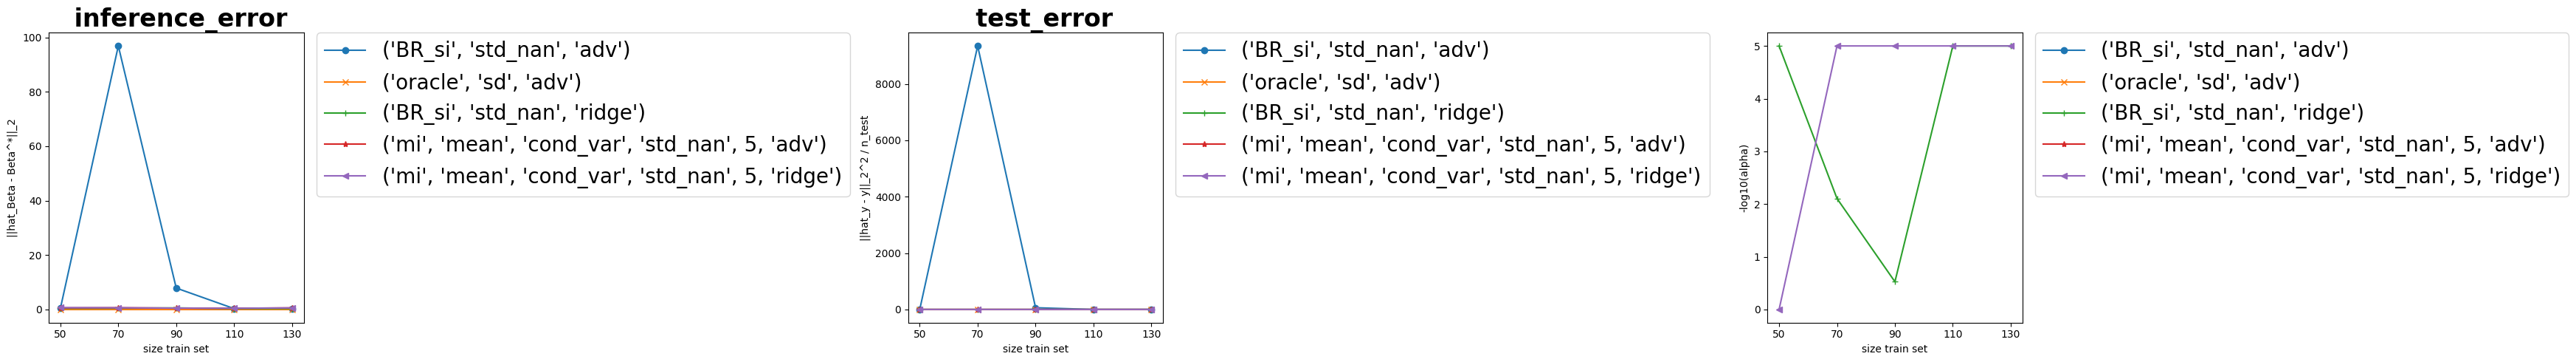

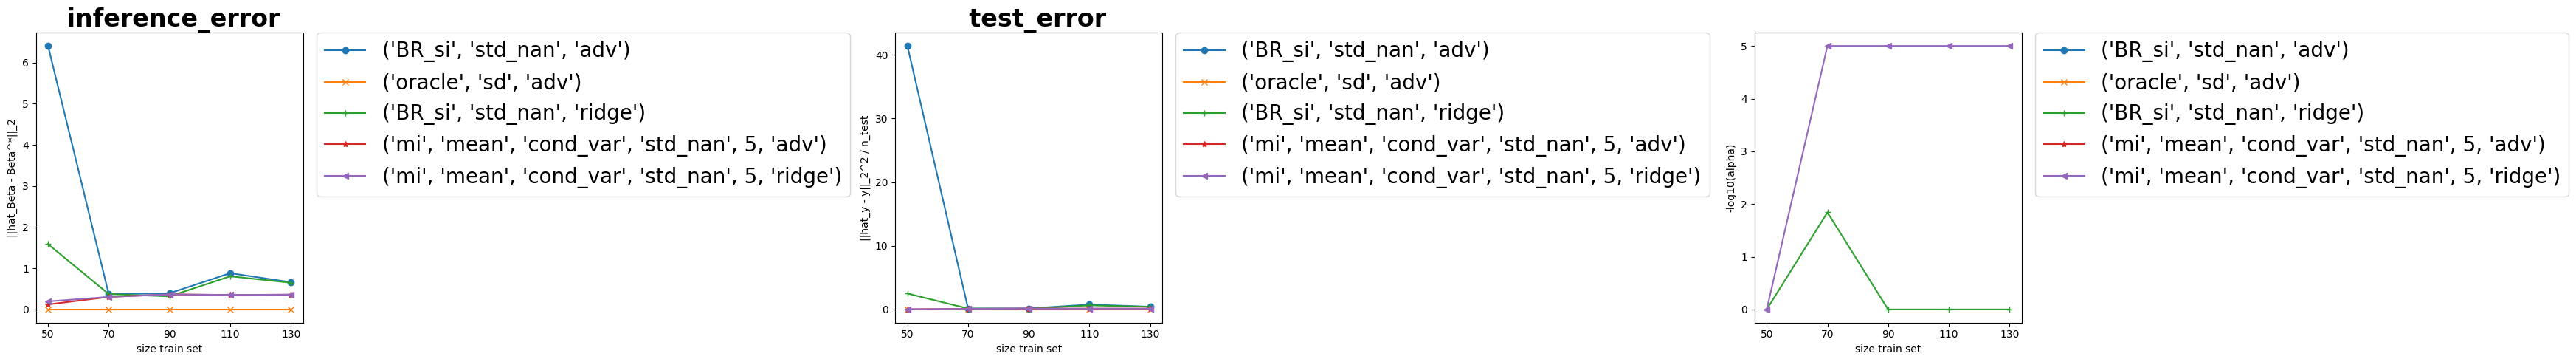

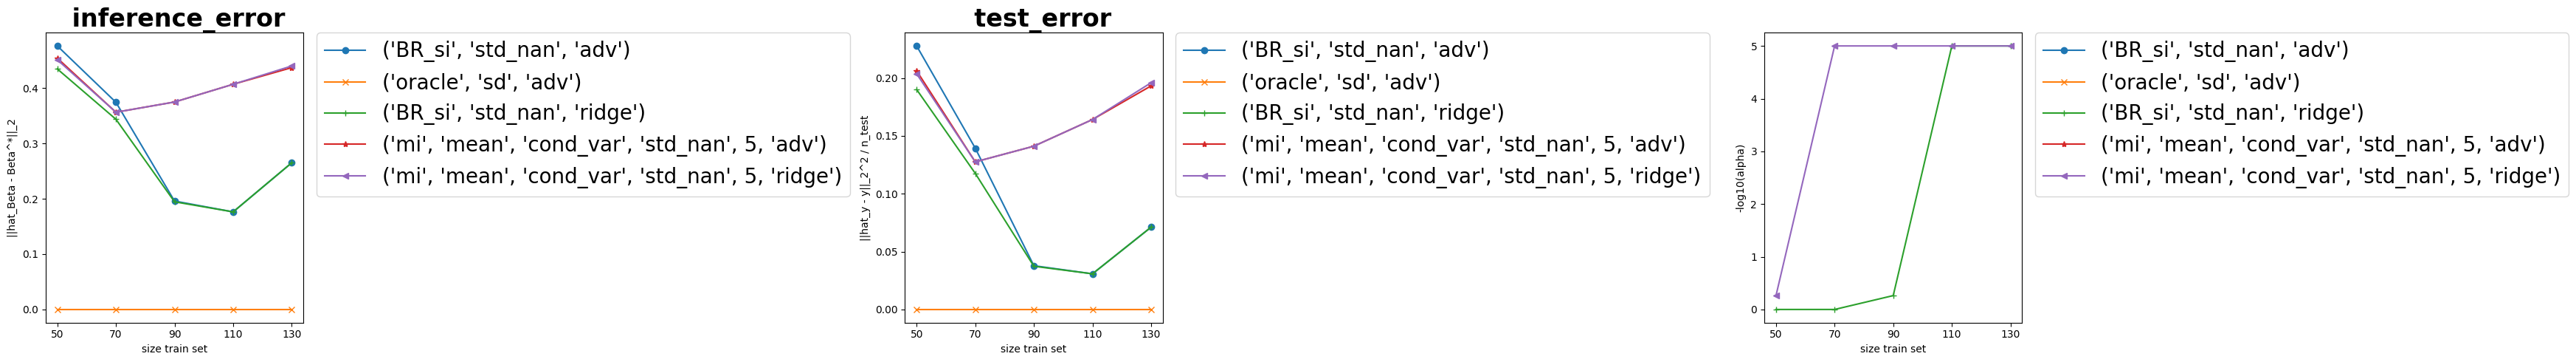

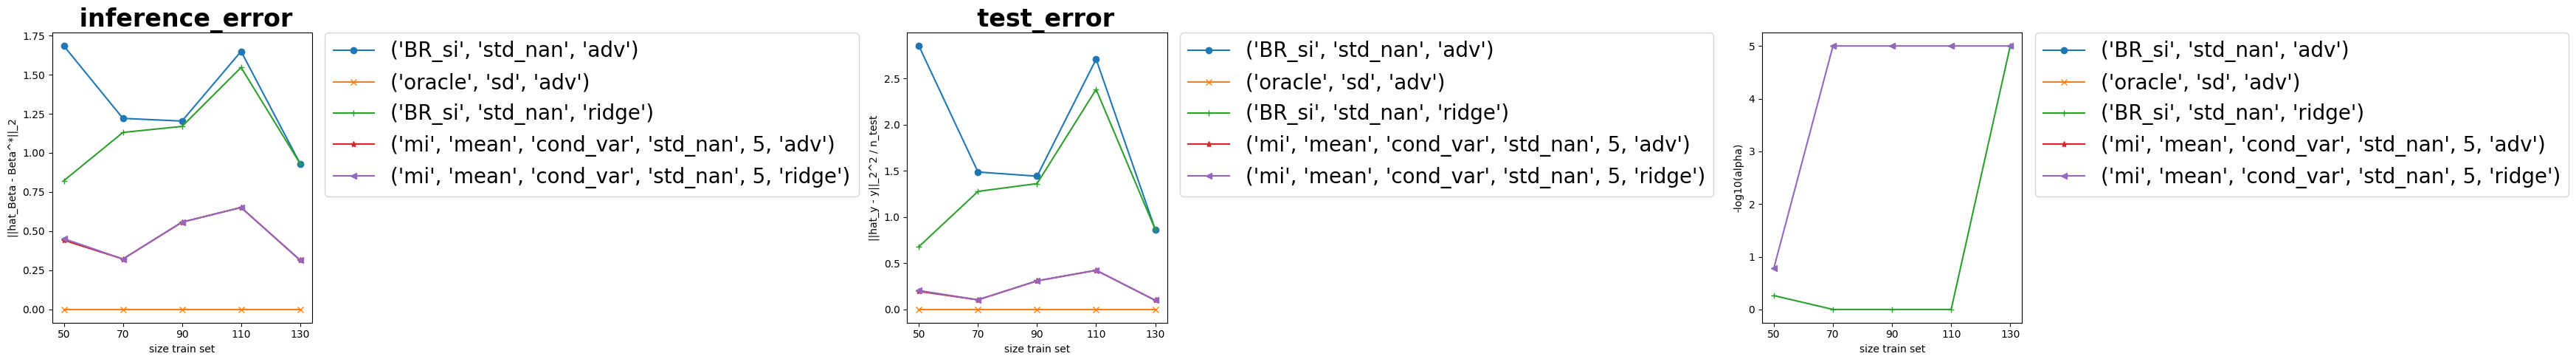

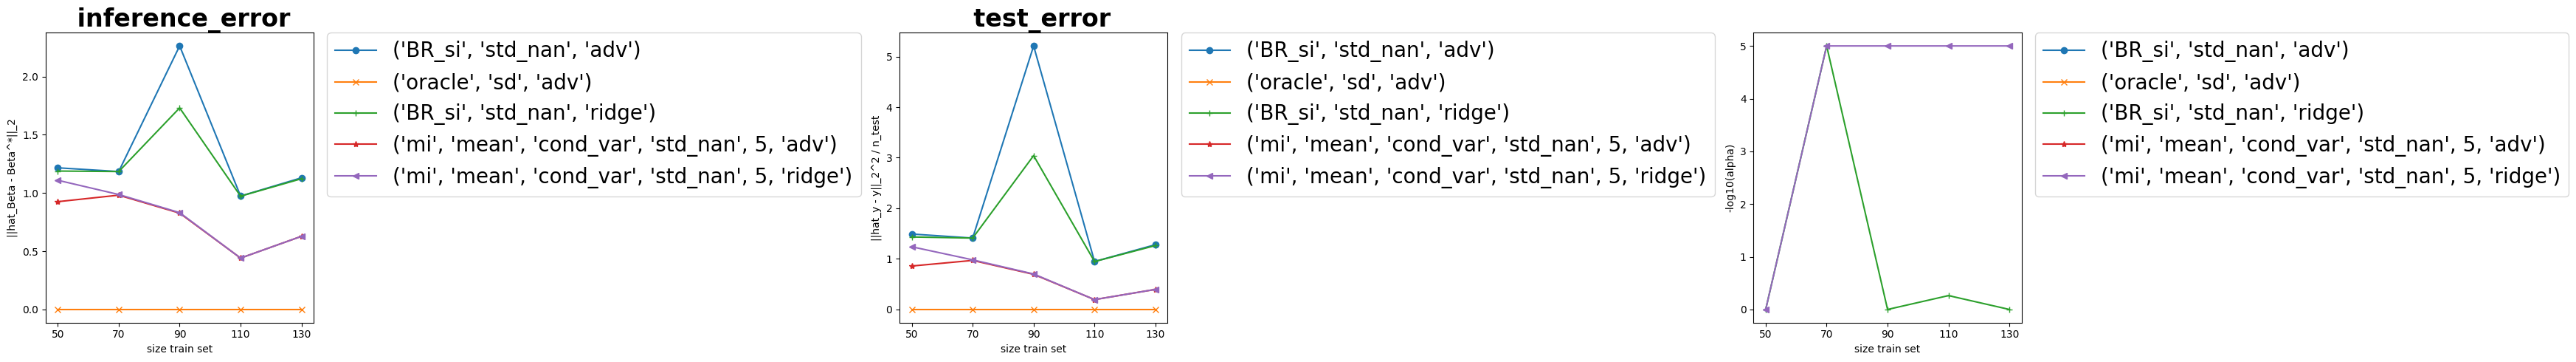

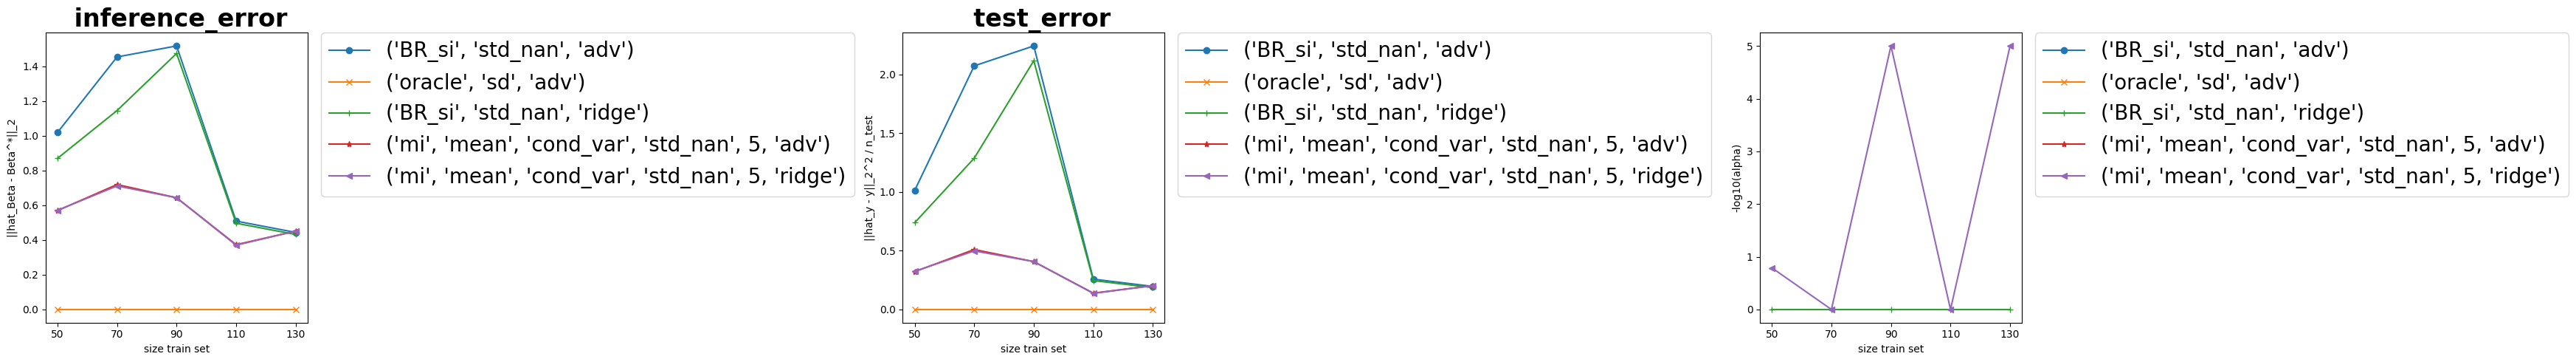

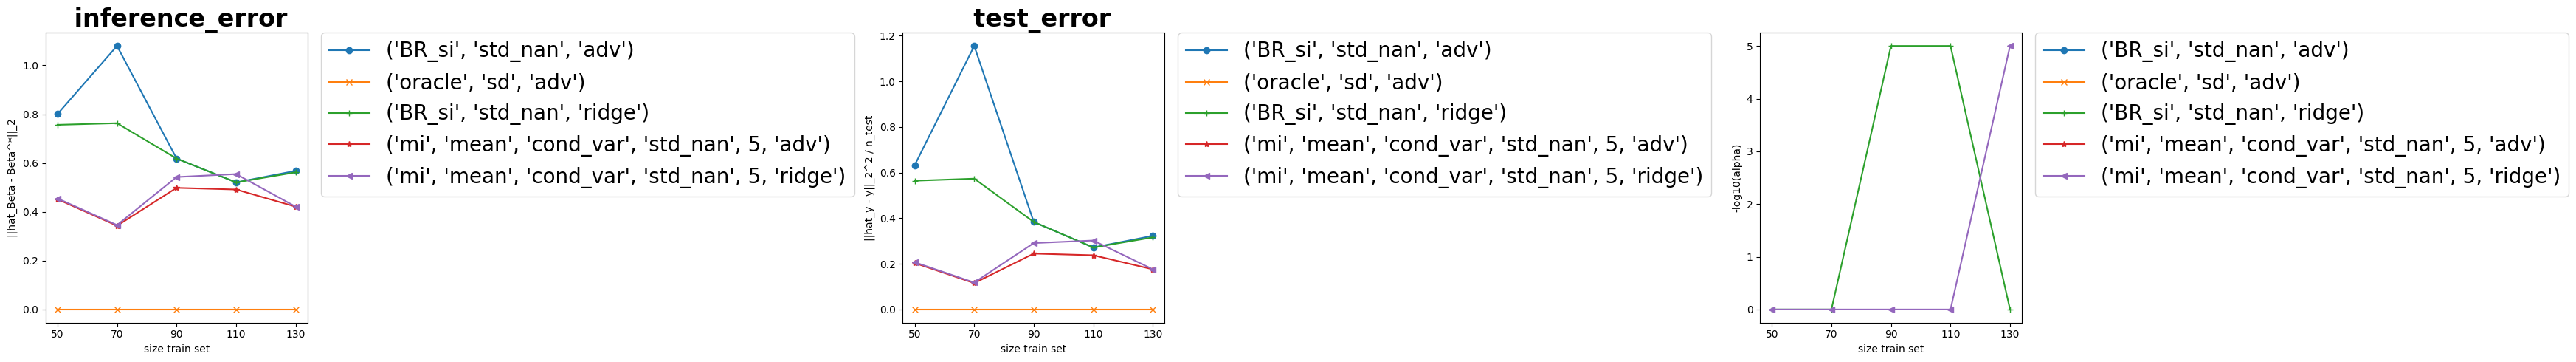

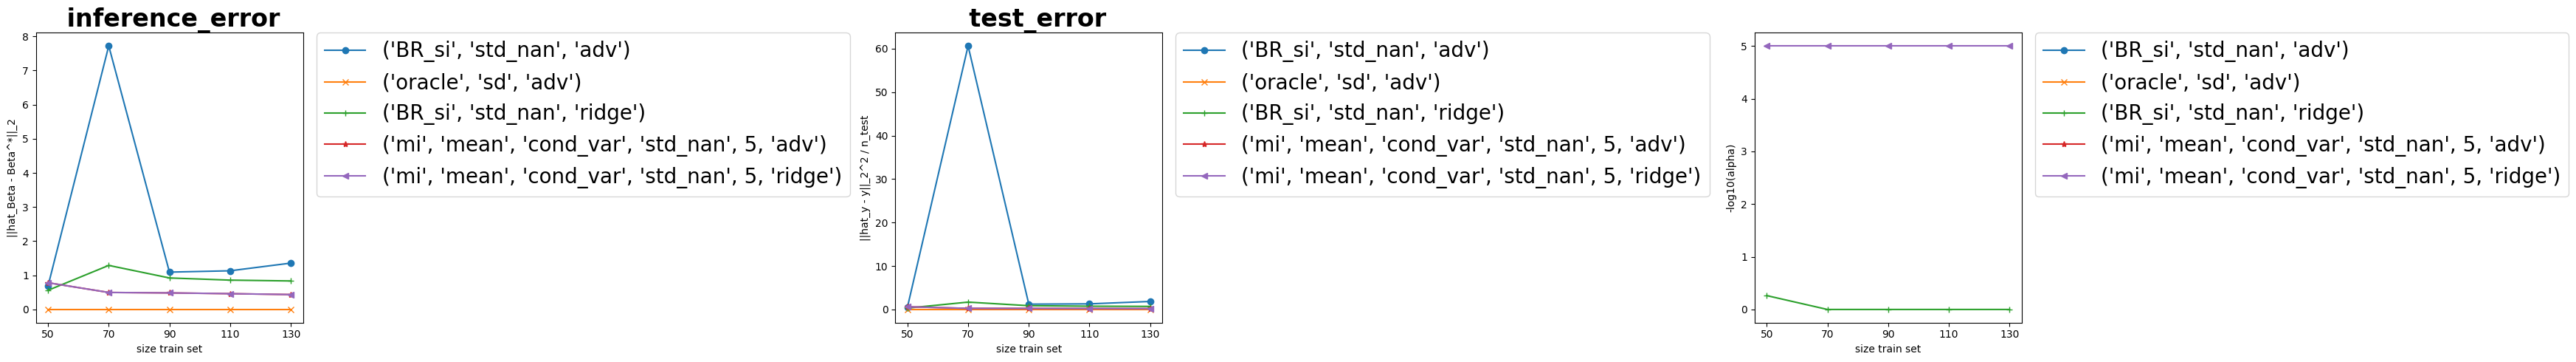

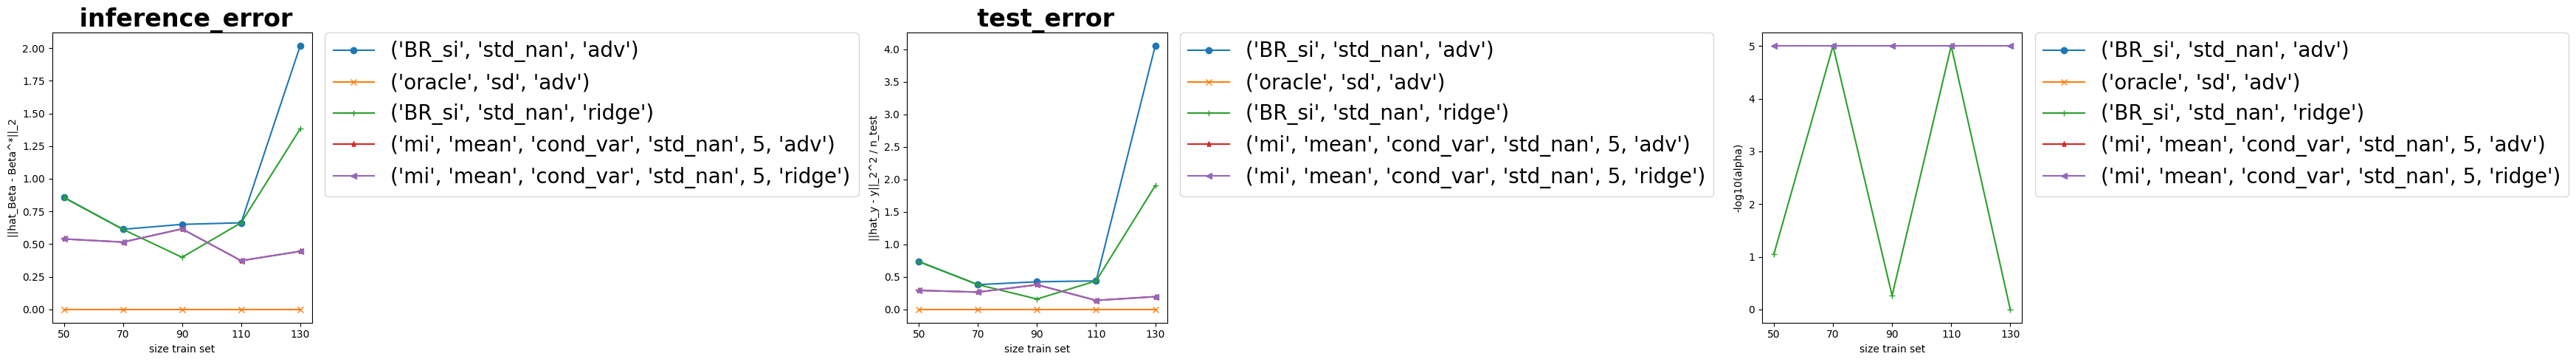

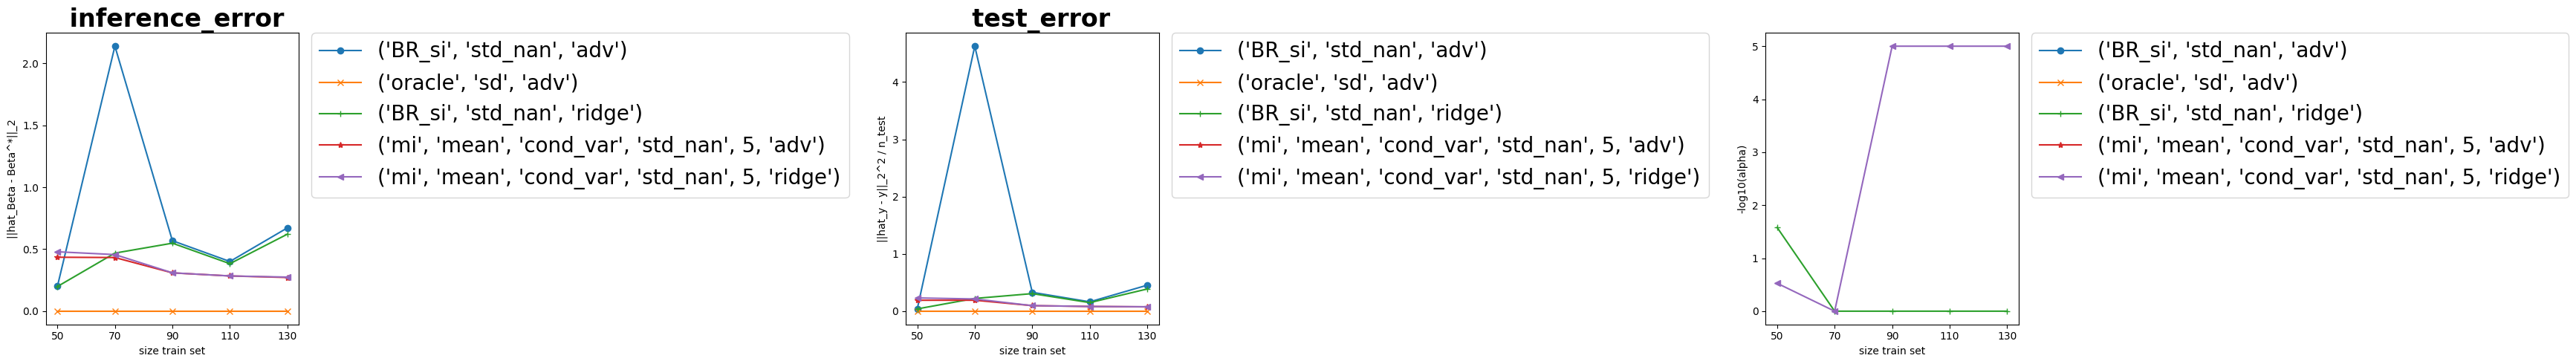

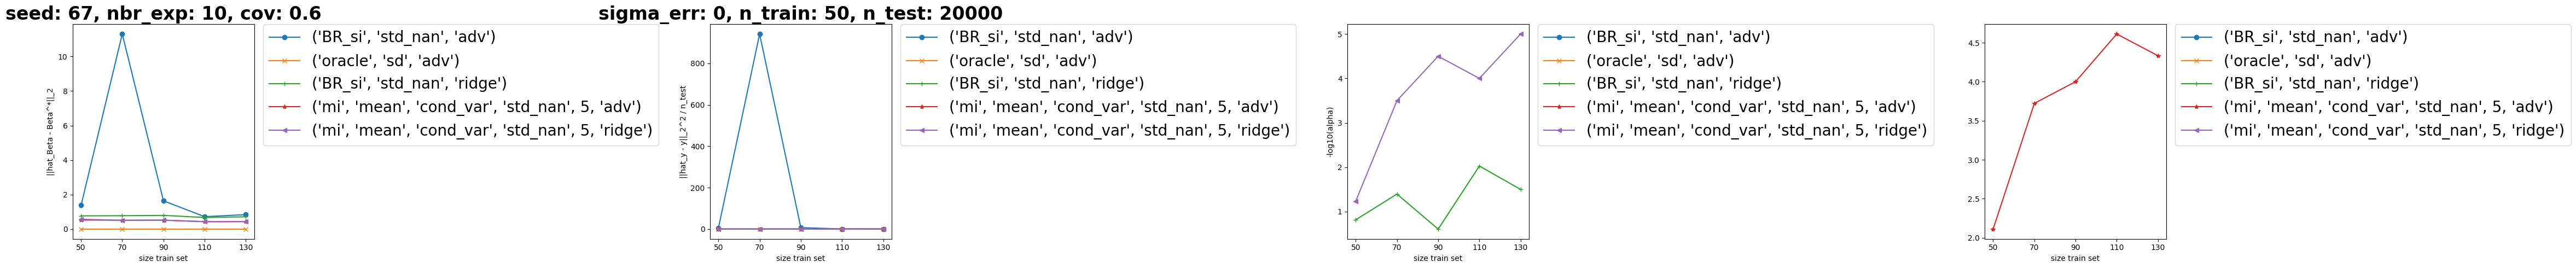

In [64]:

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

# def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
gen = 'fixed'
info_axis = 'train'  # train or p_seen
#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]
#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
#p_seen_both = [1, 0.9, 0.8/0.9, 0.7/0.8, 0.6/0.7, 0.5/0.6]
#p_seen_both = [1, 0.9, 0.8/0.9, 0.7/0.8, 0.6/0.7, 0.5/0.6, 0.4/0.5, 0.3/0.4]
n_train = [50, 70, 90, 110, 130]  # check how dataset are generated, there should be some problems with 'fixed'
lenght_vec = len(n_train)
p_seen_both = [0.50, 1, 1, 1, 1, 1, 1]
#p_seen_both = [1, 0.9, 0.8]
length_vec = len(p_seen_both)
#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
error_vec =  [0] * length_vec
#p_seen = make_probabilities(p_seen_both)
p_seen = [p_seen_both] * length_vec
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = np.cumprod(p_seen_both)  # p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)
number_test = 20000
cov_var = 0.6
#beta_gt = np.array([-0.5, 2, 1, 3, -2, -3, 4, 0.5, 7, -9, -1, -2, -3, 4, 5, 6, 7, 8])
#beta_gt = np.array([2, 4, -0.5, 2, 1, 3, -2, -3, 4, 0.5, 7, -9, -1, -2, -3, 4])
beta_gt = np.random.randn(6)
print(beta_gt)
dim = len(beta_gt)
mean = np.array([0] * dim)
matr = np.random.randn(dim, dim) * 1
cov = matr.T @ matr + np.eye(dim) * 0.5
# np.array([[1, cov_var], [cov_var, 1]])

dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=number_test,
    data = {'data': 'Gaussian', 'mean': mean, 'cov': cov},
    beta_gt = beta_gt,
    p_miss = p_seen,
    err_vector = ['Gaussian_on_X', error_vec],
    plots = []#['points', 'l1_vs_coef', '1/alpha_vs_coef']
)
#dicc = dicc | {'generation':gen}
dicc['what_to_plot'] = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha_dts']
dicc = dicc | {'generation': gen, 'title_infer_error':' inference_error', 'title_test_error':'  test_error'}
dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 0, 'adv_rad_times_delta_mis_max': 1, 'alpha_ridge_reg_max': 0,
                             'eps_adv_rad_times_delta_dts': 1e-5, 'eps_adv_rad_times_delta_mis': 1e-5, 'eps_alpha_ridge_reg': 1e-5,
                             'n_a_dts': 20, 'n_a_mis':10, 'n_a_rid': 1}}

for key, value in dicc.items():
  print(key, ": " , value)

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
mi_nbr = 5
# def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):

list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'adv'},  #, 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':3},
                        {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'},  #, 'multip_dataset': 3, 'multip_missing': 0},
                        {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'},#, 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':3},
                        #{'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn':'ridge'},#, 'multip_dataset': 3, 'multip_missing': 0},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'algo_superv_learn':'adv'}, #, 'multip_dataset': 3, 'multip_missing': 3},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'algo_superv_learn':'ridge'}
                        #{'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 3},
                        #{'imp_method': 'mi', 'cov_strategy': 'std_mi', 'mi_nbr': mi_nbr},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'cond_var', 'cov_strategy_within': 'sd', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 1},
                        #{'imp_method': 'mi_mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'eye', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.2},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.4},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.6},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 1},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr}#, 'multip_dataset': 3, 'multip_missing': 3}
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 5},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")

'''
nbr_exp = 2
#res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
#res[key_tuple]['best_coeff'].append(coeff_round)
#res[key_tuple]['best_score'].append(score_round)
#res[key_tuple]['best_alpha'].append(alpha_round)
res_l2 = []

rdm_seed = 4654321
np.random.seed(rdm_seed)
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)
if nbr_exp > 1:
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
    print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
    #np.random.seed(rdm_seed * (i+2))
    res_partial = run_experiments(dicc, list_methods_strategy)
    plot_res(info_x_axis, res_partial, dicc)
    print(res)
    for k in res:
      res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
      res[k]['best_score'].append(res_partial[k]['best_score'])
      res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
      #res[k]['best_coeff'].append(res_partial[k]['best_coeff
    #res.append(res['l2_dist_best_coeff_gt'])

print("final ")
print(res)
for k in res:
  print(k)
  print(np.array(res[k]['l2_dist_best_coeff_gt']))
  print(np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
  print(np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
#mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
for k, v in mean_res.items():
  print("k:   ", k)
  for s, t in v.items():
    print(s, ": ", t)
#print(np.mean(res, axis=0))
'''

nbr_exp = 10
seed = 67
mean_res = run_multiple_experiments(nbr_exp, seed, dicc, info_x_axis)
print("PLOT OF THE MEANS")
dicc['title_infer_error'] = 'seed: ' + str(seed) + ', nbr_exp: ' + str(nbr_exp) + ', cov: ' + str(cov_var)
dicc['title_test_error'] = 'sigma_err: ' + str(error_vec[0]) + ', n_train: ' + str(n_train[0]) + ', n_test: ' + str(number_test)
#dicc = dicc | {'generation':gen, 'title_infer_error':'mean_infer_error, rep: ' + str(nbr_exp), 'title_mean_error':'mean_test_error'}
dicc['what_to_plot'] = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha_dts', 'best_alpha_mis']
plot_res(info_x_axis, mean_res, dicc)

## you can see if you manage to take the index i that maximize alpha




In [ ]:
X = np.random.randint(2, 5, size=(2, 2, 2))
print(X)

XX = np.concatenate(X)
print(XX)


Y = np.random.randint(2, 5, size=(1, 3, 2))
print(Y)

YY = np.concatenate(Y)
print(YY)


Z = np.random.randint(2, 5, size=(5, 2))
print(Z)

ZZ = np.concatenate(Z)
print(ZZ)

print("other")
s = np.random.randint(2, 4, 5)
print(s)
z = np.tile(s, reps=3)  # np.array([s] * 2)
print(z)


print("other mult")
s = np.random.randint(2, 8, size=(3, 2))
print(s)
z = np.tile(s, reps=(3, 1))  # np.array([s] * 2)
print(z)


In [ ]:
'''
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)
'''

In [ ]:
'''
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)

fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)
'''

In [ ]:
'''
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)
'''

In [ ]:
'''
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
print("means ", mu)
delta = np.mean(masks) # parameter missingness
print("delta ", delta)
X_0 = np.nan_to_num(X_nan)
print("nbr obs", X_0.shape[0])
S_ellp =  X_0.T @ X_0 / X_0.shape[0]
S_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp
print("eig cov ", np.linalg.eigvalsh(S_ellp))
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance
sd_inv_ellp = np.std(X_ellp, axis=0)
print("sd ellp", sd_inv_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)
'''

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


# Example data
x_test_rect = np.random.rand(10)
y_test_rect = np.random.rand(10)

# Plot the points
fig, ax = plt.subplots()
ax.scatter(x_test_rect, y_test_rect)

width = 0.1
height = 0.1

#add_rectangles(x_test_rect, y_test_rect, width, height, ax)

# Add the rectangle to the plot


In [ ]:
# Cell for some tests

def test_clear_dataset(n, d):
  print("test clear dataset")
  X = np.random.randint(1, 3, size=(n, d))
  y = np.random.randint(1, 3, size=n)
  masks = np.random.binomial(1, 0.3, size=(n, d))
  print("X \n", X)
  print("y\n", y)
  print("masks \n", masks)
  masks[:, 0] = np.ones(n)
  masks[0, :] = np.ones(d)
  X_res, y_res, masks_res = clear_dataset(X, y, masks)
  print("X_res \n", X_res)
  print("y\n", y_res)
  print("masks \n", masks_res)
  print("test clear dataset ended successfully")

def test_generate_X():
    print("test generate_X started")
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf')
    gen = generate_X('circles', 2)
    data = gen(1000)
    print(data.shape)
    ax[0].scatter(data[:, 0], data[:, 1])
    print("test generate passed syccessfully")

def test_preparation_dataset(n, d):
      print("\ntest preparation dataset started")
      X_train = np.random.rand(n, d)
      print("X_train \n", X_train)
      mask = np.random.binomial(1, 0.5, (n, d))
      print("mask, 0 seen, 1 missing \n ", mask)
      X_masked = X_train * (1 - mask)
      print("X_masked \n", X_masked)
      X_nan_train = X_train.copy()
      X_nan_train[mask == 1] = np.nan
      print("X_nan_train \n", X_nan_train)
      X_br_train = single_imputation(X_nan_train, BayesianRidge())
      print("X_br_train\n ", X_br_train)

      print("what happens if we run single_imputation of full dataset")
      X_br_full = single_imputation(X_train, BayesianRidge())
      print("X_br_full\n ", X_br_full)
      np.testing.assert_allclose(X_train, X_br_full)  # shuold be untouched
      print("test preparation dataset ended successfully")

def test_listwise_delection(n, d):
    print("\n test list_wise delection started")
    X = np.random.rand(n, d)
    print("data\n", X)
    mask = np.random.binomial(1, 0.2, (n, d))
    print("mask \n", mask)
    X_ld = listwise_delection(X, mask)
    print("after calling function, X_ld \n", X_ld)

    print("edge cases, all missing")
    mask_1 = np.ones_like(X)  # all missing
    X1 = listwise_delection(X, mask_1)
    print("X1 \n", X1)  # should be empty
    mask_0 = np.zeros_like(X)  # all seen
    X0 = listwise_delection(X, mask_0)
    print("X0 \n", X0)
    np.testing.assert_allclose(X0, X)  # should be the original dataset

    print("one dimnsional array")
    y = np.random.rand(n)
    print("y before ", y)
    y_ld = listwise_delection(y, mask)
    print("y after ld ", y_ld)
    print("test listwise_delection passed")


test_generate_X()
test_preparation_dataset(3, 4)
test_listwise_delection(3, 4)
test_clear_dataset(6, 3)

xxx = np.random.randint(2, 5, size=(3, 3)) * 1.0
mmm = np.random.binomial(1, 0.5, size=(3, 3))
print(xxx)
print(mmm)
print(mmm == 1)
print(xxx[mmm == 1])
xxx[mmm == 1] = np.nan
print(xxx)
mask_from_xxx = np.isnan(xxx).astype(int)
print("mask from xxx \n", mask_from_xxx)


In [ ]:
# test best predictor

def test_best_predictor(n, d, nb_coeff):
  X_test = np.random.randint(1, 9, size=(n, d))
  beta_gt_test = np.random.randint(1, 7, size=d)
  y_test = X_test @ beta_gt_test
  #print("X_test \n", X_test, "\n beta_gt", beta_gt_test, "\n y_test = X_test @ beta_gt_test ", y_test)
  coeff_test = np.random.randint(1, 5, size=(d, nb_coeff))
  rdm_idx = np.random.randint(1, d+1, size=1)
  print(rdm_idx)
  #print("coeff test partial ", coeff_test[:, -1])
  rng = np.arange(nb_coeff)
  #print(rng != rdm_idx)
  coeff_test[:, rng != rdm_idx] = coeff_test[:, rng != rdm_idx] + 1000  # increase artificially the value of the other coefficient, to induce the minimum index to be rdm_idx
  #print("coeff_test \n", coeff_test)
  best_coeff, best_score = best_predictor(X_test, coeff_test, y_test)
  print("best coeff ", best_coeff)
  print("best score ", best_score)
  np.testing.assert_allclose(best_coeff, coeff_test[:,rdm_idx].squeeze())
  print("test best predictor passed")

test_best_predictor(100, 5, 20)




In [ ]:
# test train_and_plot

X_diab, y_diab = datasets.load_diabetes(return_X_y=True)
n, d = X_diab.shape
print("n:  ", n, ", d: ", d)
# Standardize data
X_diab -= X_diab.mean(axis=0)
X_diab /= X_diab.std(axis=0)

## original lasso
fig_l, ax_l = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_diab, y_diab)
plot_coefs_l1norm(coefs_lasso, ax_l)

## Antonio's algo, 1 matrix
S_diab_eye = np.eye(X_diab.shape[1])
fig, ax_1 = plt.subplots(1, 1, num='advtrain_linf_diab')
fig, ax_2 = plt.subplots(1, 1, num='advtrain_linf_diab_2')
train_and_plot(X_diab, y_diab, S_diab_eye, [ax_1, ax_2])

## Antonio's algo, multiple diagonal matrix
#S_diab = np.eye(X_diab.shape[1])
#S_diab = np.random.randint(1, 3, size=(n, d))
#print(S_diab)
#fig, ax_5 = plt.subplots(1, 1, num='advtrain_linf_diab_5')
#fig, ax_6 = plt.subplots(1, 1, num='advtrain_linf_diab_6')
#train_and_plot(X_diab, y_diab, S_diab, [ax_5, ax_6])


## Antonio's algo, multiple matrices (same matrix stacked multiple time)
S_diab_stacked = np.array([S_diab_eye] * X_diab.shape[0])
S_diab_stacked = np.concatenate(S_diab_stacked)
fig, ax_3 = plt.subplots(1, 1, num='advtrain_linf_diab_3')
fig, ax_4 = plt.subplots(1, 1, num='advtrain_linf_diab_4')
train_and_plot(X_diab, y_diab, S_diab_stacked, [ax_3, ax_4])




In [ ]:
# test imputations

np.random.seed(45)


def test_imputations(n, d):
  X = np.random.randint(2, 5, size=(n, d)) * 1.0
  y = X @ np.random.randint(1, 3, size=d)
  m = np.random.binomial(1, 0.4, size=(n, d))  # 1 missing, 0 seen
  print("m original\n", m)
  X, y, m = clear_dataset(X, y, m)
  print(m)
  X_nan = X.copy()
  X_nan[m == 1] = np.nan

  #mask_from_xxx = np.isnan(xxx).astype(int)
  print("X\n ", X)
  print("masks \n", m)
  print("X_nan\n ", X_nan)
  methods = ['BR_si', 'mi', 'l_d']
  nbr_mi = [1, 3]
  #for method in methods:
  #  dict_info = {'imp_method': method, 'mi_nbr':nbr_mi}
  #dict_info = {'imp_method':methods, 'mi_nbr':nbr_mi}
  for method in methods:
    print("---------- method: ", method)
    if method == 'mi':
      for x in nbr_mi:
        print("-------------------- nbr mi: ", x)
        dict_info = {'imp_method':method, 'mi_nbr':x}
        #print("XNANNANAN ", X_nan)
        X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
        print(X_res, y_res, "\n", mask_res)
    else:
      dict_info = {'imp_method': method}
      X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
      print(X_res, y_res, "\n", mask_res)
    print("test imputations ended successfully")

test_imputations(6, 3)


In [ ]:
x = []
y = np.array([1, 2])
x.append(y)
x.append(y)
x.append(y)
xx = np.stack(x)
print(x)
print(xx)
print(type(xx))


import matplotlib.pyplot as plt

sizes = [100, 1000, 10000, 100000]
values = [0.8, 0.85, 0.9, 0.92]
positions = range(len(sizes))

plt.plot(positions, values, marker='o', label='Model Accuracy')  # Add label here
plt.xticks(positions, sizes)

plt.xlabel("Dataset Size (equispaced)")
plt.ylabel("Accuracy")
plt.title("Performance vs Dataset Size (equispaced x-axis)")
#plt.legend()  # Show legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()



In [ ]:

dictio = {'a':1, 'b':2, 'c':3}
vv = dictio.values()
#print(vv)
#print(vv[1])

x1 = np.array([1, 2, 3])
x2 = np.array([3, 2 ,1])
v = np.maximum(x1, x2)
print(v)


In [ ]:
m, n, d = 2, 3, 2
x_int = np.random.randint(1, 9, (m, n, d))
print(x_int)
s = np.std(x_int, axis=0)
print(s)

# manual
print("manual computation")
x = np.zeros((m, d))
for i in range(n):
  print("i -----> ", i)
  x = x_int[:, i, :]
  print("x\n", x)
  ss = np.std(x, axis=0)
  print(ss)


print("little exp on squeeze")
sss = np.random.rand(1, 3, 3)
print(sss)
print(sss.squeeze())
print(sss.squeeze())



In [ ]:
int(34.99)

xxxx = np.random.randint(2, 4, (5, 2))
print(xxxx)
xxxx[0:2, :] = 1
print(xxxx)

print("yyyy\n")
yy = []
yy.append([1, 2, 3])
yy.append([4, 5, 6])
print(yy)
print(np.stack( yy ).T)
print("\n\n")
yyy = np.random.randint(1, 10, size=(3 , 3))
print(yyy)
yyy_a = np.array([yyy] * 2)
print(yyy_a.shape)
print(np.concatenate([yyy] * 2))
#print(np.tile(yyy_a, (2, 1, 1) ))

zzz = np.zeros((2, 2))

np.sum(np.zeros((2, 2)) == zzz)

In [ ]:

def multiple_imputation1(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


Xx = np.random.randint(1, 3, (4, 4)) * 1.0
mm = np.random.binomial(1, 0.25, (4, 4))
print(Xx)
print(mm)
Xx[mm == 1] = np.nan
print(Xx)

ice = IterativeImputer(random_state=18, max_iter=50, sample_posterior=True)
ice.fit(Xx)
XxX = np.random.randint(1, 3, (2, 4)) * 1.0
mmM = np.random.binomial(1, 0.5, (2, 4))
print(XxX)
print(mmM)
XxX[mmM == 1] = np.nan
print(XxX)

print(ice.transform(XxX))
print(ice.transform(XxX))

print("new")

ls = [[[]],[[]]]
print(ls)
ls[0][0]



In [ ]:
import numpy as np

XX = np.random.randint(1, 7, (2, 3, 3))
print(XX)
XXX = np.tile(XX, (2, 1, 1))
print(XXX)

print(np.zeros(2))

y_o = np.array([1, 2])
y_oo = np.tile(y_o, 3)
print(y_oo)


In [ ]:
import numpy as np
def generate_masks_binomial_general(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks


#mm = np.random.binomial(1, [[0.2, 0.2, 0.2], [0.8, 0.8, 0.8]], (2, 3, 3))
#print(mm)
cc = np.array([np.random.binomial(1, x, (4, 4)) for x in [0.2, 0.2, 0.2]])
print(cc)
s_cc = np.cumsum(cc, axis=0)
print(s_cc)
s_cc[s_cc>1] = 1
print(s_cc)

s_v = np.random.randint(1, 4, (3, 4))
print(s_v)
s_vv = s_v[:, None, :] * np.eye(4)
print(s_vv)









In [ ]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import ridge_regression

X = np.random.randn(100, 4) #rng.randn(100, 4)

y = 2.0 * X[:, 0] - 1.0 * X[:, 1] + 0.1 * np.random.randn(100)
np.random.seed(4)
alphas = [0.00001, 0.001, 0.1, 1]
estim = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=False, random_state=0)
for a in alphas:
  #coef, intercept = estim(X, y, a)
  coef = estim(X, y, a)
  print("coef : ", coef)
  #print("intercpt ", intercept)
  coef, intercept = ridge_regression(X, y, alpha=a, return_intercept=True, random_state=0)
  #print("coef : ", coef)
  #print("intercpt ", intercept)


lg = np.random.logistic(loc=0.0, scale=1.0, size=(4, 3))
print("log res ", lg)

